# Attempt to split available, suitable QCA datasets into data for benchmarking

Our plan here is to utilize the training molecules, along with information on chemical similarity and parameter coverage, to split the available benchmarking data into:
1. Primary sets, covering similar chemistry as training data:
   a. Test set, to be revisited potentially several times while testing
   b. Benchmark set, to be used only in assessing final FF
2. "Stretch" sets, covering more chemical diversity
   a. Test set, to be revisited potentially several times during testing
   b. Benchmark set, to be used only in assessing final FF
   
Partitioning into test and benchmark sets will be done randomly.

In this notebook we are mainly concerned about the filtering procedure to divide between primary and stretch sets.

## Big picture outline
1. Obtain training set data and potential test set data
2. Obtain parameter usage statistics for training set data (TO BE DONE) 
3. Compute chemical graph similarity matrix of all molecules
4. Cluster all molecules based on graph similarity using `DBSCAN`
5. Pick potential test set molecules as those which are in clusters with at least one training set molecule. 
6. Save molecules which are NOT in clusters with training set molecules as potential "stretch test set" molecules
7. Check parameter usage of all potential primary test set molecules; any which use especially unusual parameters get moved from test set to stretch test set
8. Take candidate test set/stretch test set molecules and randomly partition them into test and benchmark sets (primary and stretch)



# Begin

## Begin by grabbing datasets we fit to from QCA

Specifically, we're interested in seeing which molecules are present in those sets.

In [21]:
import sys
import os
import qcfractal.interface as ptl
from rdkit import Chem
from rdkit.Chem import FragmentMatcher


molecule_smiles = []
client = ptl.FractalClient()

# databases we want to search
ds_keys = [['TorsionDriveDataset', 'OpenFF Group1 Torsions'], \
           ['OptimizationDataset', 'SMIRNOFF Coverage Set 1']]

           #['OptimizationDataset', 'OpenFF Discrepancy Benchmark 1']]

for key in ds_keys:
    print("Loading dataset {:s} {:s} ... \n".format(*key))
    ds = client.get_collection(*key)

    ds_keys = ds.data.records.keys() #Keys look like SMILES but aren't quite
    ds_smiles = []
    #Retrieve actual smiles
    for key in ds_keys:
        ds_smiles.append( ds.data.records[key].name )
        
    for smi in ds_smiles:
        molecule_smiles.append(smi)
                
print(molecule_smiles)         

Loading dataset TorsionDriveDataset OpenFF Group1 Torsions ... 

Loading dataset OptimizationDataset SMIRNOFF Coverage Set 1 ... 

['c1c[cH:1][c:2](cc1)[CH2:3][c:4]2ccccc2', 'c1cc[c:4](cc1)[CH2:3][c:2]2[cH:1]cccc2', 'c1c[cH:1][c:2](cc1)[O:3][c:4]2ccccn2', 'c1cc[c:4](cc1)[O:3][c:2]2cccc[n:1]2', 'c1c[cH:1][c:2](cc1)[NH:3][c:4]2ccccn2', 'c1cc[c:4](cc1)[NH:3][c:2]2cccc[n:1]2', 'c1c[cH:1][c:2](cc1)[NH:3][c:4]2ccccc2', 'c1cc[c:4](cc1)[NH:3][c:2]2[cH:1]cccc2', 'C[N:3]([c:2]1[cH:1]cccc1)[c:4]2ccccc2', 'C[N:3]([c:4]1ccccc1)[c:2]2[cH:1]cccc2', 'C[N:3]([c:2]1[cH:1]cccc1)[c:4]2ccccn2', 'C[N:3]([c:4]1ccccc1)[c:2]2cccc[n:1]2', 'c1c[cH:1][c:2](cc1)[O:3][c:4]2ncccn2', 'c1cc[c:4](cc1)[O:3][c:2]2[n:1]cccn2', 'c1c[cH:1][c:2](cc1)[CH2:3][c:4]2ccccn2', 'c1cc[c:4](cc1)[CH2:3][c:2]2cccc[n:1]2', 'c1cc[n:1][c:2](c1)[CH2:3][c:4]2cccc(=O)[nH]2', 'c1ccn[c:4](c1)[CH2:3][c:2]2[cH:1]ccc(=O)[nH]2', 'c1c[cH:1][c:2](cc1)[N:3]2[CH2:4]C[NH2+]CC2', 'c1c[n:1][c:2](nc1)[N:3]2[CH2:4]C[NH2+]CC2', 'Cc1ccc[cH:1][c:2]1[N:3]2[CH2

In [2]:
# Better is to get the molecules we've fit to from Yudong Qiu's releases, as not all molecules in the QCA datasets were
# used in fitting -- e.g. we pruned any with torsions we don't cover, for example.

# Slack discussion here: https://openforcefieldgroup.slack.com/archives/C8P8MLALD/p1568325818091700
# Script for extracting molecules from a release: https://github.com/lpwgroup/forcebalance-qcarchive/blob/master/analysis_scripts/find_unique_molecule_smiles.py
# Set from most recent release: https://openforcefieldgroup.slack.com/files/U8ZH3MTL2/FNBUUCADB/target_smiles.txt

In [23]:
# Load molecules used in release-1 fitting
file = open('target_smiles.txt', 'r')
text = file.readlines()
release_smi = [ line.split()[0] for line in text]


# Pull discrepancies set from https://github.com/openforcefield/qca-dataset-submission/blob/master/2019-07-05%20eMolecules%20force%20field%20discrepancies%201/optimization_inputs.smi

discrepancies_set = """C1C2COC(O2)CC1=O
c1cc(c(cc1O)C2CCN2)Br
CCOC(=O)c1cc(ncc1C#N)C
Cc1ccccc1c2nc(on2)C(=Cc3ccc(cc3)C#N)C#N
c1ccc2c(c1)OCS2
c1csc(c1Br)C(CC#N)N
COc1cccc(c1)N2CCCNCC2
Cc1ccc(c(c1)C)C=NNc2ccnc3c2ccc(c3)Cl
Cc1ccc(cc1)Nc2c3c(ncn2)CCN(CC3)S(=O)(=O)C
c1ccn2c(c1)nnc2c3cccc(c3)O
c1cc(oc1)C(=O)ON=C2C3CC4CC(C3)CC2C4
CC(C)(C#N)N=NC(=O)N
c1cc(c(c(c1)C(F)(F)F)Cl)C2CCN2
c1c(nc(cn1)Cl)SC(F)(F)F
CCOc1cc(ccc1Cl)C(F)(F)F
c1c(cc(cc1OC(F)(F)F)F)CBr
Cc1c(c(c([nH]1)C(=O)O)C(C)C)C(=O)C
Cc1ccncc1C(=O)C
c1cc(c(cc1Cl)C2CCN2)Br
Cc1cc(cc(c1)Br)OC(F)(F)F
c1cc(ccc1O)OC(C(F)F)(F)F
Cc1cc(ccc1CC(=O)N2CCC3C(C2)CC(O3)C)F
c1cc(c(cc1C(=O)CBr)Cl)F
Cn1cnnc1CN2CCC3(C2)CCCN(C3=O)C4CCCCC4
CN1CCN(Cc2c1nccc2)C(=O)NC3CC3
Cn1cnnc1c2cc(cnc2)O
CN1CCCC2(C1=O)CCN(C2)C(=O)CSC
c1cc(sc1)CC(=NO)N
c1ccc(cc1)OC(Cl)(Cl)Cl
c1c(c(cnc1Cl)C(=O)O)I
c1cc(c(cc1Br)N2CCCC2C(=O)O)[N+](=O)[O-]
c1ccc(c(c1)C=Nc2ccc(c(c2)C(=O)O)O)Cl
Cc1c(c(ccc1C(=O)OC)Br)C
Cn1c2ccccc2nc1NN=C3CCCOc4c3ccc(c4)Br
Cn1ccc(n1)NC(=O)N2CCCC3(C2)CCCCCC3
c1c(cc(c(c1F)C2CCN2)F)Br
c1c(c(c(c(c1F)F)F)F)C(=O)C2CC2
c1c(c(cc(c1Cl)Cl)OC(Cl)(Cl)Cl)[N+](=O)[O-]
c1cc(c(cc1OC(Cl)(Cl)Cl)C(F)(F)F)Cl
c1ccc2c(c1)ccc(n2)C=Nc3ccccc3Cl
Cn1c2cc(ccc2nc1N=Nc3ccc(cc3)OC)Br
CN1CCc2c(sc(n2)C(=O)c3nc4c(s3)CN(CC4)C)C1
c1cc(c(nc1)C#N)C(=O)O
C1CC2(CCN(C2)C(=O)CN3CC(=O)NC3=O)C(=O)NC1
Cc1c(c(n(n1)C)C)N=Nc2c3ccccc3cc(c2O)C(=O)O
CC1(C2CCC1(C(=NOC(=O)c3cccc4c3cccc4)C2)C)C
c1ccc(cc1)CN2CC(=O)C3(C2=O)CC3
CC1CC2CN(CCC2O1)C(=O)CS(=O)(=O)C
c1c(c(cc(c1Br)F)O)C(=O)O
c1ccc(cc1)CN2CCCC(C2=O)O
c1cc2c(cc1OC(F)(F)F)nc(s2)S
c1cc(c(cc1Br)OCCBr)Br
c1ccc(c(c1)C(=O)C=O)F
CN1CCCC12CCCN(C2)C(=O)Cc3cccs3
c1cc2cc[nH]c2c(c1)OC(F)(F)F
c1cc(ccc1CC(=O)N2CCOCC2)Br
CCOC(=O)c1ccc(c(c1F)F)F
CCc1c(c(n(n1)C)OC)CN
Cc1cc([nH]n1)Nc2ccccn2
c1cc(c(c(c1)F)F)C(=O)Nc2c(n3c(n2)SCC3)C#N
Cc1cc(=O)[nH]c(n1)NN=Cc2ccccc2O
Cc1ccccc1c2nnc(n2N=Cc3csc(n3)C)S
c1c(cc(c(c1[N+](=O)[O-])N)Cl)Br
Cc1ccc(cn1)C(=O)N2CCC3(CCCN3S(=O)(=O)C)CC2
c1ccc2c(c1)CC(=NOC(=O)c3cccs3)C2
c1ccc2c(c1)C3=NCC(=O)N3S2(=O)=O
c1cc(c(c(c1)[N+](=O)[O-])C#N)C(=O)O
Cc1ccc(c(n1)C(=O)OC)O
c1c(c(c(c(n1)C(=O)O)Br)Cl)Br
Cc1ccc(c(c1)C)C=C(C#N)c2[nH]c3ccccc3n2
CCOc1cc2c(cc1Br)CCC(=O)N2
Cc1nnc(n1N)NN=Cc2cccs2
c1ccc2c(c1)C(=O)NC(=C(C#N)C(=O)CN3CCCC3)N2
CCOc1cccc(c1I)Br
c1c(c(cc(c1Br)F)[N+](=O)[O-])C=O
CCOC(=O)c1cccc2c1OCO2
c1cnc(nc1)N2CC(C3CCOC3C2)C(=O)N4CCCC4
c1cc(cnc1)C=NNc2ccc(cc2)Cl
CN1CCCC2(C1=O)CCN(C2)C(=O)Cc3c(ccc(c3F)Cl)F
c1cc(ccc1C(=NO)N)Br
COc1ccnc(c1)C2(CC2)C#N
c1cc(c(cc1OC(F)(F)Cl)[N+](=O)[O-])F
Cc1cc(nc(n1)NN=Cc2ccc(c(c2O)O)O)C
c1ccc(c(c1)C2CCN2)C(F)(F)F
Cc1ccc(cc1)N=Nc2cnc(nc2c3ccc(cc3)Cl)N
CC(=O)Sc1cc(c(c(c1)F)F)F
CC1CN(CC1(C)O)c2c(nccn2)N(C)C
Cn1c(cc(=O)n(c1=O)C)NN=Cc2ccc3c(c2)OCO3
c1ccc2c(c1)nc(c(n2)Cl)NN=Cc3ccc(cc3)O
CCOC(=O)c1c(cc(cn1)C)C
c1cc(c(cc1Cl)OC(F)(F)Cl)[N+](=O)[O-]
CCC1COC(=O)N1c2cccc(c2)C(=O)C
c1cc(oc1C2CCN2)Cl
CCOc1cc(ncc1Br)Cl
c1c(c(cc(c1N)Cl)F)C(=O)O
c1c[n+](c(n1O)C(=O)N)[O-]
CC(c1cc(ccc1[N+](=O)[O-])F)N
c1cc(ccc1C=NN=C2N=C(CS2)O)F
Cc1cc(ccc1Cl)N=C=O
Cc1csc(n1)NC(=O)C2c3ccccc3-c4c2cccc4
c1cc(c(cc1OC(F)(F)F)Cl)CCl
COC(=O)c1cc(ncc1[N+](=O)[O-])Br
c1cc(c(c(c1F)[N+](=O)[O-])F)Cl
COC(=O)c1cc(cc2c1OCO2)Br
Cc1c2ccccc2c(=O)n(n1)CC(=O)N3CCc4c(sc(n4)N)C3
c1ccc2c(c1)C(=O)N(C2=O)CC(=O)N3CCNCC3
c1c(nc(s1)CN)Br
CS(=O)(=O)N1CCC2(C1)CCCN(C2)Cc3ccccn3
Cc1cc(nc(n1)NN=Cc2ccc(o2)I)C
c1ccc2c(c1)CCCN2S(=O)(=O)c3ccccc3C#N
c1cc2cccnc2c(c1)NC(=O)N3CCCC4(C3)OCCO4
COC(=O)C1CC(CN1)(F)F
c1cc(c(nc1)Oc2ccc3c(c2)OCO3)[N+](=O)[O-]
Cc1ccc(c2c1c(cc(n2)CN3CC(C3)N4CCCCC4)O)C
c1cc(c(c(c1F)[N+](=O)[O-])O)Br
CC(C)(C#N)N=NC(C)(C)C(=O)N
Cc1ccc(cc1C)C(=O)C(=CN(C)C)C#N
Cc1cc(c(nc1Cl)N)[N+](=O)[O-]
c1cc(c(cc1F)C2CCN2)Cl
Cc1ccc(cc1Cl)NN=Cc2ccc(c(c2)F)F
c1cc(c(cc1F)OC(F)(F)Cl)[N+](=O)[O-]
c1c(cc(cc1OC(Cl)(Cl)Cl)Br)C(F)(F)F
c1c(c(sc1Cl)Cl)S(=O)(=O)Nc2nncs2
C1CC1(C(=O)O)F
Cc1cc(c(cn1)Br)C(=O)O
CN(Cc1ccccc1)c2c3ccccc3nc(n2)Cl
c1cc(c(c(c1[N+](=O)[O-])Br)F)Br
c1cc(cc(c1)F)OC(Cl)(Cl)Cl
c1cc(c(cc1F)Cl)CC(=NO)N
Cc1ccc(cc1)N=Nc2c([nH]nc2N)N
c1cc(c(c(c1)C(=O)O)F)C#N
Cc1cc(=O)[nH]c(n1)NN=Cc2ccccc2F
c1ccc2c(c1)c(cs2)C3CCN3
C1CC1CC(=O)N2CCC3(C2)CCOC3
Cc1c(c(n(n1)c2ccc(cc2)F)Cl)C=Nc3cccc(c3)C#N
CC(C)N1CCCC2(C1=O)CCN(C2)S(=O)(=O)N3CCN(CC3)C
COCC(=O)N1CCC2CCC(C1)N2
c1c(c(cc2c1OCO2)Cl)C3CCN3
c1cc(c(c(c1)F)C2CCN2)C(F)(F)F
COC1CCC2C1OCCN2C(=O)c3ccc(c(c3)Cl)F
c1cc(c(nc1)O)c2nc(no2)c3ccsc3
CC1CN(CCC1(C)O)C(=O)Cc2cc(cc(c2)Cl)F
Cc1cc(ccc1C2CCN2)Cl
Cn1cccc1C(CF)N
Cc1nc([nH]n1)CN
CC1(CC2(CCNCC2)CO1)C
c1nnc2n1nc(s2)NC(=O)C34CC5CC(C3)CC(C5)(C4)O
CCc1ccc(s1)S(=O)(=O)N2CC(=O)N(c3c2cccc3)C
c1ccc2c(c1)CCCN2C(=O)Cc3c(c(c(c(c3F)F)F)F)F
Cc1ccc(c(c1[N+](=O)[O-])F)C
c1cnc(nc1C=NO)N
C1CC2CC(CC1C2=NO)C(=O)O
CCOc1ccc(cc1F)SC
c1cc(cc(c1)O)CC(=O)N2CCC3(CC2)OCCO3
CN(C)c1ccc(cc1)N=Nc2ccc(cc2Cl)N
Cc1nnc2n1cc(cc2)C(=O)N3CC(Sc4c3cccc4)(C)C
Cc1ccc(nn1)c2nc(on2)c3cccc(c3O)OC
CN1CC2(CC1=O)CNCCN(C2)C(=O)Nc3ccccc3
c1cc(ccc1N=Nc2ccc(cc2F)O)S(=O)(=O)O
c1cc(c(cc1I)C(=O)O)C#N
c1cc(c(c(c1)Cl)F)OCCC#N
Cc1cc(nc(c1[N+](=O)[O-])Br)Br
c1c(cc(c(c1F)Cl)F)OC(F)(F)F
COC(=O)c1cc(c(cc1F)Br)F
CCc1cccc(c1)Nc2c3ccc(cc3ncn2)Cl
c1ccc2c(c1)cnnc2NN=Cc3ccc(c(c3)F)F
c1ccc2c(c1)c(c(s2)C=Nc3cc(ccc3Cl)C(F)(F)F)O
c1ccc2c(c1)c(ccn2)C3CCN3
c1c(ncc(c1Cl)Br)C=O
Cc1c(cc(cc1Cl)F)[N+](=O)[O-]
COc1ccc(cc1OC)C2CCN2
Cc1cnc(nc1)C(=O)OC
c1cc(cc(c1)O)NC(=O)C=C2C(=NC(=O)S2)O
Cc1cc(n(c(=O)n1)CC(=O)N2CCC(C(C2)C)(C)O)C
COC(=O)c1cc(ccc1F)C#N
c1cc(ccc1CC(=O)N2CC3CCNC3C2)F
Cc1ccc(nc1)NC(=O)c2cccc(c2)I
CC(=O)C=NNC(C)(C)C
c1ccc(c(c1)C=NNc2nc3ccccc3s2)Br
Cc1cccc(c1)C(=O)Nc2cc(cc(c2)F)C
CC(C)(C)NC(=O)N1CCOc2c1cccc2
c1ccc2c(c1)CCCN2C(=O)CN3C(=O)Cc4ccccc4C3=O
COC(=O)c1nc(sn1)N
Cc1ccsc1C(=O)N2CCC3C(C2)(CCO3)c4nnc(o4)C
Cc1cccc(c1O)C=Nc2c(c3c(s2)CCC3)C#N
Cc1ccc(cc1Cl)N=Nc2ccc(c(c2)C=O)O
c1ccc(cc1)c2c(cc(nn2)Cl)C(=O)O
Cc1c2ccccc2c(=O)n(n1)CC(=O)N3CCCn4cncc4C3
CN1CCN(CC12CCC(=O)NCC2)C(=O)CN3C(=O)CNC3=O
c1ccc2c(c1)[nH]c(n2)CN3CCC=CC3
COC(=O)c1cccc2c1n[nH]c2
Cc1c(c(nc(n1)Cl)Cl)C=O
Cc1c(nc(nn1)O)NN=Cc2cc(ccc2O)Br
Cc1c(sc(n1)C2CC3CCN(CC3O2)C(=O)C4=CCCCC4)C
Cc1ccc2c(cc(nc2c1)Sc3ccc(c(c3)C)C)C
c1cc(cc(c1)C(F)(F)F)C(=O)N2CCSc3c2cc(cc3)Cl
c1cnnc(c1C(=O)O)O
c1ccnc(c1)C=Nc2ccc(cc2F)Br
C1CC2(CCN(CC2)C(=O)CC3CC3)NC1
C1C=CC2CC1C(=O)O2
CSc1nc2ccc(cc2s1)N=Cc3ccccc3Br
c1cc(ncc1Cl)C2(CC2)C#N
Cc1c(c2ccccc2n1C)C=NN=c3[nH]c4ccccc4[nH]3
c1ccc(c(c1)C=NNc2ccc(cc2)Br)F
Cc1cccc(c1)C=NNc2nc(c(nn2)C)O
c1cc(c(nc1)Cl)c2[nH]nnn2
COc1cc(c(cc1OC)Br)C2CCN2
Cn1ccnc1C(=O)CC#N
c1c(c(cc(c1Cl)F)OC(F)(F)F)[N+](=O)[O-]
Cn1c2ccccc2c(n1)C(=O)N3CCCC4(C3)CN(CCOC4)C
Cc1ccc(cc1)N=Nc2c([nH]c(=O)[nH]c2=O)C
COc1c(cc(cc1[N+](=O)[O-])Br)C(=O)O
CS(=O)(=O)N1CCCC12CCCN(C2)C(=O)CC#N
c1c(c(c(nn1)Cl)Cl)OCC(F)(F)F
c1cscc1CN2CCC3(C2)CCCN(C3=O)C4CCOCC4
CN1CCCC2(C1=O)CCN(C2)C(=O)c3ccnc(c3)N
Cc1cc(nc(c1[N+](=O)[O-])N)Cl
CCn1cc(c(n1)C(=O)OC)I
c1cc(c(cc1OC(F)(F)F)CO)Cl
Cc1ccc(cc1Cl)NN=C(C)c2ccccc2O
COc1cc(c(cc1C(=O)O)S(=O)(=O)N)Br
c1cc(c(cc1Br)OCC#N)F
C=CC(C(F)(F)F)(Cl)Cl
Cc1c(sc2c1c(ncn2)NN=Cc3ccc(cc3)C#N)C
c1c(cc(cc1Cl)Br)OC(F)(F)F
Cc1c(c(on1)C)N=Nc2ccc(cc2)Br
Cc1ccccc1NC(=O)N2CCc3c(cnc(n3)C)C2
COC(=O)c1cc(c(nc1CBr)Cl)Br
Cc1ccc(cc1)N=Cc2cc3cc(ccc3[nH]c2=O)C
COc1cccc2c1CC(CO2)N
c1ccnc(c1)C=NNc2nc(cnn2)O
c1cc2c(cc1C(F)(F)F)[nH]c(n2)c3ccc(nc3)F
c1cc(c(cc1OC(F)(F)F)F)F
C1CCON(C1)C(=O)C2CC3CCN(CC3O2)C4CCC4
COC(=O)c1cc(c(cc1O)Cl)Br
c1cc(c(cc1F)F)C(=O)c2nccs2
CN1CCCC2(C1=O)CCN(C2)c3cccc(n3)C#N
Cc1ccc(cc1)c2c(cnc(n2)N)C(=O)OC
c1ccc2c(c1)C(=NS2(=O)=O)NN=Cc3ccncc3
c1ccc(c(c1)c2ccc(o2)C=Nc3ccc4c(c3)OCCO4)Cl
CC(=O)c1c[nH]c2c1c(ncc2Br)Br
Cc1cc(nc(n1)NN=Cc2cccnc2)C
CC(C)C(=O)N1CCCC2(C1)CCCNC2
Cc1c(sc(n1)NN=Cc2ccccn2)C
c1ccc2c(c1)c(nc(n2)Cl)NN=Cc3cccc(c3)Cl
COC(=O)c1cccc2c1nc(s2)Cl
COC(=O)c1c(sc(n1)N)I
CC(=NNC1=NS(=O)(=O)c2c1cccc2)c3ccc4c(c3)OCO4
Cc1ccc(cc1)C=NNC2=NC(=O)CS2
c1ccc(c(c1)c2nc(on2)c3ccc(cc3Cl)Cl)Br
COCC(=O)N1CCC2(C1)Cc3ccccc3NC2=O
Cc1c(cccc1Br)C(=O)Cl
CN(C)C(=O)CN1CC2C1CNCC2
Cc1ccc2c(c1)c(c[nH]2)C(=O)Cc3c[nH]c4c3cccc4
c1cc(c(c(c1O)C=O)Cl)F
CC(=NN=C(C)c1ccc[nH]1)c2ccc[nH]2
Cc1nc2c(c(n1)Nc3ccccc3O)CCC2
Cc1cc(ccc1NC(=O)N2CC3CCC(C2)N(C3)C)Cl
c1c(cc(cc1OC(F)(F)F)F)CO
c1ccc2c(c1)C3=NC(=Cc4ccc(cc4)[N+](=O)[O-])C(=O)N3S2(=O)=O
CCOc1ccc(cc1C)C(=O)C
c1cc(cc(c1)F)C=NNc2c3c([nH]cn3)ncn2
C1C(=S)N=CC(=N1)F
CC(=O)Cn1cc(cn1)Br
c1cc(cc(c1)O)C=NNc2ccnc3c2ccc(c3)Cl
Cc1c2cc(ccc2oc1C(=O)N3CCOc4c3cccc4)Cl
c1cc(c(c(c1)Cl)F)C2CCN2
CCNC(=O)c1cc(cnc1)Br
c1ccc(c(c1)C2=NCCO2)Br
c1ccnc(c1)C=NN=C2c3cccc4c3c(ccc4)N2
CN1CCCC2(C1)CCN(C2)C(=O)Cc3ccsc3
CCC(=O)c1ccc(nc1)Cl
Cc1c(cccc1OC)N
Cc1ccc(cc1)S(=O)(=O)C(=CN(C)C)C#N
CCN1C(=O)CSC1=NS(=O)(=O)c2ccccc2
CN(c1nc2ccccc2s1)C(=O)c3ccc(cc3)I
Cc1ccc(c(n1)C(=O)O)Cl
Cc1ccc(cc1Cl)N=Nc2c([nH]nc2N)N
c1cc(c(c(c1[N+](=O)[O-])OC(Cl)(Cl)Cl)F)F
c1cc2c(cc[nH]2)cc1C=NNc3c4c5c(sc4ncn3)CCCC5
COc1cc(c(c(c1O)Br)Br)C2CCN2
Cc1c(sc(n1)S)CC(=O)N2CCOCC2
CCN=Cc1cc2cc(ccc2[nH]c1=O)C
c1cc(c(c(c1)F)C=Nn2cnnc2S)F
Cc1cc(c(c(c1)F)C=O)OC
c1ccc2c(c1)c(nc(n2)C(F)(F)F)Nc3cccc(c3)C#N
COc1cc2c(cc[nH]2)cc1C(=O)OC
Cc1cccc(c1)NC(=O)c2c(c(n[nH]c2=O)C)C
c1cc(c(cc1C#N)Cl)C(=O)O
Cc1c(nc(nn1)NN=Cc2cccc(c2)Br)O
CCc1ccc(cc1)N=Nc2cccn2C
c1cc2c(cc1C(=O)CN3C(=O)CC4(C3=O)CCCCC4)CCCC2
C1CNC1C(F)(F)F
Cc1cc(c(cc1N)C(=O)O)[N+](=O)[O-]
CCC(=O)c1ncc(cn1)Br
c1cc(cc(c1)OC(Cl)(Cl)Cl)C(F)(F)F
c1cc(cc(c1)F)Oc2c(cccn2)[N+](=O)[O-]
COC(=O)c1cnc(nc1c2ccc(cc2)Cl)N
Cc1cc2n(n1)CCCN(C2)C(=O)Cn3cnc4ccccc4c3=O
CC=CC=NNc1nc2ccccc2s1
Cc1c(oc(=O)n1CC(=O)N2CCOc3c2cccc3)C
CC(C)(C)NS(=O)(=O)c1cnn(c1)C
CC(C)N1CCCC2(C1=O)CCN(C2)C(=O)c3ccc4c(c3)CCC4
c1ccnc(c1)C=NNc2c(=O)[nH]c(=O)[nH]n2
c1cc(ccc1C=NNC2=NCCCCC2)Br
c1cc2c(cc1C=NNC3=NCCCCC3)OCO2
CN(C)CC(=O)N1CCN2C(C1)c3ccccc3C2=O
Cn1cc(c2c1cccc2)C3CCN3
c1cc(c(cc1Br)[N+](=O)[O-])OC(F)(F)F
CN1CCCC1=NS(=O)(=O)c2ccc(cc2)N
c1cc(c(cc1C2CCN2)O)O
c1c(cnc(c1Cl)OC(C(F)F)(F)F)Br
COc1ccccc1S(=O)(=O)N2CCSc3c2cncc3
c1ccnc(c1)Cn2c(=O)c3cc(ccc3cn2)Br
Cc1cc(nc(n1)NN=Cc2c(nc3n2c(cs3)C)C)C
c1ccc2c(c1)C3=NC(=Cc4ccc(cc4)Cl)C(=O)N3S2(=O)=O
c1cc2c3c(c1)[nH]cc3C=NN(C2=O)CN4CCSCC4
Cc1ccc(cc1F)OC(Cl)(Cl)Cl
c1cc(cc(c1)O)C=NNC2=NC(=O)CS2
c1ccc(c(c1)C=NNc2[nH]c(=O)c3ccccc3n2)F
c1cc(c(cc1Cl)OC(F)(F)F)[N+](=O)[O-]
c1ccc(cc1)N=Nc2cc(c(c(c2)Br)O)C(=O)O
Cc1ccc(cc1)N=Nc2ccc3c(c2)ccc(=O)o3
c1cc(nc(c1[N+](=O)[O-])C(=O)O)Cl
c1ccc(c(c1)C#N)N=Nc2c(nc(nc2O)O)N
c1ccn2c(c1)nc(c2N)N3CCC(CC3)C(=O)O
C1CC(C1)N2CC3CC2CNC3=O
c1cc2=NC(=O)CN=c2c(c1)[N+](=O)[O-]
Cn1cccc(c1=O)NC(=O)N2CCc3c(cc(cc3F)F)C2
COC(=O)c1cnc(nc1O)O
c1cc2c(cc1C=NNc3nc(cnn3)O)OCO2
CCSc1cc(cc(c1)F)C(F)(F)F
Cc1c(oc(n1)CN2CCC3CCC(C2)N3C)C
c1ccc(c(c1)C2CCN2)I
c1cc(c(c(c1C(=O)O)F)F)Br
c1cc(c(cc1Br)Br)[N+](=O)[O-]
CC(C)C(=O)c1ccc(cc1OC)F
Cc1c(cccc1[N+](=O)[O-])Cn2cnc3c(c2=O)cc(cc3Cl)Cl
c1c(c(cc(c1F)F)F)C(=O)C2CC2
CC1(C(=O)NC(=O)N1CC(=O)N2CCC3(C2)CCCN(C3=O)C)C
Cc1cnc(cn1)C(=O)N2CCOc3ccccc3C2
Cc1cc(no1)CC(=O)N2CCCSc3c2cc(cc3)Cl
CC(=NNc1cccc2c1CCCC2)c3ccc[nH]3
c1c(c(c(cn1)Br)OC(F)F)F
CC(=NNc1[nH]nc(n1)[N+](=O)[O-])C
CC(=NNc1ccc(cc1F)F)c2cc(ccc2Cl)Cl
CC1(c2ccccc2C3(O1)CCNCC3)C
c1cc2c(cc[nH]2)cc1C(=O)CCl
c1ccnc(c1)CC(=O)N2CCOC3C2CNC3
CCN1C(=O)CSC1=NS(=O)(=O)c2ccc(cc2)Br
CSc1ccc(cc1)C=NN=C2c3cc(ccc3NC2=O)Br
CC(=O)N1CCc2c1ccc(c2)Nc3cnc4ccccc4n3
Cc1cccc(c1)C(=O)Nc2ccc(c(c2)F)Br
C1C(CNC1C(=O)N)F
Cc1ccc2cc(c(=O)[nH]c2c1)C=Nc3ccc(cc3)OC
c1ccc2c(c1)nc(s2)NN=Cc3cc(c(c(c3)Cl)O)O
c1ccc2c(c1)[nH]c(n2)NN=C3CCCC(=O)C3
c1cc(c(c(c1)I)Cl)C(=O)O
CC(C)(C)OC(=O)n1cc(c2c1c(c(cc2)Cl)Cl)O
CC(=O)Nc1cc(cc(c1[N+](=O)[O-])Br)Br
COc1ccnc(n1)NN=C2CCn3c2ccc3
Cc1cc(c2ccccc2n1)NN=Cc3ccc4c(c3)OCO4
Cc1c(c(n(n1)C)C)C(=O)C(=O)N2CCCc3c2cccc3
c1cc2c(cc1C(=O)CN3C(=O)C4(CCCCCC4)NC3=O)OCO2
Cc1ccc(cc1)NC(=O)N2CC3CCC(C2)N(C3)C
c1cc(c2c(c1)sc(n2)Br)C(=O)O
Cc1cc(cc2c1[nH]c(c2)CNC)Br
c1ccc(cc1)CN2CCC23CCNCC3
Cc1ncc(c(n1)C(=O)O)OC
Cc1csc2n1c(c(n2)C)C=NNc3ccc4ccccc4c3
CN(c1ccccc1)C(=O)c2ccc(c(c2)F)F
c1c(ncc(n1)Cl)C=O
c1cc(c(cc1F)S(=O)(=O)N=C2CCCCCN2)F
CC(C)(C)OC(=O)N1CCCCC12CCNC2
Cc1ccc(c(c1)C)N=Nc2c[nH]c3c2cccc3
CCOc1ccc(cc1C=C2C(=O)N=C(S2)S)Cl
c1ccc(c(c1)c2cccc(n2)Cl)OC(F)(F)F
CC(=O)N1CC(Oc2c1cccc2)(C)C
Cc1cccn2c1nc(c(c2=O)C=NO)N3CCCC3
c1cc(c(cc1C(=O)N)[N+](=O)[O-])N
C1CC(C(C1)N)C(=O)O
c1cc(ccc1C2CCCC2O)SC(F)(F)F
Cc1c(c(ccc1OC)I)C
c1c(cnc(n1)C2(CC2)C(=O)O)Br
COc1ccc2c(c1)CCN2C(=O)c3cc4c(s3)CCC4
c1cc(c(cc1Br)[N+](=O)[O-])OC(Cl)(Cl)Cl
Cc1ccc(o1)C(=NO)N
C1CC2CC1C(=O)OC2=O
c1cc(c(cc1F)Cl)C2CCN2
Cc1cc(c(cn1)Cl)C(=O)O
c1c(cc(cc1Cl)Br)OC(Cl)(Cl)Cl
c1ccc(c(c1)N=Nc2c([nH]nc2N)N)F
COc1ccc2c(c1[N+](=O)[O-])CCCC2=O
c1ccc2c(c1)ccc(n2)C=Nc3ccc-4c(c3)Cc5c4cccc5
Cc1cc(=O)[nH]c(n1)NN=Cc2c(cccc2Cl)F
c1ccnc(c1)C=Nc2cnc(nc2O)O
COc1cc(ncc1[N+](=O)[O-])C(F)(F)F
COC(=O)c1cc(c(nc1Cl)Cl)F
CCOC(=O)c1cc(nc(c1C#N)S)C
c1cnc(cc1Br)SC(F)(F)F
COC(=O)c1cc(c(c(c1O)Br)Cl)Br
Cc1c(cn(n1)C)Cn2ccc3c(c2=O)cccn3
C1CC1CC(=O)N2CCC3CCC(C2)N3
COc1cc(cc(c1C=O)F)Br
c1ccnc(c1)c2ccc(c(c2F)C#N)F
CCOc1ccc2ccccc2c1C3CNC(=O)N3
Cc1ccc(cc1C)N=Nc2ccc(cc2)C=O
CC(C)(C)OC(=O)N1CCOc2c1nc(cc2)Br
CCNC(=O)N1CCOc2c1cc(cc2)C
c1ccc2c(c1)CCN2C(=O)Cc3cc4c(c(c3)Cl)OCCCO4
c1cc(c(cc1C(=O)O)[N+](=O)[O-])C#N
c1cc(c(c(c1)Cl)F)OCC2OCCO2
Cn1c2ccccc2nc1NN=Cc3cccnc3
CN1CCC2(C1)CN(CCOC2)C(=O)c3cccs3
CCOc1cc(ccc1CO)F
Cc1cc(cnc1C=O)F
Cc1c(c(on1)C)C(=O)Nc2cccc3c2ccn3C
c1ccc2c(c1)c3c([nH]2)CCN(C3)C(=O)c4cc(on4)c5cccs5
c1cc2c(cc1CC(=O)N3CCSc4c3cc(cc4)Cl)OCCO2
c1cc(cc(c1)[N+](=O)[O-])c2c3c(cccn3)cc(n2)N
c1cc(c(c(c1F)C2CCN2)F)Br
CC(C)(C)n1cnc(n1)N
c1c(cc(cc1OC(Cl)(Cl)Cl)F)C(F)(F)F
Cc1ccc(cc1)CC(=O)N2CCOCC3(C2)CCN(C3)C
Cc1ccc(c(c1)C(=O)OC)Cl
CCOc1ccccc1c2cccc(c2)Br
CCc1c(sc(n1)C)CN2CC(C(C2)(C)O)C
c1cc(ccc1N=NNC(=S)N)Cl
Cc1ccc(c(c1)C(=O)N2CCC3(C2)CCCN(C3)C)[N+](=O)[O-]
c1ccc(cc1)C=NN=C2c3ccccc3NC2=O
Cc1c(n2ccccc2n1)C=NNc3[nH]c4ccccc4n3
c1ccc(cc1)C=CS(=O)(=O)N2CCC3(CC2)OCCS3
c1cc(oc1)C=NN=C2N=C(CS2)O
Cc1cc(c(cc1Cl)C(=O)OC)OC
c1cc(c(c(c1Cl)C2CCN2)F)Cl
c1ccc2c(c1)CCN2C(=O)CN3C(=O)CC4(C3=O)CCCCC4
COc1ccc(nc1C(=O)OC)Br
Cn1c(cc(n1)c2cc(ccc2OC)F)C(=O)O
Cn1nc(c(n1)Br)C(=O)OC
c1ccc(cc1)N=Cc2cc3ccccc3[nH]c2=O
CN(Cc1nccs1)c2c3c(nc(n2)N)CCCC3
COC(=O)c1cc(c(cc1F)N)F
Cc1ccc(c(c1)F)C(=O)OC
c1c(cc(c(c1O)C2CCN2)Cl)Cl
c1c(c(c(c(c1F)F)N)F)C(=O)O
c1cc(c(cc1Cl)Cl)OCC(=NO)N
Cc1cc(=O)n(c2c1cccc2)CC(=O)N3CCC(C(C3)C)(C)O
COC(=O)c1cc(ccc1F)CCl
CCOc1ccc(c2c1cccc2)C(=O)O
c1ccnc(c1)NN=Cc2c(cccc2F)F
COc1ccc(nc1[N+](=O)[O-])Br
c1cc(c(c(c1F)C2CCN2)F)F
C1CCC2(C1)C(=O)N(C(=O)N2)Cc3nc(on3)C4CC4
c1cc(nc(c1C(=O)O)Br)Cl
Cc1nnc(s1)NS(=O)(=O)c2cc(sc2Cl)Cl
c1cc(ccc1N=NC(C#N)C#N)I
CCOc1cc(ccc1CO)Br
c1ccc2c(c1)ccc(c2N=Nc3ccccc3Cl)O
c1ccc2c(c1)cnnc2NN=Cc3ccc(c(c3)Cl)Cl
CN1CCCC2(C1=O)CCN(C2)C(=O)N3CCOCC3
CC(C)n1ccnc1Cn2ccc3c(c2=O)cccn3
COc1c(cccc1N)C(=O)OC
c1cc([nH]c1)C(C(CO)(F)F)N
CCOc1cc(cc(c1C)F)C(=O)O
c1cc(c(c(c1)Cl)C=NNc2c(cc(cc2Cl)Cl)Cl)F
Cc1c(c(nc(c1N=Nc2ccccc2C(=O)O)O)O)C#N
COC(=O)c1c(cccn1)CBr
c1ccc(c(c1)C2CCN2)Cl
Cc1c2cccc(c2oc1C(=O)N3CCOc4c3cccc4)F
c1cc2cccnc2c(c1)C(=O)NN=C3CCn4c3ccc4
Cc1c(sc(=NC(=O)C2=C(S(=O)(=O)CCO2)c3ccccc3)[nH]1)C
CC(=O)Sc1ccc(cc1)F
Cc1c(c2ccccc2o1)C=NNc3nc4ccccc4s3
CC(=NNc1c2c3c(sc2ncn1)CCC3)c4ccc[nH]4
c1cc(nc(c1Br)C(=O)O)N
c1c(c(cc(c1F)Cl)OC(Cl)(Cl)Cl)[N+](=O)[O-]
COc1cc2c(=O)cc[nH]c2cc1C(=O)OC
c1cc(c(nc1)F)CC(=O)c2ccc(cc2)F
c1ccc(cc1)Cn2c3ccc(cc3nn2)C#N
CC(=O)c1c(cccn1)OC
c1cc(cnc1)C=NNc2nc(cnn2)O
c1c(c(c(s1)CN)Br)Br
c1ccc2c(c1)c(=NN=Cc3ccccn3)[nH]n4c2nnc4
c1c(c(c(c(c1Br)O)Br)C2CCN2)Br
COc1ccc(cc1OC)C2CCCC2O
Cc1cc(=O)[nH]c(n1)NN=C(C)c2ccc(cc2)Br
Cc1cc(oc1C)C2COCCN2
CCSc1cc(cc(c1)Cl)F
Cc1ccccc1c2nc(on2)C(=Cc3cccs3)C#N
CC(=O)Nc1cn2ccccc2n1
Cc1c(nc(nn1)NN=Cc2ccncc2)O
Cn1c2c(c(=O)n(c1=O)C)n(cn2)CC(=O)N3CCCC3=O
Cc1c(nccn1)C(=O)OC
CCCOc1ccc(cc1Cl)S
CNC(=O)c1cc(cnc1)Br
c1cc2c(cc1C(=O)Cn3cnc4c(c3=O)ccs4)CCC2
c1c(cc(nc1C=O)Cl)Br
Cn1c(c(c(n1)C(=O)OC)I)[N+](=O)[O-]
c1cc(cc(c1)Br)C=NNc2c3c([nH]cn3)ncn2
CC(C(c1cc(ccn1)N)O)N
c1c(cc(c(c1N)Cl)[N+](=O)[O-])C#N
CCOC(=O)c1c(cn(n1)C)I
Cc1cc(nc2c1cccc2)NN=Cc3ccccn3
CC(C)(C)OC(=O)N1CCCCC12CNC2
CNc1c(c(=O)[nH]c(=O)[nH]1)N=Nc2cc(ccc2Cl)Cl
CN=Cc1cc2ccccc2[nH]c1=O
Cc1nccc(n1)C=NO
c1cc(ccc1NN=C2CCS(=O)(=O)c3c2ccs3)Cl
CSc1ncc(c(n1)Nc2cccc(c2)F)N
c1cc(c(cc1N)C(=O)O)F
COc1cccc(c1)C(=O)C2CCNCC2
c1cc(c(cc1OC(F)(F)F)C(=O)O)Cl
Cc1cc(nc(n1)NC(=NO)N)C
CC(C)(C)N=Cc1cc2ccccc2[nH]c1=O
CN(c1nc2ccccc2s1)C(=O)c3ccc(cc3)Cl
c1cc(c(cc1F)[N+](=O)[O-])OC(F)(F)Cl
Cc1ccc(c(c1)C=NNc2c3c(c(sc3ncn2)C)C)C
CNc1c(nc2c(n1)non2)Nc3ccc(cc3)I
COC(=O)c1cc(cc(c1O)I)C#N
c1cc(c(cc1F)OCCC#N)Cl
c1cc(cc(c1)F)NC(=O)c2cc(c(nc2)Cl)Cl
c1ccc2c(c1)n3cccc3c(=O)n2CC(=O)N4CCCC4
c1ccc(c(c1)C(CC#N)N)[N+](=O)[O-]
c1c(c(c(nc1Cl)Cl)O)C(=O)O
c1cc(c(cc1Cl)Cl)C2CCN2
c1cc(c(nc1C=O)Cl)Br
CC(C)N1CCCC2(C1=O)CCN(C2)C(=O)C3CCS(=O)(=O)CC3
c1c(cc(c(c1F)F)F)OC(Cl)(Cl)Cl
Cn1ccc2c1cc(cc2)C(=O)Nc3ccc4c(c3)ncn4C
c1cc(cc(c1)F)CC(=O)N2CCC3(CCNC3=O)CC2
COC(=O)c1cccc(c1F)F
Cc1cc(c2c(c1)c(c([nH]2)C)CC(=O)N3CCCN(CC3)C)C
CN1CCCC2(C1=O)CCN(C2)C(=O)Cc3ccsc3
c1ccc2c(c1)N(CCS2)C(=O)c3cccc(c3)F
c1cc(nc(c1[N+](=O)[O-])N)Br
Cc1ccc(s1)S(=O)(=O)N2CC(=O)N(c3c2cccc3)C
c1c(c[nH]c(=O)c1NC(=O)C2=CC=CN3C2=NS(=O)(=O)CC3)Br
c1cc2c(c[nH]c2nc1)C(=O)N3CCc4c3cc(cc4)Br
Cc1c(n[nH]c(=O)c1C(=O)Nc2cc3c(cc2Cl)OCCCO3)C
c1cc2c(cc1C(=O)CN3C(=O)C4(CCCC4)NC3=O)OCO2
c1cc2c(c[nH]c2nc1)C(=O)N3CCSC4(C3)CCCCC4
c1cc(cc(c1)F)N=C=O
CCOC(=O)c1c2c(cc(cn2)Br)[nH]n1
Cc1cc(no1)C(=O)N2CCC3C2CCN3C
CC(=O)c1ccc(c(c1F)Br)F
CCCOc1cc(cc(c1F)F)S
Cc1ccc2c(c1)cc(c(=O)[nH]2)C=Nc3ccccc3
CNC(=O)Cn1c(nc(n1)Br)Br
Cc1c(c2ccncc2s1)[N+](=O)[O-]
c1cc(c(cc1C#N)C(=O)O)Cl
Cc1c(cc(s1)CNC(C)C)Br
CC(C)N1CCCC2(C1=O)CCN(C2)S(=O)(=O)c3ccc(cc3F)F
CC(C)c1cc(c(c(c1)Br)O)N=Nc2ccccc2
c1cc(oc1C2CNC(=O)N2)[N+](=O)[O-]
c1ccc2c(c1)N(CCO2)C(=O)c3ccc(cc3)C#N
Cc1ccc(cc1)N=Nc2cc3c(coc3c(=O)c(c2)Br)C
CCOC(=O)c1c(cc(cn1)F)F
c1cc(oc1)C2(CC2)C(=O)O
CC1CN(CCC1(C)O)C(=O)Cc2c(ccc(c2F)Cl)F
c1cc(cc(c1)OC(F)(F)Cl)C(F)(F)F
c1cc(cc(c1)OC(Cl)(Cl)Cl)[N+](=O)[O-]
Cc1cc(c(nc1)F)C(=O)O
Cc1c(cncc1Br)C(=O)OC
c1cc(c(cc1Cl)Cl)CS(=O)(=O)c2cnn[nH]2
Cc1cc(nc(n1)NN=Cc2ccc(cc2)C#N)C
c1cc(c(cc1Cl)C(CF)N)[N+](=O)[O-]
CC(c1ccc[nH]1)N
c1c(c(c(c(c1F)F)Br)Cl)C(=O)O
c1c(c(cc2c1OCO2)Br)C3CCN3
Cc1cc(=O)[nH]c(n1)NN=C2CCCCc3c2cccc3
Cc1cccc2c1c(c[nH]2)C(=O)C(=Cc3cccs3)C#N
CCOC(=O)c1cc(cc(c1C)I)Br
c1ccc(c(c1)C=NNc2c(nc3ccccc3n2)Cl)F
COC(=O)c1cccc(c1F)Cl
Cc1c(oc(n1)C)C(=O)N2CCOc3c2cc(cc3)C(F)(F)F
CCNC(=O)c1ccc(nc1)Br
CC(C)(C(=O)Cl)Cl
c1ccc2c(c1)ncc(n2)NCC3(CCC3)O
Cc1cccc(c1)C(=O)Nc2ccc(c(c2)C)F
c1cc2c(cc1NC(=O)c3ccc(=O)[nH]n3)OC4(O2)CCCCC4
c1cnncc1CC(=O)O
COc1ccc(c2c1C(CCO2)N)Cl
c1ccc(c(c1)CC(=O)N2CCOCC2)Br
CC(=NNc1nc2c(n1C)c(=O)nc(n2C)O)c3ccccc3
Cc1cc(c(c(=O)o1)C=NNc2cccc(c2)Cl)O
CN1CC2CC(C(C1)O2)C(=O)N(C)C
Cc1cc(ccc1NC(=O)N2CCN(C3(C2)CCC(=O)NCC3)C)Cl
c1cc(c(c(c1)Cl)Cl)C=NNC2=NC(=O)CS2
Cn1cncc1CN
c1ccc(cc1)C(=O)c2c3c(sc2N)CSCC3
CN(C)c1cc(ccn1)C(=O)N2CCOc3c2cccc3Cl
Cc1ccc2c(c1)CCCN2C(=O)CN3C(=O)c4ccccc4C3=O
COC(=O)c1c(ncc(n1)Br)Cl
CC1CN(CC1(C)O)C(=O)c2ccc(=O)[nH]c2
CCOc1ccc(cc1CO)F
c1ccc(cc1)CSc2ccc3c(c2)s[nH]c3=O
c1cc(c(cc1Br)C2CCN2)Cl
Cc1ccc2c(c1)N(CCO2)C(=O)c3ccc(cc3)C#N
CC(C=C)N
CCc1cc(c(c(c1)Br)O)N=Nc2ccccc2
Cc1cc(c(c(n1)C)[N+](=O)[O-])C(=O)O
c1ccc(cc1)c2ccccc2N=Nc3c[nH]c4c3cccc4
c1ccc2c(c1)CCCN2S(=O)(=O)c3cccc(c3)C(F)(F)F
CC1(CC(=O)C(C(=O)C1)N=Nc2c(cc(cc2Br)Br)Br)C
c1cc(c(cc1Br)c2[nH]nnn2)N
Cc1cn(cn1)CC(=O)OC
Cc1c(nc(nn1)NN=Cc2ccc3c(c2)OCO3)O
c1c(ncc(n1)SC(F)(F)F)C#N
c1ccc(cc1)N2CC3COCC(C3C2)C(=O)N4CCC(CC4)F
Cc1c(nc(nn1)NN=Cc2ccccc2Br)O
Cc1cc(ccc1F)SC(=O)C
CN1CCN(c2c1cc(cc2)F)C(=O)CN3Cc4ccccc4C3
c1cc(c(cc1OC(Cl)(Cl)Cl)Br)Cl
c1cc(ccc1S(=O)(=O)C2=CCOc3c2c(ccc3F)F)Cl
Cc1cc(=O)[nH]c(n1)NN=Cc2ccc(c(c2)F)F
c1c(cnc(n1)C2(CC2)C#N)Br
c1c(cnc(n1)C2(CC2)CO)Br
c1cc(c(cc1OC(F)(F)Cl)C(F)(F)F)Cl
COC(=O)C1COCCN1
Cc1ccc(cc1F)C(=O)N2CCSc3c2cccc3
c1c(c(cnc1Cl)C(=O)Cl)Cl
C1CC2(CCC=CC2)OC1
c1cc(sc1)c2[nH]c3cc(ccc3n2)C#N
Cc1c(nc(nn1)O)NN=Cc2ccccc2Br
Cc1ccc(nc1CN)Cl
c1ccc(c(c1)c2c(c[nH]n2)C(=O)N3CCS(=O)(=O)CC3)Cl
c1cc(cc(c1)Cl)NN=Cc2c(cccc2Cl)F
CC(C)(C)c1nc(c(o1)Sc2ccc(cc2)F)C#N
Cc1ccc(o1)C2COCCN2
c1ccc2c(c1)C(=O)N(S2(=O)=O)CC=CCBr
c1cc(c(c(c1)Cl)O)C2CCN2
CC(C)N1CCCC2(C1=O)CCN(C2)C(=O)c3ccc(=O)n(c3)C
CCOc1ccc(cc1C=C2C(=O)NC(=S)S2)Cl
Cc1ccc2c(c1)CCCN2C(=O)c3cnn4c3OCCC4
c1ccn2cc(nc2c1)C(=NO)N
CN1C2CCC1CNC2
c1cc2c(cc1Cl)sc(n2)NC(=O)c3cnn4c3OCCC4
Cc1c(sc(n1)NN=Cc2ccc(cc2Cl)Cl)C
CC(C)COc1cc(c(cc1Br)N)N
CC(=O)Nc1cc(ccc1OC)F
c1ccnc(c1)OS(=O)(=O)c2ccc(cc2)F
Cc1csc(=NC(=O)c2c(c3cccc4c3n(c2=O)CCC4)O)[nH]1
CN1CCCC2(C1=O)CCN(C2)c3ccc(cn3)C(F)(F)F
CN(C1CNC1)C2COC2
COc1c(cc(cc1N)Br)C(=O)OC
CC(c1cccn1C)N
CCCC(=O)N1CCOc2c1cc(cc2)C
c1c(cc(cc1OC(F)(F)F)F)C(=O)O
CC1(C2(CCC1(C(=O)OC2=O)C(=O)N)CBr)C
Cn1cc(c(n1)C(=O)OC)I
c1cc2c(cc1OC(F)(F)F)[nH]c(=O)[nH]2
Cc1cccc2c1n(c(n2)C(C)N)c3ccccc3
Cc1cccc(c1)NN=Cc2ccc(c(c2)Cl)Cl
c1cc(c(cc1I)Br)C(=O)O
COCC(=O)N1CCOC2C1CNC2
Cc1ccc(cc1)N=Nc2c[nH]c3c2cccc3
c1ccc2c(c1)c(c[nH]2)N=Nc3ccc4c(c3)cccn4
c1c(cc(cc1Cl)Br)OC(F)(F)Cl
CCOc1cc(cc(c1F)F)CO
C=CCN1C(=O)C(=Cc2ccc(cc2)Br)C(=NC1=O)O
Cc1ccc2c(n1)N(CCC2=O)C(=O)OC(C)(C)C
Cc1c(cc(c(=O)[nH]1)C#N)C(=O)N2CCC3(C2)CCCN(C3=O)C
c1csc(n1)C(=O)c2cc(c(cc2F)F)F
c1ccc2c(c1)ncn2N=Cc3c(nc4n3ccs4)Cl
c1cc(ccc1C(=O)O)NN=C2C(=NC(=NC2=O)O)N
c1c(cc(c(c1Cl)I)Cl)OC(F)(F)F
c1cc(c(c(c1[N+](=O)[O-])OC(F)(F)Cl)F)F
Cc1ccc(cc1F)C(=O)N2CCCc3c2cc(cc3)F
c1c(cc(c(c1F)C2CCN2)F)Cl
Cn1c2c(nc1NN=Cc3ccccc3Cl)n(c(=O)nc2O)C
c1c(cnc(n1)N2CCCC3(C2)CCN(C3)C(=O)C4CC=CC4)F
C1CC2CNCC1N2
COc1c(ccc(c1F)F)O
Cc1c(sc(n1)NN=Cc2c3ccccc3ccc2O)C
Cc1cc(c(c(=O)o1)C=Nc2ccc(cc2)I)O
Cc1ccc(cc1)C=NNc2c(nc3ccccc3n2)C
CC(C)COc1cc(ccc1F)S
c1cc(c(cc1c2ccc(cc2O)F)[N+](=O)[O-])C(=O)O
C(C(=O)O)N1C(=O)C(=C(C1=O)Cl)Cl
Cc1cc(n(n1)Cc2cccc(c2)Cl)N
c1csc(c1S(=O)(=O)N)[N+](=O)[O-]
c1c(c(cc(c1Cl)Cl)OC(F)(F)Cl)[N+](=O)[O-]
CN1CC2CCC1CN(C2)C(=O)Cc3ccsc3
Cc1cc(ccc1Br)C(=O)Nc2ccccc2
COc1cccc2c1cncc2
c1c([nH][nH]c1=O)CN
Cc1c(c(=O)[nH]c(n1)C)CC(=O)N2CCc3c(nc[nH]3)C2
C1CCC(C1)CN2CCC23CCCNC3
c1cc(cc(c1)Cl)NN=Cc2ccc(cc2)Br
c1ccc(c(c1)C=NNc2nc3ccccc3o2)Br
CCN1CC2(CCCCN2C(=O)c3ccccn3)CC1=O
Cc1c(c(on1)C)N=Nc2ccc(cc2)OC
CN1CCCC2(C1=O)CCN(C2)c3cccc(n3)C(F)(F)F
c1cc(sc1C(=O)CN2C(=O)C3(CCCC3)NC2=O)Br
COC(=O)c1cnccc1Br
c1c(cc(c(c1[N+](=O)[O-])N)I)Cl
Cc1ccc(cc1)S(=O)(=O)N2CCCc3c2ccc(c3)C
c1ccc(c(c1)S(=O)(=O)N=C2CCCCCN2)Cl
COc1cc(ccc1C(F)(F)F)C=O
c1cc(c(cc1Cl)Cl)C=NNc2nc3c(c(=O)[nH]c(=O)[nH]3)nn2
c1cc(cc(c1)Br)Nc2c3cc(c(cc3ncn2)O)O
c1cc(nc(c1)Br)C2(CC2)C#N
C=C(C(=O)O)OP(=O)(O)O
CCOC(=O)c1cc(cnc1O)C
CCOC(=O)c1cccc2c1nn(c2)C
CC(=NNc1ccccc1)c2ccc(cc2)Cl
c1cc(c(cc1Cl)O)OCC(=O)O
C=C(Cn1ccc(=O)c2c1ccs2)Cl
Cc1ccc(cc1)Nc2cc(ccn2)C#N
C1CCN(C1)C(=O)CN2CCNCC2
c1cc(c(cc1[N+](=O)[O-])C(=O)Cl)F
Cc1cccc(n1)C(=O)N2CCC3CC(OC3C2)c4nc(no4)C
Cc1c(sc(n1)NC(=O)C2CCNCC2)C
c1cc2c(cc1C(=O)Nc3c4ccsc4ncn3)OCCO2
Cc1ccc(cc1)N=Cc2cc3ccccc3[nH]c2=O
C=CCC(c1ccc[nH]1)N
C1COCCN1C(=O)CC2COCC3C2CNC3
c1cc(c(=O)n(c1)Cc2cncs2)C(F)(F)F
C1CNCC=C1OS(=O)(=O)C(F)(F)F
COC(=O)c1nc2c(cccn2)c(n1)Cl
CC(=NNC(=O)N)C1=CC(CCC1)(C)C
CCc1nc([nH]n1)c2ccc(c(c2)OC)O
c1ccc(cc1)C=NNc2c(nc3ccccc3n2)Cl
c1ccc2c(c1)ncc(n2)C=C3C(=O)N=C(S3)S
Cc1ccc(c(c1)C=NNc2[nH]c(=O)c(nn2)C)C
c1cc(c2c(c1)sc(n2)Cl)C(=O)O
c1c(c(cnc1Br)Cl)C(=O)O
Cc1c(c(n(n1)c2ccccc2)Cl)C=NN3CCCCC3
Cc1ccc(cc1)S(=O)(=O)N=C2NC(=O)CS2
c1ccc2c(c1)cnnc2NN=C3CCCCc4c3cccc4
CC1CN(CCC1(C)O)C(=O)Cn2nccn2
c1ccc(cc1)Cn2c(c(cn2)C(=O)O)N
Cn1cc(c2c1cccc2)CC(=O)N3CC4CCC(C3)N(C4)C
Cc1ccc(o1)C=NNc2nc(c(s2)C)C
c1ccnc(c1)CC(=O)N2CCOC3(C2)CNC3
c1cc(c(c(c1)F)CS(=O)(=O)C(F)(F)F)F
c1cc2c(cc1Br)CCCN2C(=O)c3cc(c(=O)[nH]c3)Cl
CC(C)(C)OC(=O)N1CCNCC12CCCC2
Cc1c(cc(cc1[N+](=O)[O-])F)C(=O)C
Cn1c(cc(=O)n(c1=O)C)C(=O)N2CCC3(C2)CCCNC3=O
Cc1cc(=O)n2c([nH]1)c(c(=O)[nH]2)N=Nc3ccccc3
c1cc(c2c(c1)ocn2)C(=O)O
c1cc(c(c(c1)O)C#N)[N+](=O)[O-]
c1ccnc(c1)C=NNc2cnnc(c2Cl)O
CS(=O)(=O)N1CC2CC(C(C1)O2)C(=O)N3CCCC3
Cn1c2ccccc2sc1=NN=Cc3ccccn3
c1ccc(c(c1)C=NNc2ccnc3c2ccc(c3)Cl)Br
CC(C)c1nc(c(c(n1)O)O)C(=O)OC
CC(=NNc1ccc2ccccc2n1)c3ccc4ccccc4c3
c1cnc(cn1)C2(CCC2)N
CNc1cccc(c1[N+](=O)[O-])OC
CCOC(=O)c1cc(c(nc1O)O)C#N
Cc1c(c([nH]n1)CN2CCC3(C2)CCCNC3=O)Cl
c1ccc2c(c1)n(c(=O)o2)CC(=O)N3CCCc4c3c(ccc4)F
CCc1ccc(c(c1)N=Nc2ccccc2)O
Cc1cc(c(cc1O)C)N=Nc2ccccc2
c1cc(c(cc1F)C2CCN2)C(F)(F)F
Cc1ccc(cc1)N=Nc2c(c(c(=O)n(c2O)C)C#N)C
Cc1ccc(c(c1)OCC2OCCO2)F
c1cscc1CC(=O)N2CC3CCC(C3C2)(F)F
Cc1c(oc(c1C#N)N=Cc2ccc(o2)c3cccc(c3Cl)Cl)C
CC(C)C(=O)Nc1cccc2c1OCC(=O)N2C
c1cc(ccc1N=Nc2c(nc(nc2Cl)N)N)Cl
CN1CC=CC(=C1CN)F
Cn1cccc1C(=O)N2CCc3c(c4cc(ccc4[nH]3)F)C2
c1cc(nc(c1CO)Cl)Br
c1cc([nH]c1)C(C(F)(F)F)N
CCc1ccc(cc1)N=Nc2c([nH]nc2N)N
CCOc1cc(ccc1C#N)Br
CCOC(=O)c1cc(nc(c1C#N)Cl)C
c1cnc([nH]1)C=NO
c1ccc(cc1)N=Nc2c(nn3c2[nH]c4c(c3=O)CCCC4)N
c1cc(c(=O)n(c1)Cc2ncccn2)C(F)(F)F
c1ccc2c(c1)N(CCS2)C(=O)c3cccc(c3)C(F)(F)F
CN(C)CC(=O)N1CC2CCNC2C1
Cc1ccc(cc1NC(=O)N2CCN(C3(C2)CCC(=O)NCC3)C)Cl
c1cc(sc1C(=O)CC#N)I
CN1CCCC2(C1=O)CCN(C2)S(=O)(=O)c3ccc(cc3Cl)F
c1cc(c(nc1C=O)Cl)Cl
CCOc1cc(c(nc1Br)Br)N
Cc1cccnc1NC(=O)c2ccc3c(c2)C4(CCCCC4)CN3
Cc1cccc(c1)C(=O)Nc2nccc(n2)C
c1cc(c(cc1Br)C2CCN2)Br
c1cc(c(cc1Br)C(=O)C2CC2)F
COC(=O)c1ccc(c(c1F)Cl)F
Cn1c(c2c(n1)CCC2)NC(=O)C34CC5CC(C3)CC(C5)(C4)Br
COC1CC(C1)N
c1c(c(c(nn1)O)N)[N+](=O)[O-]
C1C2CC(=O)CC1NC2
c1cc2c(cc(nc2c(c1)F)CN3CC(C3)c4cccnc4)O
Cc1cc(c(cc1[N+](=O)[O-])O)F
CC(C)COc1ccc(cc1Cl)S
Cc1ccc2c(c1)CCCN2C(=O)c3c(ccs3)C
Cc1ccc(cc1)N=Cc2cc3cccc(c3[nH]c2=O)C
CCOc1cc(ccc1C)C(=O)C
CCOC(=O)c1nccc(n1)Br
c1ccc(c(c1)O)OC(C(F)F)(F)F
Cc1cc(=O)c(c[nH]1)c2nc(no2)c3cccnn3
Cc1ccc(c(c1)C)NC(=O)c2c(=O)[nH]c3ccccc3n2
c1cc(cnc1)CC(=O)N2CCC3(C2)CCNCC3
c1cc(c([n+](c1)[O-])N)[N+](=O)[O-]
Cc1csc(n1)NN=C(C)c2ccc(cc2)Cl
Cc1c(c2ccccc2s1)c3cn(nn3)Cc4nnc5n4CCC5
c1cc(c(c(c1)Cl)C2CCN2)Cl
Cc1c(cn(n1)C)C(=O)Nc2cc(cc(c2O)Br)Cl
Cc1ccccc1c2ccc(c(c2)C)N=Nc3ccccc3C
CC(=CC(=O)C=C(C)c1cccs1)C
COc1ccccc1c2[nH]c(cn2)C(=O)O
COC=Nc1ccc(cc1)F
c1c(cc(c(c1F)F)F)OC(F)(F)Cl
Cc1c(cc(s1)CNC)Br
c1ccc(c(c1)C=NNc2c(nc3ccccc3n2)Cl)O
C1CC2(CN(C1)Cc3nc(no3)C4CC4)OCCO2
Cc1nc(cs1)CN2CCC3(C2)CCCN(C3=O)C4CCCCC4
c1ccc2c(c1)c(c(s2)C=Nc3cccc(c3)Cl)O
Cc1nnc(n1C)Cn2cnc3cc(c(cc3c2=O)F)F
Cc1c(c(n(n1)c2ccccc2Cl)Cl)C=Nc3ccc(cc3)C#N
CCOc1ccc(cc1C(=O)N)Br
c1c(c(cc(c1Cl)Cl)Br)[N+](=O)[O-]
CCS(=O)(=O)N1CC(CC2C1CCO2)c3nc(no3)C
Cc1c(non1)C=O
CCN1CC23CNCC(O2)CC3S1(=O)=O
Cc1cc(nc(n1)NN=Cc2c(oc3c2cccc3)C)C
c1ccc2c(c1)C(=NS2(=O)=O)NN=Cc3cc4c(cc3Cl)OCO4
c1ccc(c(c1)NC(=O)C=C2C(=NC(=O)S2)O)O
c1c(nn[nH]1)CN2CCC3(C2)CCCN(C3=O)C4CCOCC4
c1cc(cc(c1)Cl)Nc2cc(ccn2)C#N
CC1(CN(C1)C(c2ccccc2)c3ccccc3)C#N
CC(C)Oc1cc(ccc1F)C=O
COc1cccc2c1ccc(n2)Cl
COC(=O)c1cccc2c1OCC2=O
Cc1ccc(c(c1)Sc2ccc(cc2)Cl)C(=O)O
Cc1ccc(nc1C(=O)OC)[N+](=O)[O-]
Cc1ccc(cc1C)NN=C(C)c2cc3cc(ccc3oc2=O)Br
c1cc(c(c(c1[N+](=O)[O-])N)Br)F
Cn1c(ccn1)C(=O)N2CCOc3c2cc(cc3)C(F)(F)F
COC(=O)c1cnc(cc1Cl)C(F)(F)F
c1cc(c(c(c1)Cl)C=NNc2c(cc(cc2Cl)Cl)Cl)Cl
c1c(c(cc(c1Br)Cl)O)C(=O)O
c1ccc2c(c1)nc(c(n2)Cl)NN=Cc3ccc4c(c3)OCO4
c1c(c(cc(c1Br)F)F)C(=O)O
c1cc([nH]c1)C(C(F)F)N
c1cc(c(c(c1NC(=O)c2cc(c(nc2)Cl)Cl)F)F)F
c1ccc(c(c1)Cn2c3ccccc3[nH]c2=O)F
c1c(cc(c(c1C(=O)O)F)F)Br
Cc1c(=O)[nH]c(nn1)NN=Cc2c(cccc2Cl)F
Cc1c(c(on1)c2cccs2)CC(=O)O
c1ccc(c(c1)c2nc[nH]n2)Cl
CN(C)CC(=O)c1ccccc1
c1ccc2c(c1)cccc2C=NNc3[nH]c4ccccc4n3
c1cc(c(c(c1)O)[N+](=O)[O-])C=O
CC(=O)c1cc(c(c(c1F)F)N)F
Cc1cccc(n1)NC(=O)c2cccc(c2)Br
c1cc(c(c(c1Br)C=O)F)I
COCC(=O)N1CCN2C(C1)CNC2=O
c1c(cc(c(c1C=O)[N+](=O)[O-])F)F
c1ccc(c(c1)C=NNC2=NS(=O)(=O)c3c2cccc3)Cl
Cc1ccc(cc1)N=COC
Cc1c(cccc1F)C2CCN2
c1cc2c(cc1N=Cc3ccc(o3)c4ccc(cc4Cl)Cl)OCO2
CC1(CN(CC1(C)O)CC(=O)N2CCOc3c2cccc3)C
Cc1ccc(cc1)N=c2cc(ss2)c3ccc(cc3)OC
c1ccc2c(c1)c(ncn2)Nc3ccc4cn[nH]c4c3
Cc1cc(c(c(c1)N=Nc2ccccc2)O)C
CC(=O)c1cccc(c1F)O
c1ccc(cc1)C=C(C=Nc2ccc(cc2)O)Br
c1c(ncc(n1)Br)C2(CC2)CN
Cc1cc(c(cn1)C(=O)OC)Br
CC(CC(=O)OC)(F)F
c1ccc2c(c1)C(=C3C(=NC(=Nc4ccc(cc4)F)S3)O)C(=O)N2
COC(=O)c1cc(c(c(c1O)Br)O)Br
CCOC(=O)c1ccnc(c1F)C
Cc1cccc(c1)N=Cc2c(nn(c2Cl)c3ccc(cc3)Cl)C
CC(c1cc(ccc1[N+](=O)[O-])Cl)N
c1c(cc(c(c1C(=O)O)[N+](=O)[O-])F)F
CC(=O)Nc1cc(ccc1OC)Br
c1cc(c(cc1F)F)OCC2OCCO2
c1cc(ccc1OC(F)(F)Cl)F
c1cc(nc(c1N)C=O)Cl
c1ccc2c(c1)nc3n2CCN3C(=O)c4cc(ccn4)n5cccn5
C=CCC(=C(F)Br)F
c1ccc2c(c1)ccc(c2C=NNC3=NC(=O)CS3)O
c1cc(oc1C2COC(=O)N2)Br
c1ccc(cc1)Sc2[nH]nc(n2)N
CC1CC2CN(CCC2O1)C(=O)Cc3ccc4c(c3)OCO4
c1cc2c(cc1C=NNc3nncn3N)OCO2
c1cnc(c(c1Cl)C=O)F
C1CCN(CC1)CC(=O)N2CCCC2=O
c1cc(ccc1C(=O)N2CCCc3c2cc(cc3)F)Br
Cc1cc(=O)oc2c1cc(c(c2)O)N=Nc3ccc(cc3)Cl
c1cc(cc(c1)Br)OC(C(F)F)(F)F
Cc1cc(=O)n2c([nH]1)c(c(n2)N)N=Nc3ccccc3F
Cn1c(c(cn1)N)OC
c1ccc(c(c1)C#N)NC(=O)c2ccc(cc2F)F
Cc1ccc(cc1Nc2cc(c3ccccc3n2)C)Cl
CC(C)c1cc(n(n1)C)C(=O)N2CCOc3c2cccc3Cl
CC(=O)Nc1c(nc[nH]c1=O)N
c1ccc(cc1)C(=O)N2CCS(=O)(=O)C3C2CCNCC3
Cc1ccccc1N=Nc2c(c3ccccc3s2)O
CCSc1ccc(cc1)F
c1c(c(c(cn1)[N+](=O)[O-])O)C(=O)O
CCSc1ccc(c(c1)F)OC
Cn1cc(ccc1=O)C(=O)N2CC(=O)N(c3c2cccc3)C
Cc1ccc(c(c1)C=NNc2[nH]c3ccccc3n2)C
CC(=O)N1CC(=O)N(CC12CCN(C2)S(=O)(=O)C)c3cnn(c3)C
CCC(=O)C(=O)N
c1ccc2c(c1)c(c[nH]2)N=Nc3ccccc3Cl
Cc1c(c(c(c(n1)O)C(=O)N)O)[N+](=O)[O-]
c1c(c(cc(c1F)F)Cl)CC(=O)N2CCC(C(C2)O)N
c1cc(sc1c2[nH]c3cc(cnc3n2)Cl)[N+](=O)[O-]
c1cc(c(cc1Br)[N+](=O)[O-])CCO
Cc1c(ccc(n1)N)N=Nc2ccccc2
CS(=O)(=O)c1nc(cs1)Br
c1cc(ccc1C=NN=C2c3cc(cc(c3NC2=O)Cl)Cl)O
c1cnccc1C=NNc2c3c([nH]cn3)ncn2
Cc1ccc(s1)S(=O)(=O)N2CCOc3c2cccc3C(=O)O
c1cc2c(c(c1)NC(=O)C3=CC=CN4C3=NS(=O)(=O)CC4)CCCC2
c1cc2c(c[nH]c2nc1)CC(=O)N3CCCCCC3
c1cc(c(c(c1[N+](=O)[O-])OC(F)F)F)F
c1ccc2c(c1)CCN(C2)CC(=O)N3CCc4c(ccs4)C3
Cc1c(c(sn1)Br)[N+](=O)[O-]
c1cc(c(cc1C(=O)CCl)F)Br
c1cc2ccc(c(c2nc1)CN3C(=O)C4(CCCC4)NC3=O)Cl
CN1CCN(CC12CCC(=O)NCC2)C(=O)Nc3ccc(c(c3)Cl)F
COC(=O)c1cc(cnc1C#N)Cl
c1cc(c(cc1Cl)C(F)(F)F)C2CCN2
c1cc(cnc1)C(=O)NO
c1cc(ccc1N=Nc2c([nH][nH]c2=O)N)S(=O)(=O)N
c1ccc2c(c1)nc(c(n2)Cl)NN=Cc3ccncc3
c1c(cc(c(c1OCC#N)F)F)Br
C(CC(=O)O)c1[nH]nc(n1)S
c1cc(ccc1S(=O)(=O)Cc2cc(ccc2F)F)Cl
CNS(=O)(=O)c1c(ccs1)C=NO
c1ccc2c(c1)c3c([nH]2)CCN(C3)C(=O)c4cc(on4)C5CC5
c1cnc(nc1C=O)Cl
c1cc(cc(c1)Br)C(=O)C(F)F
c1cc(oc1)C=NNC2=NC(=O)CS2
c1ccc2c(c1)ccc(c2N=Nc3[nH]nnn3)O
c1ccc(c(c1)C=NNc2nc3ccccc3s2)I
c1ccc(cc1)c2c(cncn2)C(=O)O
c1ccc2c(c1)c3ccc(cc3[nH]2)OCC(=C4CN5CCC4CC5)F
Cc1c(c([nH]n1)N=Nc2c([nH]nc2N)N)c3ccccc3
Cc1ccc(cc1)NC(=O)N2CC3CC(C2)NC3
Cc1cc(nc2c1cccc2)N=Nc3ccccc3
c1ccc2c(c1)ccc(c2C=NNc3[nH]c4ccccc4n3)O
Cc1c(c(n(n1)c2ccccc2)Cl)C=Nc3c(c4c(s3)CCC4)C#N
Cc1ccsc1C=NNc2cc(nc3c2cccc3)C
Cc1cc(c(c(c1)C)C=NNc2nc3ccccc3o2)C
c1ccc2c(c1)[nH]c(n2)c3cnc(s3)NC=O
c1cc2cc(ccc2nc1)N=Nc3[nH]ccn3
CN(c1ccccc1)C(=O)C2CC3CCCC(C2)C3=O
COc1ccccc1C(=NO)Cl
c1ccc(c(c1)NC(=O)c2cc(c(nc2)Cl)Cl)F
c1ccc2c(c1)ccc(n2)C=Nc3cnc(nc3O)O
c1ccc2c(c1)CCCN2C(=O)CC(=O)N
c1cc(c(cc1O)N)NCCO
COC(=O)c1cc(cc(c1F)C=O)F
Cc1cc(c(c(c1C)Br)O)N=Nc2ccccc2
CC(C)(C(=O)N)Cl
CC1CN(CCC1(C)O)C(=O)Cn2c(=O)c3ccccc3[nH]2
Cc1cccc(c1)NC(=O)N2CCN(C3(C2)CCC(=O)NCC3)C
Cc1c(nc(s1)NN=Cc2ccc(cc2)F)O
COc1cc(cc(c1O)OC)Br
c1cnc(nc1)N2CC3COCC(C3C2)C(=O)N4CCC(CC4)F
Cc1ccc(c(c1)C(=O)O)C#N
c1cc2c(cc1F)OCCN2C(=O)CN3CCc4c(ccs4)C3
Cc1cc(c(cn1)C#N)C(=O)O
CC(=O)N(C)c1ccc(c(c1)Cl)Cl
c1cc(c(cc1F)OC(F)(F)F)[N+](=O)[O-]
c1c(cc(c(c1F)C2CCN2)F)F
c1c(cn[nH]1)C(=S)N
c1cc(c(nc1)O)c2nc(no2)c3cccnn3
Cc1c(c(on1)C)CC(=O)N2CC(=O)Nc3c2cccc3
CC(=O)N1CCCCC12CCNC2
c1ccc2c(c1)nc(c(n2)Cl)NN=Cc3cccc(c3)O
Cc1c(c(n(n1)c2cccc(c2)Cl)Cl)C=NN3CCN(CC3)C
COc1ccc(c(n1)C(=O)O)[N+](=O)[O-]
Cc1cccnc1NC(=O)c2cc3c(c(c2)Cl)OCCCO3
c1ccc(cc1)N=Nc2c(cc(cc2F)O)F
CC(C)(C)CC(=O)N1CC2CNCC2C1
c1cc(c(c(c1)Cl)Cl)C=NNc2nncn2N
COc1c(nc(nc1Cl)Cl)C(=O)OC
COc1cccc(n1)C2(CC2)C#N
c1c(nc(c(n1)Cl)C(=O)O)Cl
c1ccc2c(c1)nc(s2)NN=CC(=O)O
Cc1c(nc(nn1)NN=Cc2cccc(c2)F)O
CCOC(=O)c1cnc2ccsc2c1O
c1cc(c(c(c1)Cl)Cl)C2CCN2
CC(=O)c1c[nH]c2c1c(cnc2)C(=O)O
c1cc(ccc1CC(=O)N2CCNCC2)Br
CC(C)N1CC2CCC(C1)N2C(=O)c3cccc(c3)C#N
COC(=O)c1cc(c(cc1F)Cl)Cl
Cc1c(c(n(n1)c2ccccc2Cl)Cl)C=NN3CCOCC3
Cc1ccc2c(c1)cc(c(=O)[nH]2)C=NC(C)(C)C
Cc1c(sc(n1)C)Cn2c(=O)cc(cn2)N(C)C
c1cc(c2c(c1)OC(O2)(F)F)C(=O)Cl
Cn1c(c2cccc(c2n1)C(=O)OC)I
c1cc(nc2c1CCCC2)C(=O)N3CC(=O)Nc4c3ccnc4
Cc1cc(no1)C(=O)N2CCCCC23CC(=O)N(C3)C
CC1(C(=O)NCCN1C(=O)CN2CCc3c(ccs3)C2)C
CNC(=O)N1CC(=O)NCC12CCNC2
Cc1cc(c2ccccc2n1)NN=Cc3cccs3
c1c([nH]c(=O)[nH]c1=O)CN
c1ccc2c(c1)c(ccc2O)C3CCN3
c1cc(nc(c1Br)C(=O)O)Br
c1cc(c(cc1C=NNc2ccnc3c2ccc(c3)Cl)F)F
COc1ccc(cc1)N=Cc2cc3ccccc3[nH]c2=O
Cc1ccc(cc1)S(=O)(=O)N2CC3(C2)CN(C3)C(C)C
c1cc(cc(c1)O)C=NNc2c3c([nH]cn3)ncn2
c1ccc(cc1)C=CS(=O)(=O)c2ccc(c(c2)Cl)Cl
COc1ncc(c(n1)C(=O)OC)Br
Cc1c(c(=O)n(c(c1N=Nc2ccccc2)O)C)C#N
c1ccc2c(c1)nc(s2)CN3C(=O)c4cc(c(cc4C3=O)Cl)Cl
Cn1c2c(c(n1)C#N)CCCN(C2)C(=O)COC
c1ccc(c(c1)Cn2ccc3c(c2=O)cco3)[N+](=O)[O-]
Cc1ccc(c(c1)Cl)S(=O)(=O)N2CCCc3c2c(ccc3)F
c1cc(ccc1C=NNC2=NCCCCC2)O
c1cc2cnccc2cc1CC(=O)O
c1cnc(nc1N2CCCCCCC2)C(F)(F)F
c1cc(c(cc1Cl)C2CCN2)Cl
Cc1c(sc2c1c(ncn2)NN=Cc3ccc[nH]3)C
c1cnc(nc1)N2CCCC3(C2)CCN(C3)C(=O)C4CCCO4
c1c(cc(c2c1sc(n2)S)Br)OC(F)(F)F
Cc1c(nc(nn1)NN=Cc2cccc3c2cccc3)O
c1cn[nH]c1CN
c1ccc2c(c1)nc(s2)NN=Cc3ccc(o3)Br
CCOC(=O)c1cccnc1F
c1cc(cnc1)Cn2cccc(c2=O)C=O
Cc1cccc2c1[nH]c(=O)c(c2)C=NC(C)C
c1c(c(cnc1[N+](=O)[O-])Br)C(=O)O
Cc1ccc(c2c1c(c([nH]2)C)CC(=O)N3CC4CCC3CN(C4)C)C
Cn1c2ccccc2nc1NN=Cc3ccc(cc3O)O
Cc1cc(=O)[nH]c(n1)NN=Cc2ccc3c(c2)nc(s3)C
Cc1cccc2c1nc(s2)NS(=O)(=O)c3ccc(cc3)Br
CC1=CC(=NOC(=O)c2ccco2)CC(C1)(C)C
COc1cc(c(c2c1cccc2)Br)OC
c1cc2c(cc1C=NNC3=NC(=O)CS3)OCO2
COc1ccccc1C=NN=C2N=C(CS2)O
COC(=O)c1ccc(cc1O)Cl
CCCC(=O)n1c2ccccc2oc1=O
c1ccc(c(c1)N=Nc2c(nc(nc2O)S)O)F
Cc1nc2ccc(cc2o1)NC(=O)N3CCc4ccccc4C3
c1cnccc1C=NNc2nc(cnn2)O
CC(=O)Oc1ccc(c(c1)F)Cl
Cc1cc(c(cc1Br)C(=O)OC)F
c1c(cc(cc1Cl)Cl)NN=C(C#N)c2nnc3n2CCCCC3
Cc1c(cn(n1)C)C(=NO)C(F)F
Cc1cccc(c1)NC(=O)c2c(=O)[nH]c3ccccc3n2
CCn1cncc1Cn2c(=O)c3ccccc3cn2
Cc1ccc2c(c1)nc([nH]2)C(=Cc3ccccc3)C#N
CN1CCC2C1CCN2C(=O)Cc3cccc(c3)F
Cn1c2ccccc2nc1NN=Cc3cc4ccccc4nc3Cl
c1cc(cc(c1)Cl)C=NNc2c3c([nH]cn3)ncn2
c1cc2c(ccc(c2nc1)O)N=Nc3ccc(cc3)S(=O)(=O)O
Cc1ccc2c(c1)sc(n2)NC(=O)C3CC4CCC(C3)C45SCCS5
Cc1ccc(cc1C)N=Nc2ccc(c(c2)C=O)O
c1cc(c(c(c1Cl)C2CCN2)Cl)Cl
Cc1ccc2nc(cn2c1)Cn3c(=O)c4cccn4cn3
Cc1cccc(c1N=Nc2c(c(c(=O)n(c2O)C)C#N)C)C
c1ccc2c(c1)nc(s2)NN=Cc3c(cccc3Cl)Cl
c1ccc(cc1)C2=NNC(=O)C23CCNCC3
CCOc1cc(ccc1Br)C=O
c1cc(nc(c1)Cl)C2(CC2)C(=O)O
CC(C)N1CCCC2(C1)CCCN2S(=O)(=O)C
CN(C)C(=O)Cc1cccc(c1)I
c1c(c(nc(c1Cl)Cl)N)[N+](=O)[O-]
Cc1c(c(n(n1)Cc2ccc(c(c2)Br)F)N)C#N
Cc1ccc(cc1)N=Cc2nc3ccccc3n2C
Cc1cc(=O)n2c([nH]1)c(c(=O)[nH]2)N=Nc3cccc(c3)Cl
Cc1cc(cnc1)C(=O)Nc2cc(c(=O)n(c2)C)Br
c1cc(c(cc1CBr)[N+](=O)[O-])C(F)(F)F
Cc1cccc(c1)C=NNc2c3c(c(sc3ncn2)C)C
Cc1c(c2ccccc2[nH]1)C=NNc3c4ccsc4ncn3
CC1CC2CN(CCC2O1)C(=O)Cc3ccccc3Cl
c1cc2c(nc1)nc(o2)c3ccc(c(c3F)F)F
CCCC(=O)c1ccc(c(c1)C)Br
c1cc2c(cc1Br)c(c[nH]2)C3CCN3
c1ccc(cc1)C=NN=C2c3cc(ccc3NC2=O)Br
Cc1cc(nc(n1)NN=Cc2ccc(cc2F)F)C
c1c(cc(cc1F)F)OC(F)(F)F
CC(C)COc1ccc(cc1F)S
Cc1c(scn1)C(=O)N2CCOc3c2cc(cc3)C(F)(F)F
Cc1c(cccc1OC)C(=O)N
COc1ccc(cc1C(=NO)N)Br
C=CCc1ccc(cc1C(F)(F)F)F
CC(=NNc1ccc(cc1)Br)c2ccc(cc2)Cl
Cc1ccc(c(c1)C)NC2=C(C(=O)c3c2cccc3)[N+](=O)[O-]
c1cc(ncc1O)SC(F)(F)F
CC1(CCN(c2c1cccc2)C(=O)C=Cc3ccccc3)C
c1c(nc(s1)C=O)Cl
COC(=O)C1(CCNCC1)C#N
Cc1c(ccc(c1Br)OC)C(=O)OC
Cc1c(c2ccccc2[nH]1)N=Nc3ccccc3C(F)(F)F
c1ccc2c(c1)c(cc(n2)C=Nc3ccccc3I)C(=O)O
c1cc2c(cc1Nc3ccc(cn3)C#N)CCC2
c1cc(c(c(c1)N)C#N)C(=O)O
CCOC(=O)c1nccc(n1)C
c1cnc(nc1)N2CCCC3(C2)CCN(C3)C(=O)C4CCOCC4
c1cc(cnc1)C(=O)CN
c1c(c(cc(c1F)Br)F)OCC#N
c1ccn2c(c1)cc(c2N=Nc3ccc(cc3)F)c4ccc(cc4)Br
c1c(c(cnc1Br)C(=O)O)Br
c1cc2c(cc1NC(=O)N3CCc4c(ccs4)C3)NC(=O)CS2
Cc1cc(nc(n1)N)N(C)Cc2ccncc2C
c1cc(c(cc1Cl)F)OCC2OCCO2
c1ccc(c(c1)c2nnc(s2)N)F
c1cc(c(c(c1)Cl)NN=Nc2cc(ccc2Cl)Cl)Cl
c1c(cc(c(c1C(=O)O)O)C(F)(F)F)Br
Cc1c(c2ccccc2[nH]1)C=NNc3c(cc(cn3)Cl)Cl
COc1ccccc1N=Nc2c(nc(nc2N)N)N
Cc1nccc(n1)N2CC(C(C2)(C)O)(C)C
Cc1ccc(cc1Cl)NN=Cc2ccc(c(c2)O)O
c1c(c(cc(c1[N+](=O)[O-])N)F)C(F)(F)F
Cc1ccccc1NN=C(C)c2ccccc2O
c1cc2c(cc1C(=O)CCCl)[nH]c(=O)[nH]2
Cc1cc(nc(n1)NN=C(C)c2ccc(s2)Cl)C
Cc1c(cc(cc1F)CN)OC
CC1(C(CC1N)C(=O)O)C
c1cc(cc(c1)N=Nc2ccc(cc2N)N)C(=O)O
Cn1c(ncn1)NC(=O)c2ccc3c(c2)CCO3
c1c(c(nc(c1F)F)F)C(=O)O
c1cc(c(cc1C(=O)CC#N)Cl)F
c1cc(c(c(c1)O)Cl)C(=O)O
COc1cccc(c1F)C(=O)OC
COC(=O)c1ccc(cc1F)C(=O)O
Cc1cc(c(cc1[N+](=O)[O-])[N+](=O)[O-])Cl
COc1cccc2c1c(n[nH]2)C(=O)OC
CN1C2CCC1CN(CC2)C(=O)Cn3cnc4ccccc4c3=O
Cc1ccccc1c2[nH]nc(n2)N
c1cc(c(c(c1C(=O)O)F)F)I
Cc1ccccc1C=NNc2ccnc3c2ccc(c3)Cl
c1ccc(cc1)N=CNC#N
C1CCN(S(=O)(=O)CC1)CC(=O)O
c1ccc(cc1)N=Nc2[nH]c(c(n2)O)C#N
COC(=O)c1ccc(nc1CBr)Cl
Cc1csc[n+]1CC(=O)c2ccccc2
CC(=O)n1cc(c2c1cccc2)C3CCN3
Cc1ccc(cc1)c2c(c([nH]n2)N)N=Nc3ccccc3C
CCC(=O)Nc1cc(ccn1)Cl
C1CCN(C1)C(=O)N2CCOC3(C2)CCNCC3
COC(=O)CC1(CC1)N
c1ccc2c(c1)cccc2N=Cc3c(c4ccccc4s3)O
c1ccc(c(c1)c2nc3ccc(cc3o2)C(=O)O)F
Cc1ccc(c(c1)S(=O)(=O)N2CCOc3c2cccc3C(=O)O)O
C#Cc1cccc(c1)NC(=O)c2ccnc(c2)Cl
c1csc(c1[N+](=O)[O-])C(=O)N
c1cc(c(cc1N=Cc2ccc(s2)Cl)C(=O)O)O
c1cc2c(c(c(cn2)O)C=O)nc1
c1cnc(nc1)N2CC3COCC(C3C2)C(=O)N4CCOCC4
c1cc(ccc1C(F)(F)F)Nc2cc(ccn2)C#N
COC(=O)c1cc(c(cc1F)Cl)F
Cc1cc(c(c(c1C)N=Nc2n(c3ccccc3[n+]2C)C)C)C
Cc1cccc(c1)C(=O)Nc2ccc3c(c2)oc(=O)[nH]3
Cc1ccccc1NN=Cc2ccc(cc2)C#N
c1cc(c(c(c1)Cl)NC(=O)c2cccnc2)Cl
CC(C)(C)C(=O)N1CCOCC2(C1)CN(C(=O)CO2)c3ccccc3
Cc1cccc(c1C2CCN2)Cl
CN1CCN(CC1)C(=O)C2CC3CCN(CC3O2)c4ncccn4
COC(=O)c1cccc(c1F)O
c1cc(c(c(c1)Cl)C=NNc2c(cc(cn2)Cl)Cl)F
CCc1c[nH]c(n1)Sc2ccc3nnnn3n2
Cc1cc(=O)[nH]c(n1)NN=Cc2ccc(c(c2O)O)O
c1c(cc(c(c1F)Cl)F)OC(F)(F)Cl
CCCOc1ccc(cc1C)S
CCOc1cc(cc(c1F)F)SC
c1cc2c(c(c1)F)N(CCO2)C(=O)Cn3cnnn3
c1c(c(cnc1Br)C(=O)O)F
c1ccc(cc1)C=NNc2nc(cnn2)O
Cc1nc(c(o1)NN=C2CCc3c2cccc3O)C#N
CC1CC2CCN(CC2O1)C(=O)Cc3ccccc3F
CC1CC2CN(CCC2O1)C(=O)Cc3cccc(c3)F
CC(C)(C)NC(=O)N1CCC2(C1)CCCNC2=O
Cc1cccc(c1)CC(=O)N2Cc3cncnc3C2
c1ccc(c(c1)C=NNc2nc(cnn2)O)F
CC1(c2ccccc2N(C1=CC=NNc3nc4ccccc4s3)C)C
c1cc(c(cc1OC(Cl)(Cl)Cl)Br)F
c1cc(c(cc1F)F)N=Nc2c(nc(nc2O)O)O
c1cc2cc(cc(c2nc1)CSc3cnn[nH]3)Br
Cc1cccc2c1nc(s2)NC(=O)c3ccc(c(c3)C)C
c1cc(c(cc1F)C(CF)N)[N+](=O)[O-]
c1ccc(c(c1)C=NNc2ccccc2Cl)F
CC(c1c(ccc(c1O)Cl)[N+](=O)[O-])N
CCOC(=O)c1c(cc(nn1)O)O
c1cc(c(c(c1)F)Br)C2CCN2
CC(C)N1CCCC2(C1=O)CCN(C2)S(=O)(=O)c3cc(ccc3F)F
CC(=O)Oc1cccc(c1)I
CN1CC2CCC1CN(C2)C(=O)Cc3cccc(c3)F
CC(C)NC(=O)N1CCOc2c1cccc2
Cn1c(ncn1)CN
c1cc(c(cc1C(F)(F)F)C2CCN2)Br
COCc1cc(ccc1C(=O)O)Br
COc1ccc(cc1)N=Nc2[nH]ccn2
c1c(c(nn1CC(=O)O)C(=O)O)I
CN1CCN(Cc2c1nccc2)C(=O)Cc3ccsc3
COC(=O)c1cc(cc(c1O)Br)Cl
COC(=O)c1c(cc(nn1)O)O
c1c(c(nc(c1Cl)Br)Br)C(=O)O
c1cnc([nH]1)C(C(=O)O)(F)F
CC(=O)ONC
c1(nc(sn1)Cl)C(F)(F)F
Cc1c(ccc(n1)N(C)Cc2ccccc2)N
Cc1c(nc(nn1)O)NN=Cc2ccc(cc2)Br
COc1ccc(nc1C(=O)O)Br
COC(=O)c1ccc(c(c1F)F)Cl
c1ccc(c(c1)c2[nH]c3c(n2)cncn3)F
c1ccc2c(c1)cnnc2NN=Cc3ccccc3Cl
Cc1cc(n(n1)Cc2ccccc2)N
c1c(c(c(cn1)Cl)C(=O)O)C(=O)O
c1c(cnc(c1C(=O)O)O)C(F)(F)F
Cc1ccc(c(c1)Br)C2CCN2
c1cc(c(c(c1F)OC(F)F)F)F
Cc1cc(nc(n1)NN=Cc2c(nc3n2cc(cc3)I)C)C
c1ccc(c(c1)C=NNC2=NCCCCC2)O
Cc1cccnc1NC(=O)c2cc3c(c(c2)Cl)OCCO3
c1c(cnc(c1C(=O)N)F)Br
c1cc(nc(c1Cl)C(=O)O)C(F)(F)F
c1ccc(cc1)CN2CC3CC(C3)C2=O
Cc1nc(on1)CC(=O)N2CCOCC2
c1ccc(c(c1)C(=C(C#N)N=Nc2ccc(cc2Cl)Cl)O)Cl
c1cc(c(cc1OC(Cl)(Cl)Cl)F)C#N
COc1ccc(c(c1C=O)F)OC
c1ccc(cc1)C=C(C#N)c2nc3ccccc3o2
Cc1cnc(c(c1[N+](=O)[O-])C)CCl
CC(C)(C)c1nc(no1)Cl
c1ccc2c(c1)CCN(C2)C(=O)Nc3ccc4c(c3)OC(O4)(F)F
CN1CCN(CC1)CC(=O)c2ccc(cc2)Br
COC(=O)N1CCC2(C1)Cc3ccccc3NC2=O
Cc1cc(c2ccccc2n1)NN=Cc3ccccn3
Cc1ccc2c(c1)CCCN2C(=O)Cn3c(csc3=O)C
Cc1cccc(n1)C(=O)Cc2ccc3ncnn3c2
c1cc(oc1)C2CCN2
CC(=O)N1CC(=O)NCC12CCNC2
COC(=O)c1cc(ncc1[N+](=O)[O-])N
c1ccc(cc1)C(=O)Nc2ncc3c(n2)CCCC3=O
C1CC2CC(=O)CC1C2=O
Cn1c2ccccc2sc1=NN=CC(=Cc3ccccc3)Br
CNC(=NC)c1ccc(cc1)OC
c1cc2c(cc1Nc3c4ccsc4ncn3)OCCO2
Cc1c(ccc(c1C(=O)N)Br)OC
c1ccc2c(c1)C(=O)N(C2=O)CC(=O)c3ccc4c(c3)OCCCO4
Cc1cc(nc(c1CN2CC3(CCC2=O)CCOC3)OC)C
COC(=O)Cc1c(ccc(c1F)F)F
CN(C)N=Cc1ccccn1
c1ccc2c(c1)ncc(n2)Nc3ccc(cc3)N4CCC(CC4)O
CNCc1c(cnn1C)Br
COC(=O)c1c(cccn1)C#N
Cc1cccc(c1)NN=Cc2ccc(c(c2)F)F
CCN=Cc1cc2ccc(cc2[nH]c1=O)C
Cc1ccc(cc1Cl)NN=Cc2c(cccc2Cl)F
c1c(c(cc2c1OCCO2)Cl)CC(=O)N3CCC(C(C3)O)N
CC(=NNc1cccc2c1nccc2)c3ccc[nH]3
COc1c(cc(cc1Br)Br)C(=O)N=c2[nH]c3ccc(cc3s2)F
Cc1ccc(c(c1)C)C=NNc2c3ccccc3cnn2
COc1cnc(cc1C(=O)O)Br
c1cc(ccc1NC(=O)C23CC4CC(C2)CC(C4)(C3)O)Cl
Cc1ccc(cc1F)C(=O)CBr
c1cc(ccc1OC(Cl)(Cl)Cl)F
c1cc(c(cc1Cl)NC(=O)C2CCNCC2)O
c1cc(nc(c1C(=O)O)Cl)F
c1cc(c(cc1F)C2CCN2)Br
c1cc(cc(c1)Br)Nc2c3cc4c(cc3ncn2)nc[nH]4
CCOc1ccc(cc1F)C(=O)Cl
CCCSc1ccccc1
CC(=O)c1c(n2c(ncn2)nn1)C=CN(C)C
C=CCN1CCC12CCN(CC2)c3nccs3
c1cc(c(cc1F)C(F)(F)F)C2CCN2
c1ccc2c(c1)nc(s2)NN=Cc3ccc4c(c3)cccn4
Cc1c(cc(cn1)Cl)[N+](=O)[O-]
c1c(c(cc(c1[N+](=O)[O-])Cl)F)C(=O)O
c1cc(c(c(c1C(=O)O)Cl)Br)Cl
Cc1cc(cnc1C(=O)Cl)Br
c1cnc(cc1O)C=O
COC(=O)c1ccccc1c2cncnc2O
c1cc(ccc1C=NNC2=NCCS2)O
COc1c(ccnc1C=O)Cl
c1cc(ccc1CC(=O)N2CCCCC2)N
Cn1c(nnn1)CN
c1cc(oc1)CN2C(=O)C(=Cc3cccs3)C(=NC2=O)O
C=CC[n+]1ccccc1C=NO
Cc1ccc(cc1)NC(=O)c2c(=O)[nH]c3ccccc3n2
c1cc(c(c(c1)Cl)NC(=O)c2ccnc3c2cc[nH]3)Cl
c1c[nH]c(=O)c(c1I)C=O
c1cc(c(cc1[N+](=O)[O-])C(=O)O)CBr
Cc1ccc(cc1C)Nc2c3ccccc3nc(n2)c4cccnc4
Cc1cccc(c1O)C=Nc2c(c3c(s2)CCCC3)C#N
Cn1c2c(nc1NN=Cc3cccc(c3)O)n(c(=O)nc2O)C
c1ccc(cc1)n2cc3c(n2)-c4ccccc4C3
Cc1ccc(cc1)NN=Nc2ccccc2
c1c(cc(c(c1C=NNc2c(c(c(c(n2)Cl)C#N)Cl)Cl)O)Br)Br
c1cc(c(c(c1)Br)[N+](=O)[O-])C(=O)O
Cc1c(c(n[nH]1)C)N=Nc2ccccc2C(=O)O
c1cn(nc1Br)CC(=O)N2CCOCC2
c1ccc2c(c1)ncn2N=Cc3ccc4c(c3)OCO4
CCC(=O)N1C2CC3CCC2(C3(C)C)CS1(=O)=O
Cc1c(c(n(n1)C(C)C)C)Nc2cnc3ccccc3n2
Cc1cc(c(cc1[N+](=O)[O-])N)F
Cc1cccc(n1)Cn2c(=O)ccc3c2CCNCC3
C1CCC(C1)N2CCCC3(C2=O)CCN(C3)S(=O)(=O)N4CCOCC4
c1ccc(cc1)CN2CC3(C2)CNC3
C#CCNC(=O)c1ccc2c(c1)CCCC2
c1ccc2c(c1)nc(s2)NN=Cc3ccc(c(c3)Br)O
Cc1ccc(cc1)NN=C2CCS(=O)(=O)c3c2ccs3
Cc1cc(n2c(n1)nc(n2)CC(=O)N3CCC4(CCCCC4)CC3)C
c1csc(n1)CN2CCC3(C2)CCCN(C3=O)C4CCOCC4
c1ccc2c(c1)CCCN2C(=O)c3cc(ccn3)n4cccc4
c1cc2=NCC(=O)N=c2c(c1)Br
Cc1ccc(s1)C=NNc2c3c(c(sc3ncn2)C)C
Cn1c2ccccc2nc1N=Nc3ccccc3
c1ccc2c(c1)CCCN2C(=O)NC3CC3
CC(=O)c1ccc(cc1Nc2ccccn2)Cl
c1cc(oc1C2COC(=O)N2)[N+](=O)[O-]
Cc1ccc(nn1)N2CCC3CC(OC3C2)C(=O)N4CCC(CC4)C
c1cc(c(=O)n(c1)Cc2ccc(cc2)F)C=O
Cc1cc(n(n1)Cc2ccc(cc2)Cl)N
Cn1ccc2c1cccc2C(=O)Nc3nc[nH]n3
Cn1cnnc1C=O
Cc1ccc(o1)C=NNc2cc(=O)n(c(=O)n2C)C
CC(=O)N1CCC2(CC1)CC(=NO2)C(=O)N3CCNCC3
c1cc(c(cc1OC(Cl)(Cl)Cl)F)Br
CC1(OC2COC(=O)C(C2O1)O)C
C1CC2(C1)CN(C2)CCO
c1cc(c(c(c1)O)Br)C(=O)O
c1ccc2c(c1)N(CCS2)C(=O)Cc3cccc(c3)F
CCC(=O)c1cccc(c1F)F
c1cc(c(c(c1)O)C(=O)O)[N+](=O)[O-]
Cn1cc[n+](c1N=Nc2ccc(cc2)N(C)C)C
Cc1c(ccc(c1[N+](=O)[O-])O)[N+](=O)[O-]
COc1cccc2c1cc(cn2)N
c1csc(n1)C(=O)CN2CCOCC2
CN1CCCC2(C1=O)CCN(C2)c3ccc(cn3)Cl
Cc1n[nH]c(=NC(=O)C2=C(S(=O)(=O)CCO2)c3ccccc3)s1
Cc1cc(ccc1NC(=O)c2cccc(c2)Br)F
CC1(CCN(c2c1cccc2)C(=O)c3cccc(c3)OC)C
c1cc(c(cc1O)Br)C(=O)O
Cc1ccccc1c2nc(on2)C(=Cc3ccsc3)C#N
c1ccc(cc1)CN2C=CCCC2=O
CC(=O)c1ccc(c(c1F)F)F
CC(C)N=Cc1cc2ccccc2[nH]c1=O
c1cc2c(cc1N=NN3CCOCC3)OCCO2
Cc1cc(n(c(=O)c1C#N)N=Cc2c([nH]c3c2cccc3)C)C
c1cc(ccc1NN=C(C#N)c2nnc3n2CCCCC3)I
COc1cc(cc(c1)C(F)(F)F)c2[nH]c3c(n2)CNCC3
c1c(cc(c(c1Cl)N=O)Cl)Cl
c1cc(nn2c1nnc2C(F)(F)F)n3cnc(n3)C#N
c1cc2c(cc1Br)c(=O)n(cn2)CC(=O)N3CCCCCC3
Cc1c(non1)Cn2c(=O)cc(cn2)N(C)C
COC(=O)Cc1c(ccc(c1F)N)F
c1cc(c(cc1C2CCN2)F)Cl
Cn1c2ccccc2nc(c1=O)C=Cc3cccc(c3)F
c1cc(c(cc1Br)I)[N+](=O)[O-]
c1ccc(cc1)CN2CC3(C2)COC3
CN1CCN(Cc2c1cccc2)C(=O)Cc3cn4ccsc4n3
c1cncc(c1C(=O)O)C#N
C(c1[nH][nH]c(=O)n1)N
c1cc(ccc1CC(=O)c2ccnc(c2)N)F
Cc1ccc(cc1Cl)NN=C(C)c2ccc(s2)Cl
c1cc(cc(c1)OC(F)(F)Cl)N
Cn1c(ncn1)NC(=O)c2cc(cnc2)Br
CC(=O)CC(=O)N1CCCC1=O
c1cc(c(cc1OC(F)(F)F)N)I
c1cc(c(c(c1)C(=O)O)Cl)CBr
Cc1ccc(c(c1)Nc2c3ccccc3nc(n2)C(F)(F)F)F
CCOC(=O)c1c(cc(cn1)C)Cl
c1cc(cc(c1)F)C(=O)N2CCCc3c2cc(cc3)F
Cc1c(cccc1[N+](=O)[O-])Cn2cnc3ccc(cc3c2=O)Br
c1ccc2c(c1)ccc(n2)C=Nc3ccccc3Br
c1cc(c(cc1Cl)Br)C2CCN2
Cc1c(nc(nn1)O)NN=Cc2c(cccc2Cl)Cl
COCC(=O)N1CCN2C(C1)c3ccccc3C2=O
CC(=NNc1ccc(c(c1)Cl)Cl)c2ccccc2O
c1cnc(cc1F)C=O
Cc1ccc(s1)C(=O)N2CCC3C(C2)(CCO3)c4nc(no4)C
c1cc(nc(c1)Cl)Nc2cccnc2
c1cc(cc(c1)Br)C(=NO)N
Cc1cc(c(cc1OC)C(=O)O)N
c1ccc(cc1)N=Nc2ccccn2
Cn1ccc(cc1=O)C(=O)N2CCOc3c2cc(cc3)C(F)(F)F
Cc1c(cnc(c1Br)I)[N+](=O)[O-]
CC1CC2CN(CCC2O1)C(=O)CC3=CCCCC3
c1c(c(c(c(c1F)F)Cl)F)C(=O)Cl
c1cc(c(cc1Br)[N+](=O)[O-])NN
c1cc(ccc1C=NNc2nc(cnn2)O)Br
Cc1c(c(n[nH]1)C)CN2CC3(CCC2=O)CCNCC3
c1ccc2c(c1)cccc2C=NNC3=NS(=O)(=O)c4c3cccc4
Cc1cc(nc(n1)NN=C(C)c2ccc(cc2)Br)O
Cc1ccc(cc1Cl)NN=C2CCCCC2=O
C1CC2(CCN(C2)C(=O)C3CCS(=O)(=O)CC3)C(=O)NC1
CC1(CN(CCC1(C)O)C(=O)CN2CCOc3ccccc3C2)C
C1CC2(CCN(C2)C(=O)CC(F)(F)F)C(=O)NC1
c1ccc(c(c1)c2cc(on2)CN)F
COc1ccc(cc1C(=O)O)C#N
c1ccc(cc1)CN2CCC(=NO)C2=O
Cc1cc(=O)[nH]c(n1)NN=C(C)c2ccc(cc2)O
c1c(c(c(c(c1Br)F)F)C=O)F
c1c(c(c(c(c1Br)C=O)F)Cl)F
Cn1ccc2c1cccc2C(=O)Nc3ccn(n3)C
Cc1ccc(nn1)c2nc(on2)c3c4c(cs3)OCCO4
Cc1cccc(n1)C(=O)Cc2ccc3c(c2)nccn3
c1c(c(cc(c1I)Cl)F)C(=O)O
Cc1c(sc2c1c(ncn2)NN=Cc3ccc(cc3O)O)C
CC1CC2CN(CCC2O1)C(=O)Cc3csc4c3cccc4
CN1CCC2(C1)CN(CCOC2)C(=O)c3ccoc3
c1cc(cc(c1)Cl)C(=O)Nc2cc(cc(c2)F)F
COc1cc(ccc1C(=O)OC)C#N
Cn1cc(c2c1nccc2)CC(=O)N3CCCCC3
Cc1cc(=O)[nH]c(n1)NN=Cc2ccsc2
COc1ccccc1Nc2ncc(cn2)Br
CC(C)(C(=O)N1CC(C2C1C3CCN2CC3)c4cc(cc(c4)F)F)N
c1ccc2c(c1)nc(s2)NN=Cc3c(nc4n3ccs4)Cl
Cc1ccc(c(c1)NN=Cc2cccc(c2O)O)C
c1cc(sc1)C=NNc2c(cc(cn2)Cl)Cl
c1c(c(nc(n1)N)C(=O)O)Cl
c1cc(ccc1C=NNC2=NC(=O)CS2)Cl
c1c(cnc(n1)N2CC(C3CCOC3C2)C(=O)N4CCCC4)F
c1cc(c(cc1OC(F)(F)F)F)Cl
Cn1cc(c(n1)C(=O)NC2CCCC2)Br
c1c(c(=O)[nH]c(=O)n1CC(=O)N2CCCCCC2)Br
c1cc(cc(c1)F)CC(=O)N2CCC3C2CNC3
c1c(cc(nc1C=O)Br)F
c1csc(n1)C(=O)c2nccs2
Cc1cc(c(c(c1)C)N=Nc2n(c3ccccc3[n+]2C)C)C
c1cc(c(cc1OC(F)(F)F)C(F)(F)F)F
Cc1c(cc(cc1I)Cl)N=NOC(=O)C
c1ccc2c(c1)cnnc2NN=C3CCn4c3ccc4
CC1CC2CCN(CC2O1)C(=O)COC
c1c(c(cnc1O)C(=O)O)Cl
c1cc(c(cc1Br)OC(F)(F)F)S
c1cc(c(cc1F)C(CC#N)N)[N+](=O)[O-]
c1ccc(c(c1)C(=NO)Cl)F
Cc1cc(ccc1C2CCN2)F
c1cc(ccc1N=NN2CCOCC2)Br
c1ccnc(c1)NN=Cc2c(cccc2Cl)F
Cc1cc(c2c(c1)N(CCC2)C(=O)c3c(nn(c3OC)C)C)C
Cc1ccc(cc1)C2(CC2)C(=O)N3CC4CCC(C3)N(C4)C
Cc1cc([nH]n1)C(=O)Nc2ccc(cc2F)F
c1cnc(c(c1C(=O)O)Cl)C(F)(F)F
COC(=O)c1cccnc1S
c1ccc2c(c1)N(CCO2)C(=O)Nc3ccc4c(c3)OCO4
c1cnc(c(c1C(=O)O)[N+](=O)[O-])Br
c1c(nc(s1)CN)C(=O)O
c1c[nH]c(nc1=O)C=Cc2cc(cs2)C#N
Cn1ccc2c1cccc2C(=O)Nc3[nH]ccn3
CC(=NNc1ccc(c(c1)Cl)Cl)c2ccc(c(c2Cl)Cl)Cl
c1cnc(cc1C(=O)CBr)Cl
c1c(cnc(c1C(=O)Cl)F)Br
CC1(CCNCC1)C(=O)N(C)C
Cc1nc(on1)c2ccccc2CBr
c1cc(c(cc1OC(Cl)(Cl)Cl)C(F)(F)F)F
Cc1nnc(n1c2ccccc2)CNC
c1c(c(c(cn1)Cl)C2CCN2)Cl
Cc1c(scn1)C(=NNc2c(cc(c(n2)Cl)Cl)Cl)C
CN1C2CCC(C1=O)CN(C2)C(=O)C3=Cc4cc(ccc4OC3)Cl
CC(=O)Sc1ccc(c(c1)Cl)F
CCOc1ccc(cc1Cl)SC
Cc1cc(cnc1)C(=O)N2CCCS2(=O)=O
Cc1c(cc(c(c1Cl)I)Cl)[N+](=O)[O-]
CC(=NO)c1cc(ccc1F)F
CCOC(=O)N1C=Cc2c[nH]cc2C(=N1)C
Cc1ccc(cc1C2CCN2)F
c1cc(c(cc1Cl)Br)C(=O)O
Cc1cn(c(=O)[nH]c1=O)Cc2ncnn2C3CCCCC3
Cc1ccc(nn1)N2CC(C3(C2)CCN(C3=O)c4ccsc4)C
c1cc(nc(c1)I)SC(F)(F)F
c1ccc2c(c1)cccc2C3CCN3
COC(=O)c1c(ccc(n1)Cl)CBr
c1cc[n+](cc1)CC(=O)c2ccc3c(c2)CC(=O)N3
Cc1cc(=O)[nH]c(n1)NN=Cc2ccc3c(c2)OCO3
c1ccc2c(c1)[nH]c(n2)NN=Cc3ccc(cc3F)F
Cc1cc(c(cc1Cl)N=Nc2ccccc2)O
c1cc2cccnc2c(c1)NC(=O)c3cc(cc4c3nccc4)Cl
CN1CC2CCC1CN(C2)C(=O)Cc3cc4c(cc3Cl)OCCO4
c1c(c(cnc1N)[N+](=O)[O-])C(=O)O
Cc1cccc(c1)NN=Cc2ccc(c(c2O)O)O
C1CCC(C1)C(=O)N2CCOC3C2CNC3
c1cc2=NCC(=O)N=c2cc1N
Cc1cc(c2ccccc2n1)Cn3c(c(c(n3)C)C#N)N
Cc1c(c(=O)[nH]c(=O)[nH]1)CC(=O)N2CCC(C(C2)C)(C)O
c1c(cc(cc1F)F)OC(F)(F)Cl
c1cc2c(cc1Cl)C3(CCNCC3)CN2C(=O)CC4CCCC4
c1cc(sc1)c2[nH]nc(n2)CCl
Cc1cc(ncc1[N+](=O)[O-])I
c1cc(ccc1OC(F)(F)Cl)Br
c1cc(c(c(c1)Br)F)C(=O)C2CC2
Cc1ccc(cc1C)NC(=O)N2CCC(=CC2)C
c1cc(c(cc1OC(F)(F)Cl)Br)Cl
CN1CCC2(C1)CN(CCOC2)C(=O)Cc3ccsc3
Cc1ccsc1C(C)N
c1ccc(c(c1)C#N)c2[nH]c3ccccc3n2
CC(C)N1CCCC2(C1=O)CCN(C2)S(=O)(=O)N3CCOCC3
Cn1c(c2c(n1)CCC2)N
c1cc(cnc1)CC(=O)N2CC3(CCNCC3)c4c2ccc(c4)Cl
c1cc(c(c(c1)I)O)C(=O)O
c1ccc2c(c1)C(=NS2(=O)=O)NN=Cc3ccc(o3)Br
Cc1c(c(nc(c1N=Nc2cccc(c2)Cl)O)O)C#N
Cc1cccn2c1ncc2CN3CC4(CCC3=O)CCOC4
CN(C)N=Nc1ccc(cc1)Br
Cc1cccc(c1)C(=O)Nc2cc(cc(c2)F)F
c1ccc2c(c1)CC(N2C(=O)c3c(ccc(n3)Cl)Cl)C(=O)N
c1ccc2c(c1)nc(o2)NN=CC(=O)O
Cc1ccc(cc1)N=Cc2cc3ccc(cc3[nH]c2=O)C
c1c(cnc(c1Cl)C=O)Br
CC(=NNC1=NS(=O)(=O)c2c1cccc2)c3ccc(cc3)N
CN1CCN(Cc2c1cccc2)Cc3cc4ccccc4[nH]c3=O
Cn1cc2c3c1cccc3CN(CC2)C(=O)C=Cc4ccccc4
CCSc1cccc(c1)C(C)C
CC(c1ccc(cc1[N+](=O)[O-])F)N
c1cc(c(cc1N=C=O)[N+](=O)[O-])F
Cc1cccc2c1ccc(c2O)N=Nc3ccc(cc3)N
c1cc(ccc1C=NNc2c(c(c(c(n2)Cl)C#N)Cl)Cl)Br
c1cc(oc1C2CCN2)Br
COc1cccc(c1C(F)(F)F)C(=O)Cl
c1cc(c(c(c1)F)O)C2CCN2
c1cc(ccc1c2c(cc(nn2)Cl)C(=O)O)Cl
c1cc(ccc1N=Nc2ccc(c(c2)Cl)O)S(=O)(=O)N
Cc1c(c2ccccc2[nH]1)C=NNc3ccc(cc3)Cl
c1cc(ncc1Br)C2(CC2)C#N
CCSc1ccc(c(c1)F)F
c1cc(ccc1NC(=O)c2cc(cnc2)Br)F
c1cc(nnc1N)SC(F)(F)F
c1cc2cn[nH]c2cc1C(=O)Nc3cc(cc(c3)F)F
C1CC(CC1C(=O)O)C(=O)O
CCOc1ccc(c(c1Cl)Cl)Br
Cc1cccc2n1c(=O)cc(n2)Cn3c(=O)cc(cn3)N(C)C
c1cc(cc(c1)Cl)CC(=O)N2CCC3(C2)CCCNC3=O
CS(=O)(=O)CN
c1ccc(cc1)CN2CCC23CCC3
c1cc(c(cc1F)C2COC(=O)N2)[N+](=O)[O-]
c1cc(c(cc1Br)OCCC#N)F
c1ccc2c(c1)nc3n2CCN3C(=O)c4cc(ccn4)n5cccc5
c1cc(c(c(c1)F)OC(F)(F)Cl)[N+](=O)[O-]
CC(=NNC(=S)N)c1c[nH]c2c1cccc2
c1csc(n1)C=O
Cc1ccc(cc1)N=Nc2[nH]ccn2
CCOc1ccc(cc1S)Cl
C=CCc1ccc(cc1C(F)(F)F)Cl
Cc1cccc(n1)C(=O)N2CC(CC3C2CCO3)c4nc(no4)C
COc1ccc(nc1C=O)Br
CN1CC2CCC(C1)N(C2)Cc3ccc(o3)c4ccccc4C#N
CN1CCN(Cc2c1nccc2)C(=O)COC
CCOc1cc(ccc1Br)C
CON=CC(=Cc1ccc(cc1)Cl)C#N
Cn1c(cnn1)CN
Cc1cc(ccc1Cl)SC(=O)C
CCOc1ccc(cc1OC)Br
c1cc(ccc1C(=O)Nc2ccc(c(c2)F)Br)Cl
Cc1ccc(c(c1)C)C(=O)Nc2cccc(n2)C
Cc1ccc(cc1OC)C(CF)N
COc1ccc(cc1S(=O)(=O)N2CCCc3c2c(cc(c3)F)F)Br
c1c(c(c(cn1)Cl)Cl)C(=O)O
CN(C)C=CC(=O)c1cnccn1
Cc1cc(nc(n1)NN=Cc2ccc(cc2O)O)C
c1ccc(c(c1)C=NNc2c3ccccc3nc(n2)Cl)F
C1CC2(CCN(C2)C(=O)N3CCOCC3)C(=O)N(C1)C4CCOCC4
Cc1ccc(cn1)C(=O)N2CCOC3C2CCC3OC
c1cc(c(nc1)Br)C2CCN2
Cc1c(c(ccn1)Br)[N+](=O)[O-]
COC(=O)c1c(ccc2c1cn[nH]2)Br
c1cc(c(c(c1)Br)F)C(=O)Cl
Cc1cc(no1)C(=O)CBr
C1CCC(C1)N2CC3COCC(C3C2)C(=O)N4CCC(CC4)F
c1c(cc(c(c1C#N)O)[N+](=O)[O-])Br
C=CCSc1ccc(c(c1)F)F
c1cnc(nc1C=NO)O
c1ccc(c(c1)OCn2cc(cn2)N)Cl
c1cc(c(c(c1)F)F)OCC2OCCO2
c1cc(cc(c1)NN=C2CCc3c2cccc3O)C#N
Cn1c2c(cn1)c(ncn2)Nc3ccc(c(c3)F)F
Cc1c(scn1)C(=NNc2c(nc(o2)C)C#N)C
Cc1nc(on1)C2CC3C(CCO3)N(C2)C(=O)c4cscn4
c1cc(ncc1Br)C2COCCN2
CN1CCN(CC1)C(=O)C2CC3CCN(CC3O2)S(=O)(=O)C
c1cc2c(cc1OC(F)(F)F)CC(=O)N2
CCOc1ccc(c(c1Cl)F)Br
c1cc(c(c(c1[N+](=O)[O-])OC(F)(F)F)F)F
COc1ccc2c(c1)c(c[nH]2)C=NN=c3[nH]c4ccccc4[nH]3
CC(C)C(=O)N1CCNCC2(C1)CCCC(=O)N2
CCN1C(=C2c3ccccc3NC2=O)C(=O)SC1=S
Cc1cccc(c1)C(=O)N2CCSc3c2cccc3
c1cc(ncc1Br)C2(CC2)CO
c1ccc2c(c1)[nH]c(n2)C=C(C#N)c3ccc4c(c3)OCO4
Cc1c(c(on1)C)Cn2c(c(c(n2)C)[N+](=O)[O-])C
CCN1CCC2(C1=O)CCCN(C2)C(=O)c3ccc[nH]3
Cc1ccc(cc1)n2c(c(c(n2)C)C=Nn3c(nnc3S)C)Cl
COc1ccccc1C=Nc2c(c3c(s2)CCCC3)C#N
Cc1nnc(o1)N(C)Cc2ccc3c(c2)nsn3
c1ccc2c(c1)NC(=O)CN2C(=O)c3c(cncn3)Cl
Cc1cc(nc(n1)NN=Cc2c(c(c(c(c2F)F)F)F)F)C
c1cc(cc(c1)Br)C(=O)N2CCCc3c2cc(cc3)F
c1ccc2c(c1)c(n[nH]c2=O)CC(=O)N3CCOc4c3cccc4
c1c(cn[nH]1)NC(=O)N2CC3CC4CC(C3)CC2C4
CC(C)(C)CC(=O)N1CC2CCNC2C1
c1ccc(c(c1)c2ccc(c(c2)[N+](=O)[O-])C(=O)O)O
c1cc2c(cc1Cl)C=C(CO2)C(=O)Nc3nc4c(s3)CCC4
Cc1c(=O)n(c(nn1)S)N=Cc2ccccn2
c1c(c(c(nc1Br)C(=O)O)Cl)N
CN(C)C=CC(=O)c1ccc2ccccc2c1
c1cc(ccc1C=NNC2=NCCCCC2)Cl
c1cc2c(cc1C=NNc3c4c([nH]cn4)ncn3)OCO2
Cc1cc(no1)c2nn3c(nnc3s2)c4ccco4
Cc1ccc2c(c1)c(nc(n2)Nc3nc(cc(n3)OC)C)C
c1cc(c(cc1C(F)(F)F)C2CCN2)Cl
c1ccc(cc1)N=Nc2cc(c-3cccccc23)Br
Cc1ccc2c(c1)c(=O)c(co2)C=NN3CC(=O)NC3=O
Cc1cc(cnc1Nc2ccccc2)C=NO
CCNC(=O)N1CCN(CC12CCCC2)C
CC(=NNc1ccccc1)C(=NO)Cl
COC(=O)c1cccc(c1Cl)Cl
c1cc(c(cc1F)Br)C2CCN2
Cc1c(c([nH]n1)N)C(=O)N
Cn1c2ccc(cc2nc1C=NO)Cl
CC(C)(C(=O)N1CC(C2C1C3CCN2CC3)c4ccc(cc4)F)N
CN1CC2C(S1(=O)=O)CCC3=C2CNC3
CC(=NNc1[nH]c2ccccc2n1)c3cccc(c3)Cl
CN1CCCC2(C1=O)CCN(C2)C(=O)Cn3ccccc3=O
Cc1cc(c2c(c1)cc(c(=O)[nH]2)CN3CCCCC(C3)N(C)C)C
CC1CC2CN(CCC2O1)C(=O)Cc3cccs3
CC(C)NC(=O)N1CCC2CNS(=O)(=O)C2CC1
c1c(cc(c(c1C2CCN2)Cl)Cl)Cl
c1cc(sc1C(=O)N2CCCc3c2cc(cc3F)F)Cl
Cc1c(sc(n1)N)N=Nc2ccc(cc2)Br
Cc1cc(n(n1)C(C)(C)C)Nc2ccccn2
c1ccc(cc1)C(=C2SCCS2)c3cc(=Nc4ccccc4)ss3
Cc1cccc2c1nc(s2)NC(=O)C34CC5CC(C3)CC(C5)C4
CCN1CCOCC2(C1)CCCN(C2)C(=O)N3CCCC3
c1cc(ccc1N=Nc2ccc3c(c2)ccc(=O)o3)Br
c1cc2c(cc1NS(=O)(=O)c3ccc(s3)Cl)OCO2
c1cc(cnc1)c2[nH]c(=O)cc(n2)C(=O)O
CC1(CC1)c2cc(ccn2)Cl
c1c(cnc(c1Br)C(=O)N)Br
CN(C)c1ccc(cc1)N=Nc2cccc(c2)F
CC1(CC2CC(C1)(CN2CCC#N)C)C
c1nncn1CC(=O)N2CCC3(C2)CCCNC3=O
CC1CCN(CC1)C(=O)Cc2cn(c3c2cccn3)C
COc1cc(ncc1[N+](=O)[O-])OC
CC1=Nc2ccccc2C1=NNc3ccccc3C(=O)O
CC(=O)n1ccc2c1ncc(c2)Br
c1cc(c(cc1OC(Cl)(Cl)Cl)F)F
Cc1cc(=O)[nH]c(n1)NN=Cc2ccc(cc2)C#N
C1C(CN1)N2CC(C2)F
Cc1cc(nc(n1)NN=Cc2ccsc2)C
Cc1cc(nc2c1c(ncn2)NC3COCC3N4CCCCC4)C
Cc1ccc(c(c1)C)N=Cc2nc3ccccc3n2C
c1c(c(c(c(c1F)F)[N+](=O)[O-])F)C(=O)O
CC(C)(C)c1ccccc1N=Cc2ccc3ccccc3n2
c1cc(cc(c1)N=Cc2cccs2)C(F)(F)F
Cc1cc([nH]c(=O)c1C(=O)N2CCC3(CC2)CN(C(=O)O3)C)C
COc1ccc2ccccc2c1C=Nc3ccc(cc3)Cl
c1cc(c(cc1C(=NO)N)Br)F
c1cc(c(cc1[N+](=O)[O-])OC(F)F)Br
COC(=O)c1cc(c(cc1O)Br)F
CC(=NNc1ccc(cc1F)F)c2ccc3ccccc3c2
c1c(cnc(c1C(F)(F)F)C=O)Br
Cc1ccc(cc1)S(=O)(=O)N=NC2CCSCC2
CCOc1cc(cc(c1O)Br)C(C)N
CCOc1cc(ccc1C#N)S(=O)(=O)Cl
Cc1cc(nc(n1)NN=Cc2ccc(cc2Cl)Cl)O
COC(=O)c1ccc(cc1Br)F
CCCC(=O)c1ccc(c(c1)Br)Cl
c1cc(c(cc1F)C#N)C(=O)O
c1cc2c(c(c1)Cl)OCCN2C(=O)c3cc(ccn3)n4cccn4
Cc1c(ccc(c1Cl)Br)NC(=O)C
CC(=NN=C1NC(=O)CS1)c2ccc(cc2)F
c1cc(c(c(c1)Cl)C=NN=C2N=C(CS2)O)Cl
Cn1c(c(cn1)Br)CN
Cn1cccc1C(C2CC2)N
C1CSCC(N1)C(=O)O
c1cc2c(ccs2)cc1C(=O)N3CCNC4C3CS(=O)(=O)C4
CC(C)(C#N)C(=O)Nc1cc(ccc1Cl)I
Cc1ccc(c(n1)C(=O)O)Br
CCNCc1cc2cc(cc(c2[nH]1)C)Br
Cc1c(c(n(n1)c2ccccc2)Cl)C=Nc3cccc(c3)Br
c1cc(c(c(c1Cl)C=O)F)I
Cc1ccn(c1C(=O)N)N
c1c(cc(nc1C=O)Br)Br
c1cc2c(cc1C(=O)Cn3cnc4ccc(cc4c3=O)Br)OCO2
Cc1ccc(cc1)NN=C(C#N)c2nnc3n2CCCCC3
c1ccc2c(c1)c(c[nH]2)N=Nc3cccc(c3)Cl
c1ccc2c(c1)CCN2C(=O)Cn3cnc4c3cc(c(c4)F)F
c1ccc2c(c1)c(cn2Cc3cccc(c3)Cl)CO
Cc1c(sc2c1c(ncn2)NN=Cc3c([nH]c4c3cccc4)C)C
CN1CCCC2(C1=O)CCN(C2)C(=O)c3cnc(nc3)C4CC4
Cn1cccc1C(=NO)N
c1c(cn(n1)CC(=O)N2CCCCC2)N
c1cc(c(c(c1)F)C#N)C(=O)O
c1cc2c(cc1Nc3ccc(cn3)C#N)OCCO2
c1cnccc1C=NNc2c(cc(cn2)Cl)Cl
c1c(cc(c(c1F)F)F)OC(F)(F)F
Cc1ccc(cc1Cl)NN=Cc2c(cccc2F)F
c1cc(ccc1Sc2ccc(cc2C(=O)O)F)Cl
c1c(c(nc(n1)Cl)Cl)CO
CN1CCCC2(C1=O)CCN(C2)C(=O)CN3C(=O)CN(C3=O)C
C1CC2CNCC1C2=O
c1ccc2c(c1)CCN(C2)CC(=O)N3CC(=O)Nc4c3cccc4
c1c(c(c(c(c1Br)F)F)N)[N+](=O)[O-]
c1cc2c(nc1)OCCN2C(=O)c3cnc(s3)c4ccco4
c1cnc(cc1Cl)SC(F)(F)F
c1cc(c(cc1F)[N+](=O)[O-])C(CF)N
c1c(c(c(c(n1)Cl)Cl)C2CCN2)Cl
CCC(=O)c1ccc(c(c1)Br)Cl
COC(=O)c1cc(c(c(c1O)Cl)O)Cl
CN1c2cc(cc(c2OCC1=O)C(=O)OC)Cl
CC(=NNc1cccc(c1)Cl)c2ccccc2Br
CN(C)CC(=O)N1CCC2CCC(C1)N2
CC(=O)CCS
c1ccc(c(c1)c2nc(co2)C=O)Br
c1c(cc(c(c1O)[N+](=O)[O-])O)F
Cc1ccc(c(c1)S(=O)(=O)N2CCCc3c2cc(c(c3)F)F)O
CCc1ccc(c(c1)[N+](=O)[O-])C(=O)O
c1cc(ccc1F)Sc2c3ccsc3ncn2
COc1c[nH]c(=O)c2c1ccc(c2)Cl
Cc1c(c(c2c(n1)non2)N=CN(C)C)C(=O)C
c1cc(c(cc1Cl)OCn2cc(cn2)N)Cl
C1CCN(CC1)C(=O)CN2CCSSCC2
c1c(c(cc2c1[nH]nn2)F)C(=O)O
Cc1ccc(c(c1)C)NN=Cc2ccncc2
C[n+]1ccn(c1)S(=O)(=O)n2ccnc2
Cc1nnc(s1)N2CCC3CC(OC3C2)C(=O)N4CCN(CC4)C
CNC(=O)C1CC2CN(CC1O2)c3ncc(cn3)F
c1ccc(c(c1)C2COC(=O)N2)[N+](=O)[O-]
Cn1cccc1N=Nc2ccccc2C(F)(F)F
c1ccc(cc1)C=NNc2nc3ccccc3o2
c1cc(sc1)C=NNc2nc(cnn2)O
c1cc([nH]c1)C(C2CC2)N
c1cc(nc(c1Br)C(=O)O)F
c1cc(c(c(c1)OC(F)F)F)[N+](=O)[O-]
c1cc(c(cc1Cl)[N+](=O)[O-])NN
CC1(OC2CC(=O)NCC2O1)C
CC(=O)Sc1ccc(c(c1)F)Cl
c1cc(c(c(c1)C(=O)O)Cl)CF
Cc1ccc(c(c1)C)NN=Cc2cc(cc(c2O)Br)Br
c1cc(oc1C(CO)N)[N+](=O)[O-]
c1cnccc1C=NNc2c(c(nc(c2F)F)F)F
Cc1cc(c(c(c1)OC)C)OC
c1ccc2c(c1)nc(c(n2)Cl)NN=Cc3cc(ccc3O)Br
Cc1ccc(cc1)CN2CC3CN(CCN3C2=O)C
Cc1ccc(cc1OCC(C)C)S
CC(C)(C)N1CC(C1)N
Cc1ccccc1C=NNc2c(cc(cn2)Cl)Cl
c1c(nc(c(n1)Br)C(=O)O)Cl
Cc1c(c(n(n1)CC=Cc2ccccc2)N)C#N
COC(=O)c1cccnc1CBr
CC(=NNc1nc2ccccc2s1)c3cccs3
C1COC=C1CC(=O)O
c1cc(c(cc1c2cc(ccc2O)F)[N+](=O)[O-])C(=O)O
Cn1ccc2c1ccc(c2)C(=O)Nc3ccc4c(c3)ncn4C
Cc1csc(n1)NN=Cc2cccs2
c1cc2c(cc1Nc3ncc(cn3)Br)OC4(O2)CCCCC4
CC1(C(=O)N(C(=O)N1)CC(=O)N2CCCCCCC2)C
C1CN(CCN1)CC(=O)N2CCOCC2
Cc1c(sc(n1)C2CC3CCN(CC3O2)C(=O)C4=CCCC4)C
COc1ccnc2c1cc(cc2)I
Cc1c(nnc(c1C#N)Sc2cc(ccc2F)F)C
c1cc([nH]c(=O)c1)CN
Cn1c(ccn1)C(=O)N2CCSc3c2cc(cc3)C(F)(F)F
CC(C)Oc1ccc(c(c1)F)N
c1cncc(c1C2CCN2)Cl
Cc1cc(ccc1OCC#N)F
c1cc(c(cc1OC(F)(F)Cl)Br)F
C#Cc1cccc(c1)NC(=O)c2cccc(c2)F
c1ccc2c(c1)c(=O)ccn2CC(=O)N3CCC4(CCCCC4)CC3
CC(=NO)c1ccc(c(c1)Cl)Cl
CC(C)(C)OC(=O)N1CCCc2c1nccc2
c1ccc2c(c1)C(=O)C(=Cc3[nH]c4ccccc4n3)C2=O
c1ccc2c(c1)CCCCC2=NNc3ccccc3[N+](=O)[O-]
COC(=O)c1cc(cnc1Cl)C2CC2
c1cc(c(c(c1)Br)[N+](=O)[O-])NC=O
Cc1cc(ccc1N=Nc2ccc(cc2)C#N)N(C)C
Cc1ccc(cc1Cl)NN=Cc2cc(ccc2O)Br
c1cc(c(c(c1C(=O)c2nccs2)F)F)F
CCOC(=O)c1c(cc(cn1)Br)C
C#Cc1cccc(c1)NC(=O)c2cc(c(nc2)Cl)Cl
c1cc(c(cc1Br)OCC2OCCO2)F
Cc1ccc(cc1)NC(=O)N2CCc3c(cnc(n3)C)C2
CCCOc1ccccc1S
COC(=O)c1cc(c(nc1CBr)Cl)Cl
CC1(c2ccccc2N(C1=CC=NNC3=NCCCCC3)C)C
COC(=O)c1ccc(c(c1Cl)F)F
c1ccc(cc1)NN=Cc2c(nc3ccccn3c2=O)Cl
c1c(nc(c(n1)Br)C=O)Br
c1cc(c(c(c1)F)F)C(=O)c2nccs2
Cc1cccc(n1)C(=O)Cc2ccnc3c2ccc(c3)Br
Cc1cc(nc(n1)NN=Cc2cccs2)O
COC(=O)c1ncc(cn1)N
Cc1ccc(cc1OC)C(C)N
CCc1nnc(o1)c2ccccc2F
c1ccc2c(c1)CCCN2C(=O)c3cc(ccn3)n4cccn4
c1cnncc1C(=O)N
CN1CC2CC(C(C1)O2)C(=O)Nc3cccnc3
c1ccnc(c1)Cn2c(=O)c(ccn2)C(=O)O
CC(=NNC1=NS(=O)(=O)c2c1cccc2)c3cccc4c3cccc4
Cc1c(c(n(n1)c2ccccc2)Cl)C=Nc3ccc(c(c3)F)F
Cc1c(sc(n1)S)CC(=O)N2CCc3c2cccc3
c1cc(c(cc1OC(F)(F)F)CO)Br
c1cc(cc(c1)OC(C(F)F)(F)F)N
Cn1c(c(c(=O)n(c1=O)C)C#N)Nn2cccc2
CC1(CCN(c2c1cc(cc2)Br)C(=O)OC(C)(C)C)C
Cc1c(sc2c1c(=O)n(cn2)CC(=O)c3ccc4c(c3)OCCO4)C
Cc1ccccc1c2nc(on2)C(=Cc3ccccc3)C#N
c1ccc2c(c1)c(c[nH]2)CC(=O)c3c[nH]c4c3cccc4
CCCSC=CC
Cn1c2c(nc1NN=Cc3ccc(cc3O)O)n(c(=O)nc2O)C
c1cc(c(cc1S)C(=O)O)Br
c1ccc2c(c1)c(c(c(n2)O)C(=NO)N)O
Cc1cnc(cn1)C(=O)N2CCC3C(C2)(CCO3)c4nc(no4)C
c1cc(ccc1Sc2ccc(cc2C(=O)O)Cl)Cl
c1ccc2c(c1)N(CCO2)C(=O)c3cc4c(cccc4s3)F
c1c(cc2c(c1C(=O)O)OCO2)Br
Cc1c(c(n(n1)C)NC2CCCCCC2)[N+](=O)[O-]
c1ccc2c(c1)n(c(=O)o2)CC(=O)N3CCSc4c3cccc4
COc1cc(ccc1C=NO)Cl
c1ccc(c(c1)C=NNc2c(non2)N)Br
CCOC(=O)c1nc2ccn(c2c(n1)Cl)C
CN(c1nc2ccccc2s1)C(=O)c3cccc(c3)Cl
Cc1c(=O)[nH]c(nn1)NN=Cc2cc(cc(c2O)Br)Br
c1cc(ccc1C=NNc2nc(cnn2)O)F
CC1CN(CC1(C(C)C)O)C(=O)C(C)(C)N
c1ccc2cc(ccc2c1)N=Nc3c([nH]nc3N)N
Cc1ccc(o1)C=NNc2nnc(n2N)C
Cn1c2ccccc2nc1NN=C3CCCCc4c3cccc4
CCOc1ccc(cc1C)O
Cc1nc(co1)CN2CCC(C(C2)C)(C3CCC3)O
c1cc(cc(c1)F)CN2CCC23CCCNC3
c1cc(c(cc1C(=O)N2CCCc3c2cc(cc3)F)[N+](=O)[O-])Cl
c1nc([nH]n1)CN
COC(=O)CC1CC(=O)C1
c1ccc(c(c1)CC(=NO)N)Cl
COC(=O)c1cnc(nc1c2ccc(cc2)F)N
COc1cccc2c1CC(=O)CO2
c1cc(sc1)C(=O)N2CCCc3c2cc(cc3)N
c1cc2c(cc1Cl)c(c[nH]2)C(=NO)N
Cc1cnc(s1)NC(=O)C(C)N
c1cc(ccc1C=NNC2=NCCCCC2)F
CNc1ncc(cn1)C(=O)N2CCC3(C2)CCCNC3=O
Cc1ccc(cc1)CC(=O)N2CC3CCC(C2)N(C3)C
c1cc(c(=O)n(c1)Cc2cncnc2)C(F)(F)F
C1C(=O)CNCC1=O
c1ccc(c(c1)C2CCN2)Br
COC(=O)c1cc(cnc1O)N
c1ccnc(c1)C(=O)Cc2ccnc(c2)Br
CNC(=O)C1CC(CN1c2c3c(ncn2)CCC3)N
CC1(C2CC=C(C1C2)C=NNc3c4ccccc4cnn3)C
c1ccc2c(c1)ccc(c2N=Nc3ccnc(c3)Cl)O
Cc1cc(cc(c1N=Nc2ccc(cc2)S(=O)(=O)O)C)O
Cc1nc(cs1)c2cccc(c2)C(=O)N3CC(=O)Nc4c3cccc4
Cn1c2ccccc2sc1=NN=Cc3c4ccccc4ccc3OC
Cc1nnc(n1N)NN=Cc2ccc(cc2Cl)Cl
c1ccc(cc1)N=Nc2ccc3c(c2)ccc(=O)o3
c1cc2c(cc1Cl)c(ccn2)NCCO
Cc1cc(ccc1N)N=Nc2ccccc2OC
Cc1cc(cc(c1O)Br)N=Nc2ccccc2
c1cc(c(c(c1)N)[N+](=O)[O-])C=O
c1cc2=NCC(=O)N=c2c(c1)[N+](=O)[O-]
c1ccc2c(c1)c(c[nH]2)C=NNC3=NCCCCC3
c1ccc(cc1)CN2CCC(=C3C(=O)NC(=O)NC3=O)CC2
Cc1c(c(on1)C)Cn2cc(cc(c2=O)Br)[N+](=O)[O-]
CCOC(=O)c1cc(cnc1F)Cl
Cc1ccc(cc1)N=Nc2c([nH]c(=O)s2)C
c1cc2c(cc1C(=O)CCl)sc(=O)[nH]2
c1c(cc(cc1OC(F)(F)F)F)CN
c1nnnn1CC(=O)N2CCC3(C2)CCCNC3=O
c1cc(c(c(c1)C(=O)O)F)C=O
CCN1C(=O)CSC1=NS(=O)(=O)c2ccc(cc2)Cl
Cn1ccnc1C=NO
c1cc(cc(c1)OC(Cl)(Cl)Cl)C#N
c1cc(ccc1Sc2c3ccsc3ncn2)Br
C1C2CNCC1OC2
CC1(CN(CCS1)C(=O)Nc2cccc3c2cc[nH]3)C
c1c(cc(nc1Cl)Cl)OC(F)(F)F
c1nc2c(=O)[nH]c(nc2n1C3CC(C=C3)CO)N
c1cc(c(c(c1)I)[N+](=O)[O-])N
Cc1ccc(cc1F)C(=O)N2CCC3CC(OC3C2)C
c1cc(c(c(c1C(=O)Cl)F)Cl)Br
Cc1ccc(c(c1)C)NN=C(C#N)C(=O)N
CCOc1cc(ccc1F)S
c1c(nc(c(n1)Cl)C=O)Cl
c1ccnc(c1)C=NNc2ccc(cc2F)F
Cc1ccc(c2c1c(c([nH]2)C)CC(=O)N3CCSCC3)C
Cc1c(c(n(n1)CC=C)Cl)N
c1ccc2c(c1)c(=O)n(cn2)Cc3nc(nc(n3)N)N
CCOC(=O)c1ccc(cc1F)Cl
Cc1cc(c(nc1)C(=O)OC)[N+](=O)[O-]
CNC(=O)c1ccc(nc1)Br
Cc1cc(c(o1)C)C(=NNc2nc3ccccc3c(=O)n2C)C
Cc1nc(c(o1)NN=Cc2c[nH]c3c2cc(cc3)Br)C#N
c1cc2c(cc1Br)C(=O)C3(C2)CCC(=O)CC3
CNC(=O)c1ccc(cc1OC)Br
CN(C)C(=O)C1CC2CCN(CC2O1)S(=O)(=O)C
c1ccc(c(c1)C=NNc2nc3c(s2)CCCC3)Cl
Cc1ccc(cc1C)C(=O)Nc2nc3c(s2)CCCC3
c1ccc2c(c1)[nH]c(n2)NN=Cc3ccc[nH]3
COc1c[nH]c(=O)c2c1c(ccc2)Cl
Cc1cnc(cn1)CN2CCN(CC23CCCCC3)C
c1cc(c(cc1C#N)[N+](=O)[O-])C=O
CCc1cc(cc2c1OC3(CCNC3)C=C2)Br
Cc1c(cc(c(c1[N+](=O)[O-])Cl)Cl)[N+](=O)[O-]
c1ccc2c(c1)CCCN2S(=O)(=O)c3ccc(c(c3)C(F)(F)F)Cl
c1ccc(cc1)CC(=O)N2CCOC3C2CNC3
c1c(cc(cc1F)F)OC(Cl)(Cl)Cl
c1c(cc(c(c1F)Br)F)OC(F)(F)F
Cc1c(cc(cc1F)OC)[N+](=O)[O-]
c1ccc2c(c1)nc(s2)C=C3NC(=O)CS3
COc1ccc2ccccc2c1C=Nc3c(c(c(c(c3F)F)F)F)F
c1c(cnc(n1)C2(CC2)C(=O)N)Br
c1ccc(cc1)C(c2ccccc2)N3CC4(C3)CCNC4
c1cc(nc(c1F)C=O)Cl
Cc1cc(nc(n1)NN=C(C)c2ccc(cc2)N)O
c1ccc(c(c1)C(=O)C#N)Br
c1cc(c(cc1Cl)[N+](=O)[O-])OC(F)(F)F
Cc1ccc(cc1)C=C(C#N)c2nc3ccccc3o2
Cc1c(cc(cc1Cl)C(=O)O)OC
c1cc(c(nc1)Oc2ccc3ccc(=O)oc3c2)[N+](=O)[O-]
COc1cc(c(cc1OC)F)C2CCN2
CSc1c(c(=O)c1=O)N
c1cc(c(cc1F)[N+](=O)[O-])C(CC#N)N
c1ccc(c(c1)C=NNC2=NCCCCC2)I
c1ccc2c(c1)cc(c(=O)[nH]2)CC(=O)N3CCc4c3c(cc(c4)Br)F
c1cc(cc(c1)F)CC(=O)N2CCSSCC2
COC(=O)c1ccc(cc1[N+](=O)[O-])Br
c1c(cc(c(c1[N+](=O)[O-])N)Br)C#N
c1cc(c(c(c1)F)C=Nn2cnnc2)F
CC(=NNc1ccc(c(c1)Cl)Cl)c2ccc(s2)Cl
c1ccc(c(c1)C=Nc2ccccc2C(F)(F)F)Br
c1cc2c(cc1OC(F)(F)F)ncs2
COc1ccc(c(c1)C2CCN2)Br
Cc1ccsc1C(C=C)N
CC(C)(C)OC(=O)n1cc(c2c1c(ccc2)Br)O
Cc1ccc(cc1)C(=O)Cn2cnc3c(c2=O)cc(cc3Cl)Cl
c1cc(c(cc1Cl)Cl)OCn2cc(cn2)N
CCSc1cccc(c1)F
c1cc(ccc1F)S(=O)(=O)N2CC3(C2)COC3
c1cc(cc(c1)F)CC(=NO)N
c1ccc(cc1)N=Nc2c[nH]c3c2cccc3
c1ccc2c(c1)CCN2C(=O)Cc3ccccc3F
CC(C)(C)C(=O)N1CCOc2c1cccc2
COCC(=O)N1Cc2ccccc2C3(C1)CCNCC3
CCSc1cc(c(c(c1)F)F)F
COC(=O)c1ccc(cc1S)F
Cc1ccc(cc1Cl)NN=C(C#N)c2nnc3n2CCCCC3
c1c(c(c(cn1)Br)Br)C(=O)O
c1cc(c(cc1Cl)[N+](=O)[O-])CCO
Cc1c(nc(s1)NN=Cc2ccc(c(c2)O)O)O
c1c(cnc(n1)N2CCCC3(C2)CCN(C3)C(=O)C4CCCO4)F
Cc1ccc2c(n1)N(CCC2=C)C(=O)OC(C)(C)C
c1cc(c(c(c1Cl)F)C=O)Br
Cc1nnc(o1)C23CCOC2CCN(C3)C(=O)c4cccs4
COc1c(ccnc1F)O
Cc1cc(ccc1Br)OCC2OCCO2
COC(=O)c1ccc(cc1Br)Cl
c1csc(c1S(=O)(=O)Cl)[N+](=O)[O-]
CN1CC2(CCCCN2C(=O)Cc3ccsc3)CC1=O
c1cc(c(cc1F)C(=O)c2nccs2)F
c1cc(c(cc1[N+](=O)[O-])OC(F)F)Cl
CN(C)C(=O)C1CNC1
Cn1c2ccccc2sc1=NNC(=O)c3cccc4c3cccc4
CCSc1cccc(c1)C(F)(F)F
Cc1cc(nc(n1)NN=C(C)c2cccc(c2)N)O
c1cc2c(cc1OC(F)(F)F)sc(n2)Br
Cc1ccc(c(c1N)OC)C(=O)OC
c1ccc(c(c1)c2nnc(o2)N)O
CCOc1cc(ccc1F)SC
Cc1ccc(cc1)CC(=O)N2CCC3C(C2)CC(O3)C
c1cc2c(nc1)N(CC(=O)N2)C(=O)c3c(cco3)Br
c1cc2c(ccc(c2nc1)NC(=O)c3cc(c(cc3Cl)F)F)Br
CC(=NNc1nc2ccccc2s1)c3ccc(s3)Br
c1c(cc(c(c1F)Br)F)OC(Cl)(Cl)Cl
CC(=O)c1cc(ccc1F)OC
c1c(c(c(c(n1)Br)[N+](=O)[O-])N)Cl
CC(C)(C)OC(=O)N1CCc2c1nccc2Br
C=CCn1cc(c(n1)Br)C(=O)O
C1CCC(CC1)CN2CCC23CCCNC3
Cc1cnc(nc1N(C)Cc2nnc(o2)C)N
c1cc(c(c(c1Cl)C=O)F)Br
Cc1ccc(c(n1)C(=O)OC)OC
c1c(c(nc(c1Br)Cl)N)[N+](=O)[O-]
CS(=O)(=O)CC(=O)c1cccc(c1)N
CCN1CC2(CCCCN2C(=O)c3cccn3C)CC1=O
Cn1c(cc(n1)c2cc(ccc2F)F)C(=O)O
CN1CCCC2(C1=O)CCN(C2)C(=O)Cn3cccnc3=O
COc1c(n2ccsc2n1)C=NOC
c1ccnc(c1)C(=O)CC2CCCC2
CCn1c(ccn1)CN
COC(=O)c1cc(cc(c1O)F)F
C(=C(C(Cl)(Cl)Cl)Cl)Cl
Cc1cc(c(c(c1)Cl)NC(=S)N2CCCN(CC2)C)C
CC=CC=NNc1nc(cc(n1)O)C
CC(C)(C)OC(=O)N1CCCn2c1cc(nc2=O)Cl
Cc1cc(cc(c1C=O)Cl)Cl
c1c(cnc(c1C(=O)O)Cl)O
c1ccc2c(c1)cnnc2NN=Cc3ccc(cc3O)O
Cc1c(sc2c1c(ncn2)NN=Cc3ccccc3F)C
Cc1ccc(cc1Cl)OC(F)(F)Cl
Cc1c(cc(cc1F)C(=O)O)OC
CC1CC2CN(CCC2O1)C(=O)C3=CCCC3
Cc1cccc(n1)C=NNc2c(cc(cc2Cl)Cl)Cl
c1cc2c(cc([nH]2)CN)nc1
c1ccc(cc1)N=Nc2ccc(c3c2cccn3)O
Cc1cccc2c1[nH]cc2C(=NO)N
CC1=CC(=NOC(=O)c2ccccc2F)CC(C1)(C)C
Cc1ccc(c(c1F)F)C(=O)C
c1cc(nc(c1Cl)C=O)Br
c1c(nc(cn1)Cl)C=O
CCOc1cc(cc(c1F)F)C(=O)O
Cc1ccc2c(c1)CCCN2C(=O)Cc3cc4c(c(c3)Cl)OCCO4
CCOc1cc(ccc1C#N)C(C)(C)C
c1cc2c(cc1C(=O)CN3C(=O)C4(CCCC4)NC3=O)CCC2
CC1CN(CCC1(C)O)C(=O)Cc2ccc(c(c2F)Cl)F
Cc1ccc(cc1)Sc2c(cc(o2)C=NO)Br
CC1CCC2CC1SC2(C)C
c1cc(ccc1NN=C(C#N)C(=O)N)O
Cc1c(nc(nn1)NN=Cc2ccc(cc2)F)O
CC(=NNc1[nH]c2ccccc2n1)c3ccc(s3)Cl
C1CC(CC=C1)C(=O)O
c1ccc(c(c1)CN=Cc2c(nc3n2ccs3)Cl)Cl
Cc1c(c(sn1)N)[N+](=O)[O-]
c1ccc(cc1)c2ccccc2N=Nn3ccc4c3cccc4
COc1ccc(c(c1)N=Nc2ccccc2)O
Cc1ccc2nc(cc(=O)n2c1)CN(C)c3cc(cc(c3)C)C
COc1ccnc2c1cc(cc2)Cl
COc1cc(=O)[nH]c2c1cccc2
c1ccc2c(c1)CCN(C2)C(=O)c3cc(on3)c4ccccc4F
C=CCSc1ccc(c(c1)F)Cl
COc1cc(cc2c1ccnc2O)F
Cc1cc(nc(c1C#N)N2CCC3(C2)CCCN(C3=O)CC4CC4)C
CC(C)(C=O)C(=O)OC
c1ccc2c(c1)c(c(s2)C=Nc3cc(ccc3Cl)Cl)Cl
Cc1ccc(c(c1)C)C=NNc2c3c(c(sc3ncn2)C)C
c1cc(oc1C2COC(=O)N2)Cl
Cn1cc(nc1c2cccnc2)C(F)(F)F
c1cc(ccc1Sc2cc(ccc2C(=O)O)Cl)Cl
Cc1cccc(n1)CN2CCC23CCCNC3
Cc1c(c(nc(c1N=Nc2ccccc2OC)O)O)C#N
Cc1cccc2c1nc(s2)NS(=O)(=O)c3ccc(cc3)I
c1cc(c(c(c1)Br)I)[N+](=O)[O-]
c1ccc2c(c1)C(=NOC(=O)c3ccc(cc3)Br)C(=O)N2
c1cc(c2cc[nH]c2c1)c3[nH]c4c(n3)C(=O)NCCC4
c1ccc(cc1)CC(=O)N2CCOC3(C2)CCNCC3
c1cc(c(c(c1)Cl)Cl)c2ccc(o2)C=Nc3ccc4c(c3)[nH]c(=O)[nH]4
COC(=O)c1ccc(nc1Cl)N
COC(=O)c1cnc(nc1c2cccc(c2)Cl)N
c1cc(c2c(c1)OC(O2)(F)F)C(=O)O
c1ccc(cc1)N=Nc2ccc(cc2)N=C=O
c1ccc2c(c1)c(ncn2)NN=Cc3ccc(c(c3)Cl)Cl
C1CC2CNCC1C2O
c1cc(c(cc1C2CCN2)F)F
c1c(nc(cn1)SC(F)(F)F)C=O
c1cc(c(cc1OC(F)(F)F)C(F)(F)F)N
c1ccc(cc1)CN2CCC3(C2=O)CC3
CNC(=O)CN(C)C
Cn1c2c(nc1NN=Cc3cc(ccc3O)Br)n(c(=O)nc2O)C
CN1CC(=O)N=C1NP(=O)(Cl)Cl
c1ccc2c(c1)c(c[nH]2)C3CCN3
C=CCn1c(ccn1)Br
COC=Nc1ccc(cc1)Cl
c1ccc2c(c1)c(c(s2)N=Nc3ccc(cc3)Cl)O
CC(=O)c1c(cn(n1)C)I
COc1cc(c(cn1)Br)C(=O)OC
c1cc(c(cc1CC(=O)N2CCC3(CC2)OCCO3)Br)F
CC(C)N1CCCC2(C1=O)CCN(C2)c3ccnc(n3)SC
CCNCc1cc(c(s1)C)Br
Cc1csc(n1)Sc2ccc(cc2)F
COC(=O)c1ccc(cc1Cl)NN
c1cc(ccc1c2c(ncc(n2)Br)N)F
c1ccc2c(c1)N(CCO2)C(=O)c3cccc(c3)C#N
COc1c(cc(cc1O)Br)C(=O)O
c1cc(nc(c1C(F)(F)F)C=O)Cl
Cc1cc(=O)[nH]c(n1)NN=C(C)c2ccc(cc2Br)Br
Cc1cc(cc(c1)Nc2c3ccccc3nc(n2)c4cccnc4)C
c1cc(c(cc1F)OC(Cl)(Cl)Cl)[N+](=O)[O-]
c1ccc(cc1)Cn2cc(ccc2=O)Cl
CC(C)Oc1cc(cnc1F)C=O
C1CNCCC12CC(CO2)(F)F
c1cn(nn1)C2CNC2
c1ccc2c(c1)cccc2CS(=O)(=O)c3cnn[nH]3
CCOC(=O)c1cccc2c1nc[nH]2
c1cocc1CN2CCC3(C2)CCCN(C3=O)C4CCOCC4
COc1ccc(c(c1)OC)C(=NO)N
CCc1nc2c(cc(cc2Cl)Cl)c(n1)Nc3ccccc3F
Cc1ccc(c(c1)C(=O)O)Sc2ccc(cc2)Cl
c1cc(c(cc1Br)F)C(=O)C2CC2
Cn1cc(cn1)CN(C)c2ccc(cc2)N
c1ccc(cc1)[N+](=Nc2ccccc2C3CC3)[O-]
c1cncc(c1Cl)CO
CC(C)N1CCCC2(C1=O)CCN(C2)C(=O)c3cc(cn3C)Cl
c1c(c(sc1Cl)Cl)C(=O)N2CCCS2(=O)=O
Cn1cnc(c1Nc2cc(c(c(c2)Cl)N)Cl)[N+](=O)[O-]
c1ccc2c(c1)nc(c(n2)Cl)NN=Cc3cccc(c3)F
c1cn(cn1)C2CNC2
Cc1c(ccc(n1)C(=O)N2CCOc3c2cc(cc3)C(F)(F)F)C#N
CCN1C(=O)CSC1=NS(=O)(=O)c2ccc(cc2)F
CN1CCN(CC1)C(=O)N2CCC3(C2)CCCNC3=O
Cc1c(c2ccccc2[nH]1)C=NNc3ccccc3
C1C2C=CC(=O)C(O1)O2
Cc1c(=O)[nH]c(nn1)NN=Cc2ccc(c(c2)Cl)Cl
Cc1c(c([nH]n1)c2cccs2)CC(=O)O
C1CC(CC1C(=O)O)O
c1cc(sc1)c2nn(c(=O)o2)Cc3cnc(s3)Cl
Cc1cccc2c1[nH]c(=O)c(c2)C=Nc3ccccc3
Cc1cc(c(c(=O)o1)C=NNc2ccc(cc2)Cl)O
CN(C)C(=O)CN1CC2(C1)CCCO2
c1ccc2c(c1)[nH]c(n2)NN=Cc3ccc(c(c3O)O)O
c1cc2c(cc1OC(=O)c3ccc(cc3F)Cl)OCO2
c1cc(c(c(c1)Cl)F)S(=O)(=O)N2CCCc3c2cc(c(c3)F)F
CCN=Cc1cc2ccccc2[nH]c1=O
CC(C)c1nc2ccccc2c(n1)Nc3ccc4cn[nH]c4c3
Cc1c2c(cc(nc2on1)C3CC3)C(=O)N=c4[nH]nc(s4)C
C=CCSc1ccc(c(c1)Cl)F
c1cc2c(cc1Cl)N(CCCS2)C(=O)Cc3ccon3
CC1OC2(CN3CCC2CC3)CS1
c1ccc(cc1)CC(=O)N2CCC3CNS(=O)(=O)C3CC2
C1CS(=O)(=O)CC(N1)C(=O)O
COc1cc(ccc1C(=O)N)F
c1cc(c(nc1)O)c2nc(no2)c3cnccn3
c1ccc2c(c1)C(=NS2(=O)=O)NN=Cc3ccc(cc3Cl)Cl
c1ccc2c(c1)c(c[nH]2)C(=O)CN3CCc4c(ccs4)C3
CCN1C(=O)NC(=O)C12CCN(CC2)C(=O)c3cc(c([nH]c3=O)C)C
Cc1c(cnn1CC(=O)C)I
Cc1ccc2c(c1)N(CCO2)C(=O)c3cccc(c3)C#N
c1cc(c(cc1NC(=O)c2ccnc(c2)F)F)F
CCN1CCOCC2(C1)CCCN(C2)C(=O)c3ccccn3
Cc1cc(c(c(c1)Br)O)N=Nc2ccccc2
c1c(c(cc(c1I)F)Cl)C(=O)O
c1ccc2c(c1)cc(cn2)c3[nH]c4c(n3)CNCC4
c1cc(c(nc1)C(=S)N)N
c1ccc2c(c1)[nH]c(n2)NN=Cc3c(nc4n3cccc4)Cl
CCc1nc2c(cc(cc2Cl)Cl)c(n1)Nc3ccc(cc3)F
c1cc(ncc1Cl)NC(=O)C2=CC=CN3C2=NS(=O)(=O)CC3
c1ccc(cc1)C(=O)CN2CCOCC2
Cc1c(cc(c(c1[N+](=O)[O-])F)Br)Br
c1cc(sc1)CNO
CCOc1ccc(nc1Cl)Cl
Cc1cc(=O)[nH]c(n1)NN=Cc2c(cccc2F)F
CCOC(=O)c1c(sc(n1)N)I
Cc1ccc(cc1C)Nc2cc(ncn2)n3ccnc3
Cc1cccc(n1)N=Cc2ccccn2
c1cc(c(cc1Cl)C(CC#N)N)[N+](=O)[O-]
CC(c1cc(ccc1[N+](=O)[O-])F)NO
c1ccnc(c1)C=NC23CN4CN(C2)CN(C3)C4
c1c(cnc(n1)C2(CC2)CN)Br
c1cc(cc(c1)F)OC(F)(F)Cl
COC(=O)c1cc(nc(c1O)Cl)Cl
c1cc(c(c(c1)F)C2CCN2)F
Cc1ccccc1CC(=O)N2CCN(C3(C2)CCC(=O)NCC3)C
c1cc2c(nc1)OCCN2C(=O)c3cc(oc3)Br
CC(=NNc1nc2ccccc2c(=O)n1C)c3cc(ccc3O)Br
Cc1c(c2ccccc2[nH]1)C=NNc3ccc(cc3F)F
Cc1cc(cnc1C(=O)OC)Cl
c1cc(c(nc1)SC(F)(F)F)O
c1cc(c(cc1Br)O)C2CCN2
c1cc(ccc1N=Nc2ccc3c(c2)ccc(=O)o3)Cl
CNC(=O)c1cccc(c1)Br
Cc1c(c2ccccc2[nH]1)C=NNc3ccccc3Cl
c1cc(c(cc1C=NNc2ccnc3c2ccc(c3)Cl)O)O
CC(=O)C1CCCN1
Cc1c(c(n(n1)c2cccc(c2)Cl)Cl)C=NN3CCOCC3
c1cc2c(cc1OC(=O)c3cc(ccc3F)Cl)OCO2
Cc1cnc(s1)C=NN
COC(=O)c1ccc(nc1O)C(F)(F)F
Cc1cc(nc(n1)NN=Cc2cccs2)C
CCSc1ccc(c(c1)Cl)Cl
Cc1ccc(c(c1)C=NNC2=NS(=O)(=O)c3c2cccc3)C
Cc1c(c(n[nH]1)C)N=Nc2ccc(cc2C(=O)O)Br
c1ccc2c(c1)c(c[nH]2)N=Nc3ccccc3C(F)(F)F
Cc1c(cn(n1)CC(=O)C)I
CC1CN(CCC1(C)O)C(=O)Cc2cc(c(cc2Cl)F)F
c1ccnc(c1)OS(=O)(=O)c2ccc(cc2)Br
CC(=O)Nc1ccc(cc1OC)N
c1nc(c(c(n1)Cl)Cl)C(=O)O
c1ccc(cc1)n2c(c(c(n2)N)N=Nc3ccccc3F)N
C1COC2CNCC2N1C(=O)CC(F)(F)F
c1cnc(c(n1)C=O)Br
Cc1cc(c(n1C)C)C(=O)CN2C(=O)c3ccccc3S2(=O)=O
c1cc(c(c(c1)F)OC(Cl)(Cl)Cl)[N+](=O)[O-]
c1cc2c(c[nH]c2nc1)CC(=O)N3CCCCC3
c1cc(c(cc1F)OCC2OCCO2)F
C1C(C=CC1N)C(=O)O
Cc1nnc(s1)N2CC3COCC(C3C2)C(=O)N4CCOCC4
c1ccc(c(c1)C(=O)c2nccs2)F
c1cc(c(cc1C(=O)N2CCCc3c2cc(cc3)F)F)F
Cn1nc(nn1)NN=Nc2nnn(n2)C
c1ccc(c(c1)CS(=O)(=O)N2CCCC2)F
CC(c1ccccc1[N+](=O)[O-])N
COC(=O)c1cc(cnc1C#N)F
CC(=O)Sc1cc(cc(c1)F)F
c1cc([nH]c1)C(=O)N2CC3CCNC3C2
CN1CCN(c2c1ccc(c2)F)C(=O)c3ccnc(c3)N(C)C
c1c(cc(c(c1OCCC#N)F)F)Br
COc1ccc2ccccc2c1C=Nc3ccc(c(c3)Cl)Cl
CN1CCCC2(C1)CCN(C2)C(=O)c3ccc(cc3)Cl
Cc1ccc(c(c1)n2c(c(c(n2)C)C=NN3CCOCC3)Cl)C
COC(=O)c1c(ncc(n1)Cl)Cl
Cn1ccnc1C=NN=c2c3ccccc3cn[nH]2
Cc1cccc(c1)OCc2nc3cc(ccc3c(=O)o2)Cl
COC(=O)c1ccc(cc1C#N)Br
Cc1cccc2c1nc(s2)NC(=O)c3c(c(c(c(n3)Cl)Cl)Cl)Cl
Cc1c(c(n(n1)c2ccc(cc2)F)Cl)C=NN3CCN(CC3)C
COC(=O)c1cc(ccc1F)CBr
c1cc(cc(c1)F)NC(=O)N2CC3CC(C2)NC3
CCN1CC2(CCCCN2C(=O)c3ccn(n3)C)CC1=O
Cc1cc(c2ccccc2n1)NN=Cc3ccc(cc3)F
c1ccc2c(c1)CCCN2C(=O)CN3C(=O)C4(CCCC4)NC3=O
CCOC(=O)c1c(c2ncccn2n1)Br
Cc1c(ccc(c1C#N)Br)OC
c1cc(c(cc1Br)S)C(=O)O
c1cc(c2c(c1)non2)CN3CCCC4(C3)CCOC4
c1c(c(cc(c1I)F)Br)[N+](=O)[O-]
Cc1cc(c(nc1)O)C(=O)OC
Cc1[nH]nc(n1)N=Nc2ccc(cc2)O
Cc1c(c(n(n1)c2ccccc2Cl)Cl)C=Nc3cc(ccc3C#N)Cl
c1ccc2c(c1)C(=NS2(=O)=O)NN=C3CCCCC3
C1COC2CNCC2N1C(=O)C(F)F
c1cc(c(cc1F)OCCC#N)Br
Cc1c(nc(s1)NN=Cc2ccc(cc2)O)O
COc1cccc2c1nc(c(c2)Br)Cl
COC(=O)c1cccc(c1F)C(F)(F)F
c1cnc(c(c1Cl)N)[N+](=O)[O-]
Cc1ccc(c(c1)I)NC(=O)C(C)(C)C
CC(=O)Nc1c(ccnc1O)O
c1ccc2c(c1)CCCN2C(=O)c3cc(c(s3)Br)Br
Cc1ccc(cc1)S(=O)(=O)N=C2Cc3ccccc3N2C
Cc1c(cc(cc1OC)C(F)(F)F)C(F)(F)F
CC(C)c1ncc(c(n1)C(=O)N2CC(=O)Nc3c2cccc3)Cl
COC(=O)c1c(nc(s1)N)C(F)(F)F
c1c(c(c(c(c1F)Cl)C#N)Cl)C(=O)O
c1cc(c(c(c1)F)C=NNc2c(cc(cn2)Cl)Cl)F
Cc1c(c(n(n1)C)C)C(=O)C(=O)N2CCN(c3c2cc(cc3)Cl)C
CC(C)(C)OC(=O)N1CC(Cc2c1cccc2)N
C[n+]1cccc(c1N)C=NO
c1ccc2c(c1)nc(s2)NN=Cc3ccc[nH]3
Cn1cc(c(n1)C(=O)NN)Cl
c1c(cnc(c1Cl)[N+](=O)[O-])Cl
c1ccc2c(c1)[nH]c(=O)c(n2)NN=Cc3ccc(cc3)F
CNC(=O)c1ccc(c(c1)Br)F
Cc1ccc2c(c1)c(c[nH]2)C(=NO)N
c1cc(c(cc1OC(F)(F)F)Cl)F
Cc1cnnn1CC(=O)O
CC(C)(C)OC(=O)N1CCc2c1c(ccc2)O
c1cc(ccc1C(=O)CN2CCOCC2)Br
c1ccc2c(c1)C(=NS2(=O)=O)NN=Cc3ccc(cc3)O
c1ccc2c(c1)n(c(=O)o2)CC(=O)N3CCOc4c3cccc4
CC(=NO)c1ccc(s1)F
CCNC(=O)c1ccc(c(c1)Br)F
C(C(=S)N)N
CC(=O)Nc1ccc(cc1O)Br
c1ccc2c(c1)[nH]c(n2)C=C3C(=NC(=S)S3)O
Cc1ccc(c2c1cccc2)C3CCN3
Cc1ccc(o1)C=NNc2[nH]c3ccccc3n2
Cc1ccc(s1)C=NNc2ccnc3c2ccc(c3)Cl
c1ccc(c(c1)C2(CC2)C(=O)N3CCCCC3)F
Cc1ccc(cc1)CN=Cc2c(nc3n2ccs3)Cl
CCNC(=O)N1CCOc2c1cc(cc2)Cl
CC(=O)c1ccc(c(c1)C(=O)O)OC
COc1cc(c(nc1)C#N)C(=O)OC
c1cc([nH]c1)C(C2CCC2)N
Cc1ccccc1Cn2c3ccccc3nc2N
Cc1c(cnc(c1[N+](=O)[O-])O)Br
Cc1ccccc1N=Nc2c(c(c(=O)n(c2O)C)C#N)C
c1ccc(c(c1)N=Nc2cccc(c2)Cl)Cl
Cc1c(nc(nn1)NN=Cc2c(cccc2Cl)Cl)O
COc1c(cccc1Br)C(=O)OC
c1ccc2c(c1)cc(s2)C(=O)N3CCCc4c3cccc4
CC(C)(C)n1c(ccn1)Nc2cncc(n2)Cl
Cc1nc(on1)C2CC3C(CCO3)N(C2)Cc4ccccn4
Cc1cc(=O)n2c([nH]1)c(c(=O)[nH]2)N=Nc3ccccc3F
Cc1c(nc(nn1)NN=Cc2c[nH]c3c2cccc3)O
Cc1cc(c(nc1C)N2CCC3(C2)CCCN(C3=O)CC4CC4)C#N
Cc1c(sc2c1c(ncn2)NN=Cc3c(cccc3F)F)C
Cc1cc(ccc1Br)NC(=O)N2CCC(=CC2)C
c1cc(c(c(c1)Br)O)C2CCN2
CN1CCCC2(C1=O)CCN(C2)C(=O)N3CCCC3
c1cc(cc(c1)OC(F)(F)F)NN
COc1ccc2c(c1)CC3(C2=O)CCNCC3
CN1CCC2(C1)CN(CCOC2)C(=O)Cc3ccc(cc3)F
Cc1cc(sc1C)C(=O)Nc2nc3ccccc3s2
Cc1ccccc1CC(=O)N2CCC3C(C2)CC(O3)C
Cc1cc(c(s1)C)C(=O)CN2C(=O)c3ccccc3C2=O
Cc1ccc(cc1)S(=O)(=O)Nc2nc3c(cccc3s2)C
C=CCn1c(c(cn1)N)Cl
Cc1nc(co1)CN2CCC3(C2)CCCN(C3=O)C4CCOCC4
Cc1ccnc(n1)C(=O)C
COC(=O)c1c(ccc(n1)Br)O
CC1CC2CN(CCC2O1)C(=O)COC
CCC(=O)OC(=O)C
CC(=O)c1c[nH]c2c1c(ncc2F)Br
c1cnc(c(n1)N)N2CCCC2
c1ccc2c(c1)cnnc2NN=Cc3ccc(cc3Cl)Cl
c1ccc(cc1)C(=O)CN2CCCC2
Cc1ccc2c(c1)CCCN2C(=O)c3ccc4ccccc4n3
Cc1cc(no1)C(=O)N2CC(=O)Nc3c2cccc3
c1cc(c(cc1Br)C=NNc2c3c([nH]cn3)ncn2)O
CC(C)(C)CC(=O)N1CC2(CCNCC2)c3c1ccc(c3)Cl
c1c(cc(c(c1[N+](=O)[O-])N)Br)OC(F)(F)F
CN1CCCC12CNC2
COC(=O)c1cccc2c1nco2
c1cc(cc(c1)[N+](=O)[O-])c2[nH]nc(n2)[N+](=O)[O-]
c1ccc(cc1)C(c2ccccc2)n3cnc(n3)Cl
COC(=O)Cc1c(cc(cc1F)F)F
c1cc(cc(c1)n2cnnn2)C(=O)N3CCOc4c3cc(cc4)F
c1c(cnc(c1C(=O)O)O)N
CCc1nc2c(cc(cc2Cl)Cl)c(n1)Nc3ccccc3
c1ccc2c(c1)cccc2N=Nc3ccc(c(c3)C=O)O
Cn1c2c(cn1)c(ncn2)Nc3ccc(cc3F)F
c1ccc2c(c1)-c3nnnn3S2(=O)=O
CN(C1CCCCC1)C(=O)c2ccc(c(c2)N)Cl
C1CNCCC1N2CC(C2)(F)F
Cc1ccc(cc1C)N=Nc2c(c(c(=O)n(c2O)C)C#N)C
CN1CCN(CC12CCC(=O)NCC2)C(=O)Cc3ccsc3
Cn1c2ccccc2nc1NN=Cc3ccncc3
CN1CC2CCC1CN(C2)C(=O)C3(CC3)c4ccc(cc4)Cl
CCOc1cccnc1C=O
CC(C)n1cc(c(n1)C(=O)OC)I
c1cnc(nc1)C2(CC2)C(=O)O
CC(C)(C)OC(=O)n1ccc2c1c(ccc2)Br
Cc1c2c(cc(nc2on1)C3CC3)C(=O)N=c4[nH]ncs4
c1cc(c(nc1)Cl)C(=O)N2CC(=O)Nc3c2ccnc3
c1cc(c(cc1Cl)F)OCCC#N
c1c(cc(c(c1C(=O)O)O)C(F)(F)F)I
c1cc(ccc1N=Nc2ccc(cc2N)N)Cl
C(=NO)c1c(nc(s1)Cl)Cl
CC1(CN(C1)C(c2ccccc2)c3ccccc3)O
COC(=O)c1cc(cnc1F)Cl
CC1CC2CN(CCC2O1)C(=O)Cc3cccc(c3)Cl
c1ccnc(c1)C=Nn2cnnc2S
c1c(c(c2c(n1)OCCO2)C=NO)Cl
Cc1cc(=O)[nH]c(n1)NN=Cc2ccccc2
c1nc(c(n1Cc2n[nH]nn2)Cl)Cl
COC(=O)c1cc(ccc1[N+](=O)[O-])N
Cc1cccc(c1N=Cc2ccccn2)C
c1cc(c(cc1C(F)(F)F)c2[nH]c3c(n2)C(=O)NCCC3)F
Cc1c(cco1)C(=O)N2CCC3CCC(C2)N3
c1conc1C(F)(F)F
CCOc1cc(cc(c1F)F)S
CC(=O)c1ccon1
c1cc(nnc1O)SC(F)(F)F
c1ccc(c(c1)C=NNC2=NCCCCC2)Cl
C1CN(C1)C2CNC2
Cc1cc(=O)[nH]c(n1)NN=Cc2ccc(cc2)F
c1cc2c(cc1NC(=O)c3cnccn3)OC4(O2)CCCCC4
CN1C2(CCN(C2)S(=O)(=O)C3CC3)c4ccccc4S1(=O)=O
CC(C)(C)C1=CC2(CCC(=O)O2)C=C(C1=O)C(C)(C)C
COC(=O)c1cc(cc(c1F)F)Br
c1c(c(cc(c1F)F)F)C2CCN2
Cc1ccc(cc1)NN=Cc2c(cc(oc2=O)C)O
CC[n+]1cccc2c1c(ccc2)OCC
c1ccc(c(c1)Cn2c(ccn2)Br)Cl
c1ccc(c(c1)CC(=O)N2CCCc3c2cccn3)Cl
Cc1ccnc(n1)C(=O)OC(C)(C)C
CN(c1ccccc1)C(=O)C2c3ccccc3Oc4c2cccc4
Cc1ccc(cc1)NN=Cc2ccc(s2)C
CC1(CCCCC1)C(=O)N2CC3CCN(CC3(C2)C(=O)O)C
c1cc(ccc1C=NNC2=NC(=O)CCS2)F
COC(=O)c1c(c(ncn1)O)O
COC(=O)c1cc(cc(c1[N+](=O)[O-])F)F
Cc1c(oc(c1C#N)N=Cc2ccc(o2)c3ccccc3C#N)C
Cc1ccc(cc1)N=c2cc(ss2)c3ccccc3
CC(C)c1ccc(c(c1)N=Nc2ccccc2)O
CCOC(=O)c1cc(cnc1C)O
Cc1c(c(on1)C)CN(C)c2c3c(noc3ncn2)C
Cc1ccc(cc1C)NC(=C(C#N)c2nc3ccccc3s2)S
c1c(c(cc(c1F)Br)F)OCCC#N
c1cc(cc(c1)F)c2[nH]nc(n2)CO
Cc1[nH]c(=S)n(n1)C(=O)C
CC(=O)N1CCCC2(C1)CCN(C2)C(=O)c3ccno3
Cc1ccc(cc1)NN=Nc2ccccn2
Cc1c(nc(nn1)O)NN=Cc2ccccc2Cl
c1cc(ccc1N2C(=O)CSC2=Nn3cnnc3)Cl
c1cc2c(cc1F)c(cc(n2)CN3CC(C3)N4CCOCC4)O
c1c(c(c(nc1Br)C(=O)O)N)Br
c1ccc(cc1)Cn2c3cc(c(cc3nn2)Br)F
c1ccc2c(c1)CCN(C2)CC(=O)N3CCC4(CC3)OCCO4
Cc1cccc(c1)C(=O)N2CCCc3c2cc(cc3)F
COc1ccc2c(c1)sc(n2)n3c(=O)c4ccccc4s3
Cc1cc(c(cc1O)C(=O)OC)F
c1cc(nc(c1)C=NO)C=NO
Cc1ccc(cc1)NC(=O)N2CCC3C2CNC3
Cc1cc(sc1C)C(=O)N2CCC3C(C2)(CCO3)c4nc(no4)C
COc1ccc(c2c1[nH]nc2N)I
COC(=O)c1cc(ccc1C#N)Br
c1ccc(cc1)N(Cc2cccc(c2)F)C#N
c1cc(ccc1C(=O)N2CCCc3c2cc(cc3)F)Cl
Cc1ccccc1C2CCN2
CCC(=O)c1cc(c(c(c1)F)F)F
CCOC(=O)c1cc(nc(c1C#N)O)C
COC(=O)c1ccc(cc1F)Cl
c1cc(cc(c1)I)C2CCN2
COC(=O)c1cccc2c1nc([nH]2)C(F)(F)Cl
c1ccc2c(c1)CCN2c3ccc(cn3)C=NO
c1ccc2c(c1)N(CCO2)C(=O)Cc3cccc4c3nccc4
CCON=c1c2c(nc[nH]1)non2
CCOC(=O)c1c(nc2n1c(ccc2)Cl)C
c1cc(ccc1C(=O)C[N+]23CN4CN(C2)CN(C4)C3)Cl
CN1CCCC2(C1)CCN(C2)C(=O)c3ccccc3
Cc1ccc2c(n1)N(CCN(C2)C(=O)NC(C)C)C
c1ccc2c(c1)CCCN2C(=O)C3(CC3)c4cccc(c4)Cl
Cc1nc(c(o1)NN=Cc2cccc(c2)Cl)C#N
Cn1cnn(c1=O)CC(=O)O
Cc1ccc2c(c1)cc(c(=O)[nH]2)C=Nc3ccc(cc3)OC
Cc1cccc2c1nc(s2)NC(=O)c3cc(cc(c3)Cl)Cl
c1ccc2c(c1)c(c[nH]2)N=Nc3ccc(cc3)Cl
CCc1cc(nc(n1)N(C)C)N2CC(C(C2)(C)O)(C)C
CC1(CC2(CCO1)C(=Nc3ccccc3)N=C(N2CC(=O)N)S)C
c1c(c(c(c(n1)F)F)C=O)Cl
Cc1c(c(=O)n2c(n1)sc(n2)N=Nc3ccc(cc3)Br)Br
Cc1c(sc2c1c(ncn2)NN=Cc3cccc(c3)F)C
c1c(cc(cc1Br)Br)OC(F)(F)F
Cc1ccc2c(n1)N(CCNC2)CC=C
Cc1cc(c(c(c1)C)C=NNc2ccc(c(c2)Cl)Cl)C
c1cc(c(cc1Cl)Cn2ccc(=O)c(c2)[N+](=O)[O-])Cl
Cc1ccc(cc1Br)C=NNc2nc3ccccc3s2
c1cc(c(cc1C(=O)N2CCSc3c2cc(cc3)Cl)F)F
c1c(cnc(n1)N2CC3COCC(C3C2)C(=O)N4CCOCC4)F
c1cc(c(cc1C(=O)CBr)F)Br
c1cc(c(cc1OC(F)(F)Cl)F)F
CN1CCOC2CN(CCC2C1)C(=O)Cc3cccs3
c1cc(c(cc1Cl)Cl)C=NNc2nncn2N
c1c(cc(c(c1OCC2OCCO2)F)F)Br
c1cc(ccc1OC(Cl)(Cl)Cl)Br
Cc1c(c2ccccc2[nH]1)C=Nn3c(nnc3S)c4cccc(c4)Cl
c1cc(c(nc1)N2CCC3(C2)CCCN(C3=O)C4CCOCC4)C#N
c1ccc(c(c1)Cn2cnc3ccsc3c2=O)Br
c1cc(oc1)c2cc(no2)C(=O)N3CCCC3
c1ccc2c(c1)NC(=O)CN2C(=O)Nc3ccc(cc3)F
c1cc(c(cc1OC(Cl)(Cl)Cl)Cl)F
c1cc(c(c(c1)F)C=NNc2ccc(cc2F)F)F
c1cc(c(c(c1C(=O)O)O)F)Br
c1cc(ccc1C2(CC2)C(=O)N3CC4CCCC(C3)NC4=O)F
c1cc(c(cc1OC(F)(F)F)Br)Br
c1cc(c(c(c1)Cl)C=NNc2ccc(cc2F)F)F
c1c(c(cc(c1F)C(=O)O)[N+](=O)[O-])C#N
c1c(c(cc(c1Cl)F)OC(F)(F)Cl)[N+](=O)[O-]
c1cc(ccc1N=Nc2[nH]cnn2)O
Cn1ccnc1c2nnc(o2)N
CCOC(=O)c1cnc(cc1Cl)N
c1cc(cc(c1)F)CC(=O)N2CCC3(CC3)CC2
CC1CN(CC(O1)C)C(=O)CN2CCC3(CC2)C(CC3O)O
c1cc(c(c(c1)[N+](=O)[O-])[N+](=O)[O-])[N+](=O)[O-]
c1ccc(c(c1)C=NNc2c3nnnn3c4ccccc4n2)O
Cn1cc(cc(c1=O)Cl)NS(=O)(=O)c2cccs2
c1cnc([nH]1)CN2CCC3(C2)CCCN(C3=O)C4CCOCC4
c1cc(sc1)c2c(cn[nH]2)N=Nc3ccc(cc3)Br
c1ccc2c(c1)nc(o2)NN=Cc3cccc(c3)Cl
c1ccc(c(c1)C(F)(F)F)N=Nc2[nH]ccn2
c1csc(n1)NC(=O)c2cc3c(c(c2)Cl)OCO3
Cc1cc(c2ccccc2n1)NN=Cc3ccc(cc3)O
C[N+](=CC1C(=O)CC(CC1=O)c2ccc(cc2)Cl)[O-]
Cc1ccc2cc(c(=O)[nH]c2c1)C=NC(C)(C)C
Cc1cccc2c1n(c(c2)C(=O)N3CCC4(C3)CCCN(C4=O)C)C
Cc1nc(c(c(n1)O)O)C(=O)OC
CC(=O)N1CCCc2c1cc(cc2)I
c1ccc(cc1)CN2CC3(C2)CCNC3
CC(C)(C)c1cc(c(c(c1)Br)O)N=Nc2ccccc2
Cc1cccc(c1)NN=Cc2ccc(cc2)Br
CC(C)CC(=O)N1CCOC2C1CNC2
Cc1c(nc(s1)NN=Cc2ccccc2O)O
CC(=O)c1cccc(c1[N+](=O)[O-])F
Cc1cc(nc(n1)NN=C(C)c2cc(oc2C)C)O
c1ccc(cc1)c2cc(c(c(c2)Br)O)N=Nc3ccccc3
CC(=O)N1CCCCC12CCNCC2
C1CN(CC2C1CC(O2)C(=O)N3CCOCC3)C4CCOCC4
Cc1c(n2cc(ccc2n1)I)C=NNc3ccc4ccccc4c3
c1c(c(cnc1C(F)(F)F)Cl)C(=O)O
CN1CC2(CC1=O)CNCCN(C2)C(=O)N(C)C
CC(=NNc1ccc(c(c1)F)F)C(=O)O
Cc1c(=O)[nH]c(nn1)NN=Cc2c(cccc2F)F
CN1CCCC2(C1)CCN(C2)C(=O)Cc3ccccc3
c1c(c(c(nc1Cl)Cl)C(=O)O)N
Cc1nnc(n1N)NN=Cc2cccc(c2Cl)Cl
Cc1ccc2c(n1)N(CCN(C2)C(=O)Cc3cccs3)C
c1cc2c(cc1F)c(c[nH]2)C(=NO)N
c1ccc2c(c1)c(c([nH]2)O)N=NC(=O)c3cccs3
c1c(cnc(c1[N+](=O)[O-])C#N)F
C1CCC(CC1)N2CCC23CCCNC3
Cc1c(cco1)C(=O)N2C3CCC2CN(C3)C(C)C
Cc1ccc(c(c1)C(=O)c2ccccc2)[N+](=O)[O-]
Cc1c(c2cccc(c2[nH]1)F)CC(=O)N3CC4CCC(C3)N(C4)C
c1ccc(cc1)N=Nc2ccc(c(c2F)F)O
c1cc(ccc1C(=O)CN2CCNCC2)Br
Cc1c(c(n(n1)Cc2ccc(cc2Br)F)C)[N+](=O)[O-]
CCc1ccc(o1)C2COCCN2
Cc1ccc(cc1)NC(=O)c2ccc(c(c2)F)C
Cc1ccc(cc1C)C(=O)Nc2ccc(c(c2)I)C
Cc1cc(=O)n(c2c1cccc2)CC(=O)N3CCC(C(C3)(C)C)(C)O
Cc1c(cc(c(n1)O)C(=O)OC)Cl
c1ccc(c(c1)c2ccc(o2)C=NN3C(=O)c4ccccc4C3=O)Br
c1cc(c(c(c1)F)C=NNc2ccnc3c2ccc(c3)Cl)F
COC(=O)c1c(cc(cn1)Cl)Cl
c1ccc(cc1)C=CS(=O)(=O)c2ccc(cc2)Cl
c1cc(ccc1NC(=O)C=C2C(=NC(=O)S2)O)O
CC(=O)Nc1cc(c(cc1O)F)[N+](=O)[O-]
Cc1cccc(c1)C(=O)Nc2ccc3c(c2)[nH]c(=O)[nH]3
Cc1ccc(cc1)NC(=O)c2c(=O)c3ccccc3n(n2)C
CC1CN(CC1(C)O)C(=O)Cc2ccc3c(c2)OCO3
Cc1cccc(c1)N=Nc2c(c(c(=O)[nH]c2O)C#N)C
c1ccc(cc1)COc2cccn3c2nc(n3)N
CC(C)(C)c1ccc(c(c1)N=Nc2ccccc2)O
c1cc(c(cc1F)N2CCCC2C(=O)O)[N+](=O)[O-]
c1cc(cc(c1)S(=O)(=O)N2CCCc3c2c(ccc3)F)S(=O)(=O)N
CCOc1cc(ccc1F)C(=O)C
CN1CCCN(c2c1nc3ccccc3n2)C(=O)C=Cc4ccco4
C1CC2C=CCC1N2
c1c(c(c(c(c1O)Cl)F)F)C(=O)O
c1ccc(c(c1)C=NNc2nc(cnn2)O)Br
CC=CC(=NNc1nc2ccccc2s1)N
c1ccc2c(c1)[nH]c(=NN=Cc3ccccn3)s2
Cc1c(sc(n1)NC(=O)C2c3ccccc3Oc4c2cccc4)C
C1CC1CC(=O)N2CC3CCNC3C2
CCOC(=O)c1ccccc1C#C
c1ccc(c(c1)C(=O)O)N=Nc2ccc(cc2)O
CN1CCCN(c2c1nc3ccccc3n2)C(=O)C=Cc4cccs4
c1cc2ccc(nc2c(c1)F)C(=O)N3CC(C3)N4CCOCC4
CC(C)n1cnnc1CN2c3cccc4c3c(ccc4)C2=O
Cc1cc(c(nc1)F)C(=O)OC
Cc1ccc(c2c1c(c([nH]2)C)CC(=O)N3CCCC(C3)N)C
CC(=NNc1nc2ccccc2n1C)c3ccc4ccccc4c3O
c1c(cc(cc1OC(F)(F)F)Br)C(F)(F)F
c1ccc2c(c1)cnnc2NN=Cc3ccc[nH]3
c1ccc2c(c1)C(=NS2(=O)=O)NN=Cc3cccc(c3)Br
CC(=C)C(F)(F)F
c1c(cnc(c1C(=O)O)O)Br
c1ccc(c(c1)C=NN=C2N=C(CS2)O)O
c1cc(ccc1C=NNc2c3c([nH]cn3)ncn2)O
COc1cccc2c1ccnc2C#N
c1ccc2c(c1)c(ccc2O)C=NNc3nc4ccccc4s3
C1CC2(CCOCC2)NC1
COc1cnc(cc1C(=O)O)Cl
Cc1cccc2c1[nH]c(=O)c(c2)C=Nc3ccc(cc3)OC
c1cc(ccc1N=C2N=C(C(=C3c4cc(ccc4NC3=O)Br)S2)O)Cl
Cc1ccccc1NC(=O)c2c(=O)[nH]c3ccccc3n2
C1CCN(CC1)C(=O)CC(=NO)N
Cc1ccc2c(c1)nc([nH]2)C(=Cc3ccc(cc3)O)C#N
c1nc(nn1c2[nH]nc(n2)[N+](=O)[O-])[N+](=O)[O-]
Cc1ccccc1CN2CCNC(=O)C2=O
c1nc(nn1c2[nH]nc(n2)Cl)[N+](=O)[O-]
CN1CCOCC2(C1)CCCN(C2)C(=O)c3cccs3
Cn1c2ccc(cc2nc1c3cnn(c3)Cc4ccccc4)Br
c1cc(sc1)C=NNc2c3c([nH]cn3)ncn2
c1c(cn(n1)Cc2nnc3n2CCCCC3)N
c1ccc2c(c1)nc(c(n2)Cl)NN=Cc3ccc(cc3)Cl
c1cc(ncc1F)C2(CC2)C(=O)O
c1ccnc(c1)C=NN=c2cc[nH]c(=O)[nH]2
c1ccc(cc1)C2=NOC3(C2=O)CCCCC3
C1CCC(C1)CC(=O)N2CCC3(CC2)C(CC3O)O
c1cc(c(c(c1OCCC#N)F)F)F
CN1CC2CCC1CN(C2)C(=O)Cc3cccc(c3)Cl
c1cc(c(cc1O)O)C=NNc2c3c([nH]cn3)ncn2
CCSc1ccc(c(c1)Cl)F
c1c(cc(c(c1F)Br)F)OC(F)(F)Cl
Cn1c(=O)c2ccccc2nc1NN=CC3=Cc4ccccc4OC3
Cc1c(n2ccsc2n1)C=NNc3[nH]c4ccccc4n3
c1ccc2c(c1)c(c[nH]2)CC(=O)N3CCn4c3nc5c4cccc5
c1c(nc(cn1)F)C=O
c1c(cc(c(c1O)[N+](=O)[O-])F)F
Cc1ccc2cc(c(=O)[nH]c2c1)C=Nc3ccccc3
CC(C)(C)n1cc(cn1)Br
c1cc2c(cc1Br)C(=O)CN=N2
Cc1ccccc1C=NNc2c3c(c(sc3ncn2)C)C
CN(C)C(=O)Cc1ccccc1Br
c1ccc2c(c1)C(=NN=C3NC(=O)CS3)C(=O)N2
c1cc2cn[nH]c2c(c1)NC(=O)c3ccc4c(c3)OCO4
CN1CCOCC2(C1)CCCN(C2)C(=O)c3cc4ccccc4[nH]3
Cc1c(c(ccc1OCC(C)C)Br)C
c1ccc(c(c1)Cn2cccc(c2=O)C=O)Cl
Cc1cc(nc(n1)C)NN=C2CCn3c2ccc3
Cn1c(c(c(n1)C(F)(F)F)N=Nc2ccc(cc2)Cl)O
Cc1ccc(s1)C(=O)N2CCCc3c2cc(cc3)F
CON=CC(=Cc1ccc(cc1)F)C#N
Cc1cccc(c1C#N)C(=O)OC
CCOc1ccc(c(c1C)C)Br
c1cc(cc(c1)Cl)C(=O)CN2C(=O)CC3(C2=O)CCCCC3
c1ccc2c(c1)nc(c(n2)Cl)NN=Cc3cccnc3
c1cc(cc(c1)F)CN2CCC3(C2=O)CCNCC3
c1ccnc(c1)C=NNc2ccc(c(c2)Cl)Cl
COc1ccccc1c2nc(no2)CN
c1c(cc(c(c1C(=O)O)F)Cl)Br
c1ccc2c(c1)C(=NS2(=O)=O)NN=Cc3ccc(cc3)Cl
Cc1cccc(c1)N=C
c1ccc(c(c1)NC(=O)c2ccc[n+](c2)[O-])O
Cc1cc(c(cc1[N+](=O)[O-])[N+](=O)[O-])O
c1ccc2c(c1)NC(=O)CN2C(=O)c3cccc(c3Cl)Cl
CCCOc1ccc(cc1S)C
c1cnc(c(n1)C(=O)O)SC(F)(F)F
CC(=NNc1c2ccccc2cnn1)c3ccc4c(c3)OCO4
c1cc(c(cc1OC(F)(F)F)C#N)N
c1cc2c(cc1C(=O)CN3C(=O)C4(CCCC4)NC3=O)OCCO2
c1ccc2c(c1)CCCN2C(=O)c3ccccc3n4cccn4
c1cc(cc(c1)F)N=NN2CCOCC2
Cc1ccc2cc(c(=O)[nH]c2c1)C=NC(C)C
c1c(sc(n1)CN)Br
Cc1ccc(c(c1[N+](=O)[O-])C)C(=O)OC
c1csc(n1)N2CCN(CC2)c3c(cncn3)C(=O)O
c1cc(c(cc1CC(=O)N2CCC3(CC2)C(=O)NC(=O)N3)Br)F
c1cnc(nc1)CC(=O)c2ccc(cc2)Cl
Cn1c2ccccc2nc(c1=O)C=Cc3cccc(c3)Cl
COC(=O)c1cc(cc(c1O)F)Br
CS(=O)(=O)N1CCC2(CC1)CC(=O)N(C2)Cc3cc(cc(c3)F)F
c1cnc(c(c1C(=O)O)C(=O)O)Cl
c1csc(c1Cl)C(C(F)(F)F)N
c1cc(c(cc1OC(F)(F)F)O)Cl
c1cc2c(cc1Nc3ccc(cn3)C#N)CC(=O)N2
c1c(ncc(n1)Br)C2(CC2)C#N
Cc1ccc(nc1C=O)OC
c1cc2c(=O)n(ncn2c1)Cc3cncn3C4CCCCC4
Cc1ccccc1NN=Cc2c(nc3n2c(cs3)C)C
c1ccc2c(c1)ccc(n2)C=Nc3ccccc3I
c1cc(c(cc1Br)OC(F)(F)F)[N+](=O)[O-]
c1cc(c(c(c1)F)OC(F)(F)F)[N+](=O)[O-]
Cn1c2c(nc1NN=Cc3ccccc3O)n(c(=O)nc2O)C
COC(=O)c1cnc(nc1c2ccc(cc2)Br)N
COC(=O)C1(CCC1)N
Cc1c(nc(nn1)NN=Cc2ccc(cc2Cl)Cl)O
C1CC2(CCCO2)CNC1
Cc1ccccc1NN=C(C)c2cccnc2
CC(=NNc1c(c(c(c(c1F)F)Br)F)F)c2ccncc2
c1ccc2c(c1)CCCN2C(=O)c3cccc(c3)n4cccc4
c1ccc2c(c1)nc3n2CCN3C(=O)c4cc(ccn4)n5ccnc5
Cc1c(cc(n1C)C#N)C=NNc2nc3ccccc3s2
c1ccc2c(c1)NC(=O)CN2C(=O)c3ccc(o3)Br
c1c(c(cc(c1Br)Cl)F)C(=O)O
c1ccc2c(c1)ccn2CC(=O)N3CCCc4c3cccc4
COC(=O)c1ccnc(c1CBr)F
Cc1cc(nc(n1)NN=Cc2c([nH]c3c2cccc3)C)C
c1c(cc(c(c1Cl)N)Br)OC(F)(F)F
Cc1cccc(c1)C(=O)Nc2cccc(c2)C#C
c1cc2c(cc1C(=O)CN3C(=O)C4(CCCCCC4)NC3=O)CCC2
COC(=O)c1cccc2c1OC(O2)(F)F
c1cc(c(c(c1)F)CN2CC3(CCC2=O)CCNCC3)F
Cn1ccnc1Sc2ccnc3c2ccc(c3)Cl
c1cc(c(cc1Cl)Cl)C=NNc2nc(cnn2)O
Cc1c(c(on1)C)NC(=O)c2cccnc2
CC(C)Oc1cccc2c1NC(=O)C2=O
Cc1cc(n(n1)c2ccccc2CN3CCC(C(C3)C)(C)O)C
Cc1c(nc(nn1)O)NN=Cc2ccc(cc2Cl)Cl
c1cc(cc(c1)OC(F)(F)Cl)[N+](=O)[O-]
c1ccc2c(c1)CCN2C(=O)c3cc(c(s3)Br)Br
COc1ccc2c(c1[N+](=O)[O-])CCC2=O
CN1CCC2(C1)CN(CCOC2)C(=O)Cc3cccc(c3)F
c1c(cn(n1)CC(=O)N2CCCC2)N
Cn1ccsc1=NC(=O)c2ccccc2F
CC(=NNc1cccc2c1nccc2)c3ccc(cc3)N
c1ccc2c(c1)nc(c(n2)Cl)NN=Cc3ccc(c(c3)Cl)Cl
c1ccc(cc1)C=C(C=Nc2cc(ccc2C#N)Cl)Br
CCC(=O)C[N+](=O)[O-]
Cc1c(nn(n1)c2ccccc2)C(=O)N3CCCc4c3cc(cc4)F
CCOC(=O)c1cc(cnc1F)Br
c1c(c(cc(c1Br)F)Cl)[N+](=O)[O-]
c1cc(c(c(c1)F)[N+](=O)[O-])CC#N
COC(=O)c1cccc(c1O)F
COc1cc(c(c2c1cccc2)O)N=Nc3ccccc3
Cc1ccc(s1)C=NNc2nc(cc(n2)C)C
c1ccc(cc1)NC(=O)N2CC3CCCNC3C2
CC(=O)Sc1cc(cc(c1)Cl)Cl
Cc1c(cc(cc1OC)Cl)N
c1cc(c(nc1)C=O)C2CC2
CCN1CCCC2(C1=O)CCN(C2)C(=O)c3c(n[nH]n3)C
c1cc(ccc1C(=O)CN2C(=O)CC3(C2=O)CCCCC3)F
CC(=O)CC(=O)c1ccc(nc1)Cl
Cc1cc(c(c(n1)SC)[N+](=O)[O-])OC
Cc1nnc(n1C)CN2CCC3(C2)CCCN(C3=O)C4CCOCC4
Cc1nc(on1)CN2CCC3(C2)CCCN(C3=O)C4CCCCC4
c1c(nnn1CC(=O)O)N
COC(=O)c1ccc(cc1[N+](=O)[O-])Cl
C1CC1CC(=O)N2CCC3(CC2)COC3
c1c(c(cnc1Br)C(=O)O)Cl
Cc1csc(n1)S(=O)(=O)Cc2cc3c(cc2Br)OCCO3
c1ccc2cc(ccc2c1)NN=Cc3ccccc3Br
Cc1c(c(n(n1)CC(=O)N2CCc3c2cccc3)N)C#N
c1c(cnc(c1C(F)(F)F)C=O)Cl
Cc1c(c2ccccc2[nH]1)C=NNc3ccccn3
Cc1c(cccc1[N+](=O)[O-])CN2c3cccc4c3c(ccc4)C2=O
Cc1nc(c2cnn(c2n1)C)Nc3ccc4c(c3)CCC4
c1cc(c(cc1Br)C#N)C(=O)O
Cc1c(nc(nn1)O)NN=Cc2ccc(cc2)Cl
COC(=O)c1ncc(cn1)Cl
CC(C)NC(=O)N1CCN(c2c(cccn2)C1)C
CCCC(=O)c1cc(c(c(c1)C)Cl)C
Cn1cccc1C=NNc2[nH]c3ccccc3n2
Cc1nc(c(o1)NN=Cc2c(cccc2Cl)F)C#N
CN1c2ccccc2C(=C3C(=NC(=Nc4ccc(cc4)Br)S3)O)C1=O
Cc1ccc(nn1)c2nc(on2)c3cc(c([nH]c3=O)C)C
Cc1ccc(c2c1c(c([nH]2)C)CC(=O)N3CCNC(=O)C3)C
CCC(=O)N1CCOC2C1CNC2
c1ccc2c(c1)CCN2C(=O)Cn3cnc4c(c3=O)ccs4
CN(C)C(=O)C1CC2CCN(CC2O1)c3ccncn3
CN1CCC(CC1)NC(=O)c2c[nH]c3c2c(ccc3)Br
Cc1c(ccc(c1[N+](=O)[O-])F)Br
c1cc(c(cc1OC(Cl)(Cl)Cl)F)Cl
Cc1cc(cc(c1)OC(F)(F)F)C=O
CCOC(=O)c1cc(c(nc1C)Br)N
Cc1c(scn1)Cc2[nH]c3c(n2)C(=O)NCC(C3)(C)C
c1cc(c(cc1Cl)C2COC(=O)N2)[N+](=O)[O-]
Cc1ccc(c(c1)C=NNc2[nH]c(=O)cc(n2)C)C
Cc1cc(=O)n(cc1NC(=O)c2ccc3c(c2)cc[nH]3)C
COc1cccc2c1cc(cn2)Br
c1cc(ccc1N=NN2CCCC2)Br
Cc1c(=O)[nH]c(nn1)NN=Cc2ccc(c(c2)O)O
Cc1ccc(=O)n(n1)CC(=O)N2CCCc3c2cccc3
CNC(=O)c1cc(cnc1F)Br
Cc1c(cc(c(c1Br)I)Br)[N+](=O)[O-]
c1ccc(cc1)N2C(=O)CSC2=NS(=O)(=O)c3ccccc3
CCn1cc(c2c1cccc2)C(=O)N3CCc4c3cc(c(c4)F)F
Cc1cc(ccc1Cl)C2CCCC2O
c1ccc2c(c1)[nH]c(n2)NN=Cc3c(cccc3Cl)Cl
CC1CC2CN(CCC2O1)C(=O)Cc3ccc(cc3)F
c1cc(ccc1C=NNC2=NC(=O)CS2)O
COC(=O)c1cc(c(cc1F)Cl)Br
c1ccc2c(c1)[nH]c(=NN=Cc3cnc4ccccc4n3)[nH]2
Cc1nc(cs1)C=NNc2ccc3ccccc3n2
COC(=O)c1cccc(c1Cl)O
c1cc(c(cc1NC(=O)c2cc(cnc2)Br)Cl)Cl
c1c(c(cc(c1F)Br)Br)C(=O)O
CC(=NNc1ccc(cc1)Br)c2ccc3c(c2)c4ccccc4n3C
COC(=O)C1C(CCN1)O
c1cc2c(cc1C(=O)O)C3(CCCCC3)CN2C(=O)C4CCCO4
c1c([nH]nc1O)CN
COc1c(ccnc1O)Cl
Cc1nc(n(n1)C)CN2CCC3(C2)CCCN(C3=O)C4CCCCC4
CCCC(=O)N1CCOc2c1cc(cc2)Cl
c1c(c(c(cn1)Br)C(=O)O)C(=O)O
COCC(=O)N1c2ccccc2C3C1CCNC3
c1ccc2c(c1)[nH]c(n2)NN=Cc3cccc(c3Cl)Cl
Cc1nc(on1)C2CC3C(CCO3)N(C2)Cc4cccs4
Cn1cccc1N=Nc2ccc(cc2)c3ccc(cc3)Cl
c1cncc(c1C#N)C(=O)O
CC1(c2cc(ccc2NC1=O)OCC(=O)O)C
c1ccc(cc1)C=C2C(=S)N(C(=O)S2)CC(=O)N
Cc1ccc(c(c1)C)NN=Cc2ccc(cc2)C#N
COc1c(cc(cc1F)C#N)[N+](=O)[O-]
C1CCC(CC1)C(=O)N2CCOC3C2CNC3
c1cc(c(cc1Br)C(=O)O)O
c1ccc2c(c1)N(c3ccccc3S2)C(=O)N=C4NC(=O)CS4
CCOc1cc(ccc1F)C(=O)Cl
c1ccc2c(c1)cnnc2NN=Cc3ccccc3Br
c1c(c(ncn1)Cl)CO
c1c(ncc(c1Br)Br)C=O
CC(=O)N1CCOc2c1cc(cc2)[N+](=O)[O-]
C1CN(C1)CCO
CC(C)N1CCCC2(C1=O)CCN(C2)C(=O)c3cccn3C
Cc1cccc2c1[nH]c(=O)c(c2)C=NC(C)(C)C
c1ccc(cc1)c2ncc(s2)c3[nH]c4c(n3)C(=O)NCCC4
c1cc(c(cc1Cl)Cl)C=NNc2nc3c(s2)CCCC3
Cc1ccsc1C(C2CC2)N
c1ccc2c(c1)cc(nc2Nc3ccc(cc3)F)C(=O)O
Cc1nnc(n1N)NN=Cc2ccccc2Cl
c1c(cc(cc1F)Br)OC(F)(F)F
c1ccc2c(c1)N(CCCS2)CC(=O)N3CCC4(CC3)OCCO4
C#Cc1cccc(c1)NC(=O)N2CCc3ccccc3C2
COC(=O)c1cc(ccc1Cl)O
c1c(c(c(c(c1F)F)F)[N+](=O)[O-])C(=O)Cl
c1cc(c(cc1OC(F)(F)F)F)N
c1ccc(cc1)CN2C3CCC2CC4(C3)C(=O)NC(=O)N4
c1ccc(cc1)Sc2[nH]nc(n2)[N+](=O)[O-]
Cc1cc(nn1C)C(=O)N2CCC(c3c2cccc3)(C)C
c1c(c(c(cn1)Br)C=O)F
CC(C)(C)n1cc(nn1)C=Nc2ccccc2
CC1=C(C(=NS(=O)(=O)N1)C)N=Nc2ccc3c(c2)CCC(O3)(C)C
CC1(CN(c2ccccc2S1)C(=O)c3ccc(=O)n(c3)C)C
CC1(CCN(c2c1cc(cc2)N)C(=O)OC(C)(C)C)C
Cc1ccc(c(c1)N=Nc2cc(n[nH]2)C)O
c1ccc(c(c1)C2(CC2)C(=O)N3CCCCC3)Cl
c1ccc(cc1)C=NN=C2N(C(=O)CS2)c3ccccc3
Cc1cc2c(cc1C)n(cn2)CC(=O)N3CCC(CC3)C
COc1cc(ccc1C(F)(F)F)C(=O)Cl
Cn1cc(c(=O)n(c1=O)CC(=O)N2CC(=O)Nc3c2cccc3)I
CCOc1cccc(c1N)Br
Cc1c(c(c(c(c1[N+](=O)[O-])F)Br)[N+](=O)[O-])[N+](=O)[O-]
CCOc1ccccc1C=C2C(=O)N=C(S2)S
c1c(c(=O)[nH]c(=O)[nH]1)CN2CCCNCC2
Cc1cc(c([nH]1)C)C(=O)Cn2c(=O)c(c3n(c2=O)CCC3)C#N
Cn1cc(c(n1)C(=O)OC)C#C
c1cc(c(c(c1OCC2OCCO2)F)F)F
c1cc(c(cc1F)F)C=NNc2ccnc3c2ccc(c3)Cl
CCOc1cnc([nH]c1=S)C
c1cc(cc(c1)Br)CC(=NO)N
c1c(c(nc(c1Cl)F)C(=O)O)Cl
c1cc(c(cc1Br)C(=O)O)C#N
c1c(cc(cc1F)Br)OC(Cl)(Cl)Cl
COC(=O)c1cncc(c1Cl)O
c1cc(c(cc1Cl)F)C(=O)c2nccs2
c1c(cnc(c1C(=O)O)Br)I
Cn1cc(c(=O)n(c1=O)C)S(=O)(=O)N2CCSc3c2cccn3
c1ccc2c(c1)[nH]c(n2)C=NNc3[nH]c4ccccc4n3
c1cc(c(cc1F)[N+](=O)[O-])C2COC(=O)N2
C1CCNC(C1)C(=O)N
c1cc(c(cc1Br)F)OCC2OCCO2
Cc1nnc(n1N)NN=Cc2c(cccc2Cl)F
Cc1cccc(c1)NC(=O)N2CCc3c(cnc(n3)C)C2
c1cc(cc(c1)Cl)C(=O)N2CCCc3c2cc(cc3)F
c1ccc2c(c1)nc(c(n2)O)NN=Cc3ccc(cc3)O
COC(=O)c1cccc(c1Cl)N
CC(C)c1nnc(o1)CN2c3cccc4c3c(ccc4)C2=O
Cc1cc(ccc1[N+](=O)[O-])C(=O)N2CCOc3c2cccc3
CN(C)C=C(C=NOC)C#N
c1c(cc(cc1OC(F)(F)Cl)F)C(F)(F)F
c1cc(c(c(c1C(=O)O)F)Cl)O
COC(=O)c1cnc(nc1c2cccc(c2)Br)N
CC(=NO)C1=CC(CCC1)(C)C
CC(=NN=C1NC(=O)CS1)c2cccs2
Cc1ccnn1CC(=O)N2CCN(C3(C2)CCC(=O)NCC3)C
COC(=O)c1ccc(cc1Br)O
Cc1ccc(cc1OC)C(F)(F)F
c1cc2c(cc1C(=O)CN3C(=O)C4(CCCC4)NC3=O)CCCC2
c1ccc(cc1)C(c2ccccc2)N3CC4(C3)CCNCC4
c1cc(sc1)C=NNc2nnc(n2N)S"""

discrepancies_set_smi = discrepancies_set.split('\n')
print(len(discrepancies_set_smi))

2802


## Get available test set molecules

Note that these molecules have protonation states/tautomers enumerated so we probably have excessive representation of some molecules. Will likely want to filter to NOT have large numbers of molecules which differ only by protonation state, and to avoid unusual protonation states.


In [22]:
import sys
import os
import qcfractal.interface as ptl
from rdkit import Chem
from rdkit.Chem import FragmentMatcher


molecule_smiles = []
client = ptl.FractalClient()

# databases we want to search
ds_keys = [['OptimizationDataset', 'OpenFF Discrepancy Benchmark 1']]

for key in ds_keys:
    print("Loading dataset {:s} {:s} ... \n".format(*key))
    ds = client.get_collection(*key)

    ds_keys = ds.data.records.keys() #Keys look like SMILES but aren't quite
    ds_smiles = []
    #Retrieve actual smiles
    for key in ds_keys:
        ds_smiles.append( ds.data.records[key].name )
        
    for smi in ds_smiles:
        # Process smiles to mol and create isomeric SMILES string, store if we don't already have
        mol = OEMol()
        OEParseSmiles(mol, smi)
        new_smi = OECreateIsoSmiString(mol)
        if not new_smi in molecule_smiles:
            molecule_smiles.append(smi)
                
print(len(molecule_smiles))
         

Loading dataset OptimizationDataset OpenFF Discrepancy Benchmark 1 ... 

19714


## Collapse tautomers/protonation states

We would like to ensure we do NOT end up with, say, 100 different tautomers/protonation states of the same molecule comprising the core of our set. Or to put it another way — unless we do some collapsing of states, molecules with multiple protonation state/tautomeric states will be dramatically overrepresented in our benchmarking.

## Filter test set molecules by similarity to chemistry of training set molecules


Here a first pass will use OEGraphSim. Since the code above is not working yet, for now let's just throw together a couple super quick sets of molecules hard-wired into this code.

### Input some datasets to play with

In [4]:
print(len(release_smi), len(discrepancies_set_smi))

1724 2802


In [6]:
# Currently I'm seeing duplicate molecules coming in from somewhere... Where?
from openeye.oechem import *

#Duplicate SMILES?
for smi in release_smi:
    if release_smi.count(smi)>1: print(release_smi.count(smi), smi)
#Nope

# Same molecule under different SMILES?
canonical_smiles = []
dupes = []
for smi in release_smi:
    mol = OEMol()
    OEParseSmiles(mol, smi)
    new_smi = OECreateIsoSmiString(mol)
    if new_smi in canonical_smiles:
        print("Duplicate molecule for original SMILES string %s (canonical smiles %s)" % (smi, new_smi))
        dupes.append(smi)
    else:
        canonical_smiles.append(new_smi)
print(len(dupes))



Duplicate molecule for original SMILES string C#Cc1ccccc1 (canonical smiles C#Cc1ccccc1)
Duplicate molecule for original SMILES string C#[C][c]1[cH][cH]ccc1 (canonical smiles C#Cc1ccccc1)
Duplicate molecule for original SMILES string C#[C][c]1ccc[cH][cH]1 (canonical smiles C#Cc1ccccc1)
Duplicate molecule for original SMILES string C(CBr)[c]1[nH][n][n]n1 (canonical smiles C(CBr)c1[nH]nnn1)
Duplicate molecule for original SMILES string C(CBr)[c]1[n][nH][n]n1 (canonical smiles C(CBr)c1n[nH]nn1)
Duplicate molecule for original SMILES string C(CBr)[c]1n[n-][n][n]1 (canonical smiles C(CBr)c1n[n-]nn1)
Duplicate molecule for original SMILES string C(CBr)[c]1n[nH][n][n]1 (canonical smiles C(CBr)c1n[nH]nn1)
Duplicate molecule for original SMILES string C(CBr)c1[nH][n][n][n]1 (canonical smiles C(CBr)c1[nH]nnn1)
Duplicate molecule for original SMILES string C(CBr)c1[nH]nnn1 (canonical smiles C(CBr)c1[nH]nnn1)
Duplicate molecule for original SMILES string C(CBr)c1[n][n-][n][n]1 (canonical smiles C(

In [7]:
# Deduplicate
release_smi = canonical_smiles
print(len(release_smi))

645


### Fiddle with OEGraphSim

In [8]:
from openeye.oegraphsim import *
from openeye.oechem import *

fptype = OEFPType_Circular #I have no idea if this is best, see https://docs.eyesopen.com/toolkits/python/graphsimtk/fingerprint.html#chapter-fingerprint for options

# Make fingerprints for both sets
release_set_fp = []
release_set_mols = []
for smi in release_smi:
    mol = OEMol()
    OEParseSmiles(mol, smi)
    fp = OEFingerPrint()
    OEMakeFP(fp, mol, fptype)
    release_set_fp.append(fp)
    release_set_mols.append(mol)
    
discrepancies_set_fp = []
discrepancies_set_mols = []
for smi in discrepancies_set_smi:
    mol = OEMol()
    OEParseSmiles(mol, smi)
    fp = OEFingerPrint()
    OEMakeFP(fp, mol, fptype)
    discrepancies_set_fp.append(fp)
    discrepancies_set_mols.append(mol)

In [9]:

import numpy as np

# Print highest tanimoto for each molecule in the coverage set
for i, rel_smi in enumerate(release_smi):
    tanimotos = []
    for j, dis_smi in enumerate(discrepancies_set_smi):
        tn = OETanimoto(release_set_fp[i], discrepancies_set_fp[j])
        tanimotos.append(tn)
    tanimotos = np.array(tanimotos)
    print("For coverage set %s (index %s), max is %.2g" % (rel_smi, i, tanimotos.max()))

For coverage set C (index 0), max is 0.038
For coverage set C#Cc1ccccc1 (index 1), max is 0.31
For coverage set C(=[NH2+])N (index 2), max is 0.16
For coverage set C(C#N)N=[N+]=[N-] (index 3), max is 0.15
For coverage set C(CBr)c1[nH]nnn1 (index 4), max is 0.21
For coverage set C(CBr)c1n[n-]nn1 (index 5), max is 0.16
For coverage set C(CBr)c1n[nH]nn1 (index 6), max is 0.32
For coverage set C(CO)O (index 7), max is 0.27
For coverage set C(N)[P@@H](=O)O (index 8), max is 0.22
For coverage set C(N)[P@H](=O)O (index 9), max is 0.22
For coverage set C/C=C/C(C)C (index 10), max is 0.17
For coverage set C/C=C/c1ccccc1C (index 11), max is 0.24
For coverage set C/C=C/c1ccccc1O (index 12), max is 0.27
For coverage set C1=N[C@@H](C(=N1)C(=O)N)[N+]#N (index 13), max is 0.19
For coverage set C1=N[C@H](C(=N1)C(=O)N)[N+]#N (index 14), max is 0.19
For coverage set C1C(CO1)(CO)O (index 15), max is 0.24
For coverage set C1CC(=O)N(C1=O)Br (index 16), max is 0.25
For coverage set C1CC(=O)N(C1=O)I (index 1

For coverage set CCOP(=O)(N)OCC (index 144), max is 0.2
For coverage set CCOP(=O)([NH-])OCC (index 145), max is 0.15
For coverage set CCS(=O)(=O)N(C)C (index 146), max is 0.25
For coverage set CCS(=O)(=O)c1ccccc1 (index 147), max is 0.4
For coverage set CCS(=O)(=O)n1cc(cn1)O (index 148), max is 0.21
For coverage set CCS(=O)(=O)n1cc(cn1)[O-] (index 149), max is 0.19
For coverage set CC[C@@H](CCl)Cl (index 150), max is 0.18
For coverage set CC[C@@H]1C[C@@]1(c2ccc(nn2)OC)N (index 151), max is 0.18
For coverage set CC[C@@H]1C[C@@]1(c2ccc(nn2)OC)[NH3+] (index 152), max is 0.18
For coverage set CC[C@@H]1C[C@]1(c2ccc(nn2)OC)N (index 153), max is 0.18
For coverage set CC[C@@H]1C[C@]1(c2ccc(nn2)OC)[NH3+] (index 154), max is 0.18
For coverage set CC[C@H](CCl)Cl (index 155), max is 0.18
For coverage set CC[C@H]1C[C@@]1(c2ccc(nn2)OC)N (index 156), max is 0.18
For coverage set CC[C@H]1C[C@@]1(c2ccc(nn2)OC)[NH3+] (index 157), max is 0.18
For coverage set CC[C@H]1C[C@]1(c2ccc(nn2)OC)N (index 158), ma

For coverage set COc1ccccc1O (index 299), max is 0.41
For coverage set COc1ccccc1c2[nH]c(=O)ccn2 (index 300), max is 0.41
For coverage set COc1ccccc1c2cccc(=O)[nH]2 (index 301), max is 0.3
For coverage set COc1ccccn1 (index 302), max is 0.31
For coverage set COc1ccn[nH]1 (index 303), max is 0.38
For coverage set CS (index 304), max is 0.13
For coverage set CS(=N)(=N)c1ccccc1 (index 305), max is 0.36
For coverage set CS(=O)(=O)Cc1ccccc1 (index 306), max is 0.3
For coverage set CS(=O)(=O)Nc1ccccc1 (index 307), max is 0.23
For coverage set CS(=O)(=O)c1ccccc1 (index 308), max is 0.36
For coverage set CSC(=S)NN (index 309), max is 0.2
For coverage set CSC(=S)N[NH3+] (index 310), max is 0.2
For coverage set CSC(=S)[N-]N (index 311), max is 0.2
For coverage set CSSCCN=C=S (index 312), max is 0.15
For coverage set C[C@@H](CO)O (index 313), max is 0.24
For coverage set C[C@@H](c1ccccc1)C(=O)N(C)C (index 314), max is 0.28
For coverage set C[C@@H](c1ccccc1)C(=O)NC (index 315), max is 0.23
For cov

For coverage set Cn1ccc(c1C(=O)N(C)C)O (index 442), max is 0.27
For coverage set Cn1ccc2c1c(ccc2)C3C=CNC=C3 (index 443), max is 0.18
For coverage set Cn1cccc1C(=S)N=P(N(C)C)(N(C)C)N(C)C (index 444), max is 0.38
For coverage set Cn1cnc(c1C(=O)N)C(=O)N (index 445), max is 0.33
For coverage set P(Br)(Br)Br (index 446), max is 0.1
For coverage set [C@@](C(F)(F)Br)(F)(Cl)Br (index 447), max is 0.25
For coverage set [C@](C(F)(F)Br)(F)(Cl)Br (index 448), max is 0.25
For coverage set [Cl-] (index 449), max is 0.042
For coverage set [H]/N=C/N (index 450), max is 0.16
For coverage set [H]/N=C\N (index 451), max is 0.16
For coverage set c1c(snn1)CNN (index 452), max is 0.25
For coverage set c1c(snn1)CN[NH3+] (index 453), max is 0.21
For coverage set c1c(snn1)C[NH2+]N (index 454), max is 0.25
For coverage set c1ccc(cc1)CN=[N+]=[N-] (index 455), max is 0.31
For coverage set c1cc(ccc1OC2CC2)I (index 456), max is 0.37
For coverage set c1cc(ccc1[N+](=O)[O-])S(=O)(=O)NCl (index 457), max is 0.24
For co

For coverage set c1ccc(c(c1)n2cccn2)F (index 584), max is 0.28
For coverage set c1ccnc(c1)[C@@H]2CCCO2 (index 585), max is 0.25
For coverage set c1ccnc(c1)C2CC2 (index 586), max is 0.43
For coverage set c1ccnc(c1)C2COC2 (index 587), max is 0.37
For coverage set c1ccnc(c1)C(=O)Nc2ccccn2 (index 588), max is 0.3
For coverage set c1ccnc(c1)Nc2ncco2 (index 589), max is 0.37
For coverage set c1ccnc(c1)Nc2nccs2 (index 590), max is 0.37
For coverage set c1ccnc(c1)N2CCCC2 (index 591), max is 0.33
For coverage set c1ccnc(c1)c2ncco2 (index 592), max is 0.27
For coverage set c1ccnc(c1)c2nccs2 (index 593), max is 0.27
For coverage set c1ccnc(c1)c2ccco2 (index 594), max is 0.27
For coverage set c1ccnc(c1)c2ccccn2 (index 595), max is 0.31
For coverage set c1ccnc(c1)n2cccn2 (index 596), max is 0.28
For coverage set c1ccc(c(c1)C2C=CCC=C2)F (index 597), max is 0.25
For coverage set c1ccc(c(c1)C2C=CNC=C2)Cl (index 598), max is 0.27
For coverage set c1ccc(c(c1)N2CCCC2)F (index 599), max is 0.3
For coverag

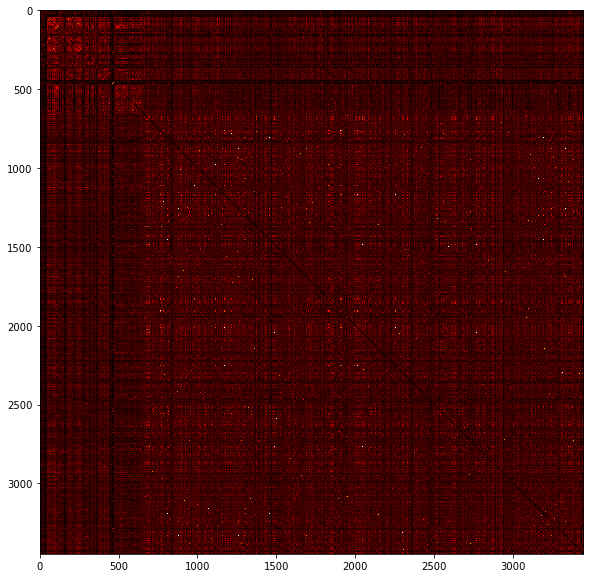

In [17]:
# Compute full similarity matrix by this metric
# Let's make it an (N+M)*(N+M) matrix so we have all-by-all similarities.
# Make coverage set be first N, discrepancies set next M

N = len(release_smi)
M = len(discrepancies_set_smi)

t_matrix = np.zeros( (N+M,N+M), np.float)

comparison_fps = release_set_fp + discrepancies_set_fp
comparison_mols = release_set_mols + discrepancies_set_mols

for n in range(N+M):
    for m in range(N+M):
        if n != m: #Make diagonal elements be zero for more convenience
            t_matrix[n,m] = OETanimoto( comparison_fps[n], comparison_fps[m])

import matplotlib.pyplot as plt
%matplotlib inline

# Plot part of matrix
plt.figure(figsize =(10,10))
#plt.imshow(t_matrix[0:1000,0:1000], cmap='hot')
plt.imshow(t_matrix, cmap='hot')


### Next cluster to find things which are "alone"

In general many of our molecules are not super similar to other molecules, which is fine as long as they are built of fragments which are present in other molecules. However, what we are especially interested in is molecules which contain fragments which are not represented anywhere. To do those, we need some kind of clustering.

I might want some kind of hierarchical clustering, because what I'd like to do is not necessarily group all my molecules into clusters, but instead be able to find which molecules are similar to the least other.

DBSCAN looks interesting as it can find "noise" points which are distant from others, and doesn't take a predefined number of clusters. It also can take a precalculated distance matrix. See https://stackoverflow.com/questions/16246066/clustering-based-on-distance-matrix and https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [11]:
#Make distance matrix run from 1 being far to 0 being close rather than the opposite (Tanimoto)
dis_matrix = np.ones_like(t_matrix)-t_matrix

from sklearn.cluster import DBSCAN
from sklearn import metrics

#data_subset = dis_matrix[0:1000,0:1000]
data_subset = dis_matrix

# eps: Controls maximum distance between two samples to be considered as in neighborhood of the other.
# min_samples: Minimum number of samples (compounds) near a compound for it to be considered a core point
# Metric: precomputed means use precomputed distance matrix
# Note: Currently (on coverage + discrepancies set) epsilon seems not to matter much at low values; few compounds are highly similar
# so there is essentially no difference between 0.001 and 0.1 for example.
# However, I probably actually want to allow SIGNIFICANT difference between compounds; what if I go much higher? 0.7?
# (0.7 corresponds to Tanimoto of 0.3, so some similar fragments)
# Currently eps = 0.7 seems to allow too diverse clusters.
# eps = 0.5 gives pretty homogeneous clusters but maybe too homogeneous; leaves about 2500 molecules NOT in clusters
# eps = 0.6 feels like it's going a little too far but is quite close to what we want. Leaves 1900 not in clusters.
# eps = 0.55 seems reasonably good but leaves 2300 not in cluster. 
# Go with that for now but revisit once I've loaded the actual data.
clustering = DBSCAN(eps=0.58, min_samples = 5, metric="precomputed")

# Fit clustering; do first 100 compounds only for now as a test
db = clustering.fit(data_subset)

# Draw on https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py 
# for useful info
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Total number of points: %d' % len(data_subset))
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 56
Total number of points: 3447
Estimated number of noise points: 2467
Silhouette Coefficient: -0.167


In [12]:
# Retrieve some compounds which are in a cluster and figure out what they are

mols_by_cluster = {}
cluster_nrs = set(labels)

for label in cluster_nrs:
    mols_by_cluster[label] = []
    
    for (idx, thislabel) in enumerate(labels):
        if thislabel==label:
            mols_by_cluster[label].append(comparison_mols[idx])
            
    print("%d molecules in cluster %s" % (len(mols_by_cluster[label]), label))

74 molecules in cluster 0
10 molecules in cluster 1
146 molecules in cluster 2
9 molecules in cluster 3
8 molecules in cluster 4
17 molecules in cluster 5
6 molecules in cluster 6
6 molecules in cluster 7
9 molecules in cluster 8
6 molecules in cluster 9
5 molecules in cluster 10
7 molecules in cluster 11
7 molecules in cluster 12
52 molecules in cluster 13
9 molecules in cluster 14
64 molecules in cluster 15
16 molecules in cluster 16
16 molecules in cluster 17
9 molecules in cluster 18
14 molecules in cluster 19
33 molecules in cluster 20
22 molecules in cluster 21
42 molecules in cluster 22
8 molecules in cluster 23
53 molecules in cluster 24
4 molecules in cluster 25
15 molecules in cluster 26
10 molecules in cluster 27
11 molecules in cluster 28
8 molecules in cluster 29
17 molecules in cluster 30
11 molecules in cluster 31
37 molecules in cluster 32
23 molecules in cluster 33
6 molecules in cluster 34
10 molecules in cluster 35
12 molecules in cluster 36
17 molecules in cluster 3

In [13]:
# Draw molecules in one of these clusters
oemols = [ OEMol(mol) for mol in mols_by_cluster[2]]

from openeye import oedepict
itf = oechem.OEInterface()
PageByPage = True
suppress_h = True
rows = 10
cols = 6
ropts = oedepict.OEReportOptions(rows, cols)
ropts.SetHeaderHeight(25)
ropts.SetFooterHeight(25)
ropts.SetCellGap(2)
ropts.SetPageMargins(10)
report = oedepict.OEReport(ropts)
cellwidth, cellheight = report.GetCellWidth(), report.GetCellHeight()
opts = oedepict.OE2DMolDisplayOptions(cellwidth, cellheight, oedepict.OEScale_Default * 0.5)
opts.SetAromaticStyle(oedepict.OEAromaticStyle_Circle)
pen = oedepict.OEPen(oechem.OEBlack, oechem.OEBlack, oedepict.OEFill_On, 1.0)
opts.SetDefaultBondPen(pen)
oedepict.OESetup2DMolDisplayOptions(opts, itf)
for i, mol in enumerate(oemols):
    cell = report.NewCell()
    mol_copy = oechem.OEMol(mol)
    oedepict.OEPrepareDepiction(mol_copy, False, suppress_h)
    disp = oedepict.OE2DMolDisplay(mol_copy, opts)

    oedepict.OERenderMolecule(cell, disp)
    #oedepict.OEDrawCurvedBorder(cell, oedepict.OELightGreyPen, 10.0)

oedepict.OEWriteReport("mols.pdf", report) 

True

In [14]:
# Figure out which of our clusters don't contain any training set molecules (and which!)

clusters_with_training_mols = []
test_smi = []
for label in cluster_nrs:
    # Get isomeric SMILES strings for molecules in cluster
    cluster_smis = [ OECreateIsoSmiString(mol) for mol in mols_by_cluster[label]]
    
    # Check if these are in training set molecules
    has_training = False
    for smi in cluster_smis:
        if smi in release_smi:
            has_training = True
            tr_smi = smi
            break
    if has_training:
        print("Cluster %s contains training set molecule %s" % (label, tr_smi) )
        clusters_with_training_mols.append(label)
        for smi in cluster_smis:
            if smi not in release_smi and label != -1:
                test_smi.append(smi)
    else:
        print("No training set molecule found for cluster %s." % label)
clusters_with_training_mols.remove(-1) #Remove "outliers" cluster
        
mols_in_tr_set_clusters = 0
for label in clusters_with_training_mols:
    mols_in_tr_set_clusters += len(mols_by_cluster[label])
print("%s molecules in training set clusters" % mols_in_tr_set_clusters)
print("Number of possible test set molecules %s" % len(test_smi))

Cluster 0 contains training set molecule CC(=O)N(C)c1[nH]ccn1
Cluster 1 contains training set molecule C#Cc1ccccc1
Cluster 2 contains training set molecule CC(=O)c1c(cccc1F)F
Cluster 3 contains training set molecule CCS(=O)(=O)c1ccccc1
Cluster 4 contains training set molecule CC[C@@H]1C[C@@]1(c2ccc(nn2)OC)N
Cluster 5 contains training set molecule CCc1ccccc1OC
Cluster 6 contains training set molecule C[C@@H](c1[nH]c(=O)[n-]n1)NC#N
Cluster 7 contains training set molecule C[S@@](=N)(=O)NC1CC1
Cluster 8 contains training set molecule Cc1ccnn1c2ccccc2F
Cluster 9 contains training set molecule CC(C)c1ccccc1
Cluster 10 contains training set molecule CC(=O)Nc1ccccc1
Cluster 11 contains training set molecule CC(=O)Oc1ccccc1
Cluster 12 contains training set molecule Cn1ccnc1c2ccccn2
Cluster 13 contains training set molecule Cc1ccccc1[C@@H]2CCCO2
No training set molecule found for cluster 14.
No training set molecule found for cluster 15.
No training set molecule found for cluster 16.
No traini

### Some sample depiction of a molecule pair

In [ ]:
from openeye.oedepict import *
from openeye.oegrapheme import *
from openeye.oegraphsim import *

# Pull example from 
# https://docs.eyesopen.com/toolkits/cookbook/python/depiction/fpoverlap.html
def SetFingerPrintSimilarity(qmol, tmol, fptype, tag, maxvalue=0):

    qbonds = OEUIntArray(qmol.GetMaxBondIdx())
    tbonds = OEUIntArray(tmol.GetMaxBondIdx())

    for match in OEGetFPOverlap(qmol, tmol, fptype):
        for bond in match.GetPatternBonds():
            qbonds[bond.GetIdx()] += 1
        for bond in match.GetTargetBonds():
            tbonds[bond.GetIdx()] += 1

    maxvalue = max(maxvalue, max(qbonds))
    maxvalue = max(maxvalue, max(tbonds))

    for bond in qmol.GetBonds():
        bond.SetData(tag, qbonds[bond.GetIdx()])
    for bond in tmol.GetBonds():
        bond.SetData(tag, tbonds[bond.GetIdx()])

    return maxvalue

class ColorBondByOverlapScore(OEBondGlyphBase):
    def __init__(self, cg, tag):
        OEBondGlyphBase.__init__(self)
        self.colorg = cg
        self.tag = tag

    def RenderGlyph(self, disp, bond):

        bdisp = disp.GetBondDisplay(bond)
        if bdisp is None or not bdisp.IsVisible():
            return False

        if not bond.HasData(self.tag):
            return False

        linewidth = disp.GetScale() / 3.0
        color = self.colorg.GetColorAt(bond.GetData(self.tag))
        pen = OEPen(color, color, OEFill_Off, linewidth)

        adispB = disp.GetAtomDisplay(bond.GetBgn())
        adispE = disp.GetAtomDisplay(bond.GetEnd())

        layer = disp.GetLayer(OELayerPosition_Below)
        layer.DrawLine(adispB.GetCoords(), adispE.GetCoords(), pen)

        return True

    def ColorBondByOverlapScore(self):
        return ColorBondByOverlapScore(self.colorg, self.tag).__disown__()

def DepictMoleculeOverlaps(image, qmol, tmol, fptype, opts):

    tag = OEGetTag("fpoverlap")
    maxvalue = SetFingerPrintSimilarity(qmol, tmol, fptype, tag)

    colorg = OELinearColorGradient()
    colorg.AddStop(OEColorStop(0.0, OEPinkTint))
    colorg.AddStop(OEColorStop(1.0, OEYellow))
    colorg.AddStop(OEColorStop(maxvalue, OEDarkGreen))
    bondglyph = ColorBondByOverlapScore(colorg, tag)

    OEPrepareDepiction(qmol)
    overlaps = OEGetFPOverlap(qmol, tmol, fptype)
    OEPrepareMultiAlignedDepiction(tmol, qmol, overlaps)

    grid = OEImageGrid(image, 1, 2)
    grid.SetMargin(OEMargin_Bottom, 10)
    opts.SetDimensions(grid.GetCellWidth(), grid.GetCellHeight(), OEScale_AutoScale)
    opts.SetAtomColorStyle(OEAtomColorStyle_WhiteMonochrome)

    molscale = min(OEGetMoleculeScale(qmol, opts), OEGetMoleculeScale(tmol, opts))
    opts.SetScale(molscale)

    qdisp = OE2DMolDisplay(qmol, opts)
    OEAddGlyph(qdisp, bondglyph, IsTrueBond())
    OERenderMolecule(grid.GetCell(1, 1), qdisp)

    tdisp = OE2DMolDisplay(tmol, opts)
    OEAddGlyph(tdisp, bondglyph, IsTrueBond())
    OERenderMolecule(grid.GetCell(1, 2), tdisp)

    qfp = OEFingerPrint()
    OEMakeFP(qfp, qmol, fptype)

    tfp = OEFingerPrint()
    OEMakeFP(tfp, tmol, fptype)

    score = OETanimoto(qfp, tfp)

    font = OEFont(OEFontFamily_Default, OEFontStyle_Default, 16, OEAlignment_Center, OEBlack)
    center = OE2DPoint(image.GetWidth() / 2.0, image.GetHeight() - 10)
    image.DrawText(center, "Tanimoto score = %.3f" % score, font)

In [ ]:
from openeye.oedepict import *
fpt = OEGetFPType(fptype)
height = 400.
width = 2.*height
image = OEImage(width, height)
opts = OE2DMolDisplayOptions(width, height, OEScale_AutoScale)

DepictMoleculeOverlaps(image, coverage_set_mols[4], discrepancies_set_mols[848], fpt, opts)
OEWriteImage("tmp.png", image)



<img src = "tmp.png">